## ONENET : 
---
# *One Network to Solve Them All*  
# Solving Linear Inverse Problems with Deep Projection Models
---

**Github :** https://github.com/image-science-lab/OneNet

** Arxiv : ** <a href="https://arxiv.org/abs/1703.09912" > *One Network to Solve Them All — Solving Linear Inverse Problems using Deep Projection Models </a> - 29 March 2017*
 
**Authors :** <br>
*Jen-Hao Rick Chang (Carnegie Mellon University) <br>
Chun-Liang Li (Carnegie Mellon University) <br> 
Barnabas Poczos (bapoczos@cs.cmu.edu) <br>
Vijayakumar Bhagavatula (Carnegie Mellon University) <br>
Aswin Sankaranarayanan (Carnegie Mellon University)*

<a class="anchor" id="9.0"></a>
##  ADMM - Progress as Images

This notebook shows the implementation and the progress of ADMM for the MNIST dataset. 

<a class="anchor" id="9.1"></a>
### Linear Operators


In [1]:
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import os
import os.path
import timeit
import argparse
import sys

In [6]:
## Helper function to add noise

def add_noise_exe(x, noise_mean = 0.0, noise_std = 0.1):
    noise = np.random.randn(*x.shape) * noise_std + noise_mean;
    y = x + noise
    return y, noise


In [7]:
"""
We use m × d random Gaussian matrices of m
different compression ( d ) as the linear operator A. The images
are vectorized into d-dimensional vectors x and multiplied with the
random Gaussian matrices to form y.
"""

def cs_setup(x_shape, compress_ratio):

    d = np.prod(x_shape).astype(int)
    m = np.round(compress_ratio * d).astype(int)

    A = np.random.randn(m,d) / np.sqrt(m)


    def A_fun(x):
        y = np.dot(A, x.ravel(order='F'))
        y = np.reshape(y, [1, m], order='F')
        return y

    def AT_fun(y):
        y = np.reshape(y, [m, 1], order='F')
        x = np.dot(A.T, y)
        x = np.reshape(x, x_shape, order='F')
        return x

    return (A_fun, AT_fun, A)



In [8]:

""" currently only support width (and height) * resize_ratio is an interger! """
def inpaint_block_setup(x_shape, box_size, total_box = 1):

    spare = 0.25 * box_size

    mask = np.ones(x_shape)

    for i in range(total_box):

        start_row = spare
        end_row = x_shape[1] - spare - box_size - 1
        start_col = spare
        end_col = x_shape[2] - spare - box_size - 1

        idx_row = int(np.random.rand(1) * (end_row - start_row) + start_row)
        idx_col = int(np.random.rand(1) * (end_col - start_col) + start_col)

        mask[0,idx_row:idx_row+box_size,idx_col:idx_col+box_size,:] = 0.


    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)




In [9]:


"""
We fill the center 30% region of the input
images with zeros.
"""
def inpaint_center_setup(x_shape, box_size):


    mask = np.ones(x_shape)


    idx_row = np.round(float(x_shape[1]) / 2.0 - float(box_size) / 2.0).astype(int)
    idx_col = np.round(float(x_shape[2]) / 2.0 - float(box_size) / 2.0).astype(int)

    mask[0,idx_row:idx_row+box_size,idx_col:idx_col+box_size,:] = 0.


    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)


In [10]:
"""
Noisy image
"""
def denoise_setup(x_shape, drop_prob = 0.5):

    mask = np.random.rand(*x_shape) > drop_prob;
    mask = mask.astype('double')

    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)

In [11]:
"""
SUPER-RESOLUTION:
We downsample the images into 50% and 25% of
the original width and height using box-averaging algorithm
"""

def superres_setup(x_shape, resize_ratio):

    box_size = 1.0 / resize_ratio
    if np.mod(x_shape[1], box_size) != 0 or np.mod(x_shape[2], box_size) != 0:
        print("only support width (and height) * resize_ratio is an interger!")


    def A_fun(x):
        y = box_average(x, int(box_size))
        return y

    def AT_fun(y):
        x = box_repeat(y, int(box_size))
        return x

    return (A_fun, AT_fun)



def box_average(x, box_size):
    """ x: [1, row, col, channel] """
    im_row = x.shape[1]
    im_col = x.shape[2]
    channel = x.shape[3]
    out_row = np.floor(float(im_row) / float(box_size)).astype(int)
    out_col = np.floor(float(im_col) / float(box_size)).astype(int)
    y = np.zeros((1,out_row,out_col,channel))
    total_i = int(im_row / box_size)
    total_j = int(im_col / box_size)

    for c in range(channel):
        for i in range(total_i):
            for j in range(total_j):
                avg = np.average(x[0, i*int(box_size):(i+1)*int(box_size), j*int(box_size):(j+1)*int(box_size), c], axis=None)
                y[0,i,j,c] = avg

    return y


def box_repeat(x, box_size):
    """ x: [1, row, col, channel] """
    im_row = x.shape[1]
    im_col = x.shape[2]
    channel = x.shape[3]
    out_row = np.floor(float(im_row) * float(box_size)).astype(int)
    out_col = np.floor(float(im_col) * float(box_size)).astype(int)
    y = np.zeros((1,out_row,out_col,channel))
    total_i = im_row
    total_j = im_col

    for c in range(channel):
        for i in range(total_i):
            for j in range(total_j):
                y[0, i*int(box_size):(i+1)*int(box_size), j*int(box_size):(j+1)*int(box_size), c] = x[0,i,j,c]
    return y

<a class="anchor" id="9.2"></a>
### ADMM Implementation

In [12]:
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt
import matplotlib

In [13]:

def vec(x):
    return x.ravel(order='F')


def sigmoid(x):
    return 1/(1+np.exp(-x))


# A_fun, AT_fun takes a vector (d,1) or (d,) as input
def admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, base_folder, show_img_progress=False, alpha=0.2, max_iter=100, solver_tol=1e-6):
    """ See Wang, Yu, Wotao Yin, and Jinshan Zeng. "Global convergence of ADMM in nonconvex nonsmooth optimization."
    arXiv preprint arXiv:1511.06324 (2015).
    It provides convergence condition: basically with large enough alpha, the program will converge. """

    #result_folder = '%s/iter-imgs' % base_folder
    #if not os.path.exists(result_folder):
        #os.makedirs(result_folder)

    obj_lss = np.zeros(max_iter)
    x_zs = np.zeros(max_iter)
    u_norms = np.zeros(max_iter)
    times = np.zeros(max_iter)

    ATy = AT_fun(y)
    x_shape = ATy.shape
    d = np.prod(x_shape)

    def A_cgs_fun(x):
        x = np.reshape(x, x_shape, order='F')
        y = AT_fun(A_fun(x)) + alpha * x
        return vec(y)
    A_cgs = LinearOperator((d,d), matvec=A_cgs_fun, dtype='float')

    def compute_p_inv_A(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z


    def A_cgs_fun_init(x):
            x = np.reshape(x, x_shape, order='F')
            y = AT_fun(A_fun(x))
            return vec(y)
    A_cgs_init = LinearOperator((d,d), matvec=A_cgs_fun_init, dtype='float')

    def compute_init(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs_init, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z

    # initialize z and u
    z = compute_init(ATy, ATy)

    u = np.zeros(x_shape)

    plot_normalozer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

    start_time = timeit.default_timer()

    for iter in range(max_iter):

        # x-update
        net_input = z+u
        x = np.reshape(denoiser(net_input), x_shape, order='F')

        # z-update
        b = ATy + alpha * (x - u)
        z = compute_p_inv_A(b, z)

        # u-update
        u += z - x;


        if show_img_progress == True:

            fig = plt.figure('current_sol')
            plt.gcf().clear()
            fig.canvas.set_window_title('iter %d' % iter)
            plt.subplot(1,3,1)
            plt.imshow(reshape_img_fun(np.clip(x, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('x')
            plt.subplot(1,3,2)
            plt.imshow(reshape_img_fun(np.clip(z, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('z')
            plt.subplot(1,3,3)
            plt.imshow(reshape_img_fun(np.clip(net_input, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('netin')
            plt.pause(0.00001)


        obj_ls = 0.5 * np.sum(np.square(y - A_fun(x)))
        x_z = np.sqrt(np.mean(np.square(x-z)))
        u_norm = np.sqrt(np.mean(np.square(u)))

        print('iter = %d: obj_ls = %.3e  |x-z| = %.3e  u_norm = %.3e' % (iter, obj_ls, x_z, u_norm))


        obj_lss[iter] = obj_ls
        x_zs[iter] = x_z
        u_norms[iter] = u_norm
        times[iter] = timeit.default_timer() - start_time

        ## save images
        #filename = '%s/%d-x.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-z.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-u.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))



        #_ = raw_input('')
        if x_z < solver_tol:
            break




    infos = {'obj_lss': obj_lss, 'x_zs': x_zs, 'u_norms': u_norms,
             'times': times, 'alpha':alpha,
             'max_iter':max_iter, 'solver_tol':solver_tol}

    return (x, z, u, infos)

In [14]:
"""
Using L1 - wavelet transform as a signal prior
to solve linear inverse problems
"""

# A_fun, AT_fun takes a vector (d,1) or (d,) as input
def l1_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, base_folder, show_img_progress=False, alpha=0.2, max_iter=100, solver_tol=1e-6):
    """ See Wang, Yu, Wotao Yin, and Jinshan Zeng. "Global convergence of ADMM in nonconvex nonsmooth optimization."
    arXiv preprint arXiv:1511.06324 (2015).
    It provides convergence condition: basically with large enough alpha, the program will converge. """

    #result_folder = '%s/iter-imgs' % base_folder
    #if not os.path.exists(result_folder):
        #os.makedirs(result_folder)

    obj_lss = np.zeros(max_iter)
    x_zs = np.zeros(max_iter)
    u_norms = np.zeros(max_iter)
    times = np.zeros(max_iter)

    ATy = AT_fun(y)
    x_shape = ATy.shape
    d = np.prod(x_shape)

    def A_cgs_fun(x):
        x = np.reshape(x, x_shape, order='F')
        y = AT_fun(A_fun(x)) + alpha * x
        return vec(y)
    A_cgs = LinearOperator((d,d), matvec=A_cgs_fun, dtype='float')

    def compute_p_inv_A(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z


    def A_cgs_fun_init(x):
            x = np.reshape(x, x_shape, order='F')
            y = AT_fun(A_fun(x))
            return vec(y)
    A_cgs_init = LinearOperator((d,d), matvec=A_cgs_fun_init, dtype='float')

    def compute_init(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs_init, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z

    # initialize z and u
    z = compute_init(ATy, ATy)

    u = np.zeros(x_shape)

    plot_normalozer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

    start_time = timeit.default_timer()

    for iter in range(max_iter):

        # x-update
        net_input = z+u
        x = np.reshape(denoiser(net_input), x_shape, order='F')

        # z-update
        b = ATy + alpha * (x - u)
        z = compute_p_inv_A(b, z)

        # u-update
        u += z - x;


        if show_img_progress == True:

            fig = plt.figure('current_sol')
            plt.gcf().clear()
            fig.canvas.set_window_title('iter %d' % iter)
            plt.subplot(1,3,1)
            plt.imshow(reshape_img_fun(np.clip(x, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('x')
            plt.subplot(1,3,2)
            plt.imshow(reshape_img_fun(np.clip(z, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('z')
            plt.subplot(1,3,3)
            plt.imshow(reshape_img_fun(np.clip(net_input, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('netin')
            plt.pause(0.00001)


        obj_ls = 0.5 * np.sum(np.square(y - A_fun(x)))
        x_z = np.sqrt(np.mean(np.square(x-z)))
        u_norm = np.sqrt(np.mean(np.square(u)))

        print('iter = %d: obj_ls = %.3e  |x-z| = %.3e  u_norm = %.3e' % (iter, obj_ls, x_z, u_norm))


        obj_lss[iter] = obj_ls
        x_zs[iter] = x_z
        u_norms[iter] = u_norm
        times[iter] = timeit.default_timer() - start_time

        ## save images
        #filename = '%s/%d-x.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-z.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-u.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))



        #_ = raw_input('')
        if x_z < solver_tol:
            break




    infos = {'obj_lss': obj_lss, 'x_zs': x_zs, 'u_norms': u_norms,
             'times': times, 'alpha':alpha,
             'max_iter':max_iter, 'solver_tol':solver_tol}

    return (x, z, u, infos)


<a class="anchor" id="9.3"></a>
###  Running ADMM

In [15]:
from tensorflow.contrib.layers.python.layers import batch_norm as tf_batch_norm
import tensorflow.contrib.slim as slim

def new_fc_layer(bottom, output_size, name=None, bias=True):
    """
    fully connected layer
    """
    shape = bottom.get_shape().as_list()
    dim = np.prod( shape[1:] )
    x = tf.reshape( bottom, [-1, dim])
    input_size = dim

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=[input_size, output_size],
            initializer=tf.truncated_normal_initializer(0., 0.005))
        if bias == True:
            b = tf.get_variable(
                "b",
                shape=[output_size],
                initializer=tf.constant_initializer(0.))
            fc = tf.nn.bias_add( tf.matmul(x, w), b)
        else:
            fc = tf.matmul(x, w)

    return (fc, w)

def new_conv_layer(bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    Convolutional Layer with ELU
    """
    
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.  The corresponding filter size is also adjusted accordingly.
    """      
    
    filter_shape = np.copy(filter_shape)    
    # resize by nearest neighbor
    if stride > 1:
        bottom_shape = bottom.get_shape().as_list()
        bottom = tf.image.resize_nearest_neighbor(bottom, [bottom_shape[1]//stride, bottom_shape[2]//stride])
        filter_shape[0] = filter_shape[0] // stride
        filter_shape[1] = filter_shape[1] // stride
        if filter_shape[0] < 1:
            filter_shape[0] = 1
        if filter_shape[1] < 1:
            filter_shape[1] = 1

    new_stride = 1

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        conv = tf.nn.conv2d( bottom, w, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-1],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(conv, b))
        else:
            output = activation(conv)
    return output

def new_deconv_layer(bottom, filter_shape, output_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.
    """      
    # resize by nearest neighbor
    if stride > 1:
        bottom = tf.image.resize_nearest_neighbor(bottom, [output_shape[1], output_shape[2]])

    new_stride = 1
    new_filter_shape = np.copy(filter_shape)
    new_filter_shape[2] = filter_shape[3]
    new_filter_shape[3] = filter_shape[2]

    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=new_filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        deconv = tf.nn.conv2d(bottom, W, [1,new_stride,new_stride,1], padding=padding)
        #deconv = tf.nn.conv2d_transpose( bottom, W, output_shape, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-2],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(deconv, b))
        else:
            output = activation(deconv)

    return output

def batchnorm(bottom, is_train, num_reference, epsilon=1e-3, decay=0.999, name=None):
    """ virtual batch normalization (poor man's version)
    the first half is the true batch, the second half is the reference batch.
    When num_reference = 0, it is just typical batch normalization.  
    To use virtual batch normalization in test phase, "update_popmean.py" needed to be executed first 
    (in order to store the mean and variance of the reference batch into pop_mean and pop_variance of batchnorm.)
    """

    batch_size = bottom.get_shape().as_list()[0]
    inst_size = batch_size - num_reference
    instance_weight = np.ones([batch_size])

    if inst_size > 0:
        reference_weight = 1.0 - (1.0 / ( num_reference + 1.0))
        instance_weight[0:inst_size] = 1.0 - reference_weight
        instance_weight[inst_size:] = reference_weight
    else:
        decay = 0.0

    return slim.batch_norm(bottom, activation_fn=None, is_training=is_train, decay=decay, scale=True, scope=name, batch_weights=instance_weight)

def channel_wise_fc_layer(bottom, name, bias=True):
    """
    channel-wise fully connected layer
    """
    _, width, height, n_feat_map = bottom.get_shape().as_list()
    #input shape = (7,7,512)
    input_reshape = tf.reshape( bottom, [-1, width*height, n_feat_map] )  # order='C'
    #after reshape = (1,49,512)
    input_transpose = tf.transpose( input_reshape, [2,0,1] )  # n_feat_map * batch * d
    #after transpose = (512,1,49)
    
    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=[n_feat_map,width*height, width*height], # n_feat_map * d * d_filter
            initializer=tf.truncated_normal_initializer(0., 0.005))
        output = tf.matmul(input_transpose, W)  # n_feat_map * batch * d_filter
        #W = (512,49,49)
        #output = broadcasting (512,1,49) * (512,49,49) = (512,1,49)
        # For n>2 broadcasting the 1st dimension, in this case (512) must be the same
        # the 2nd and 3rd dimensions should be broadcastable (1,49) and (49,49)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=width*height,
                initializer=tf.constant_initializer(0.))
            output = tf.nn.bias_add(output, b)

    output_transpose = tf.transpose(output, [1,2,0])  # batch * d_filter * n_feat_map
    output_reshape = tf.reshape( output_transpose, [-1, width, height, n_feat_map] )
    return output_reshape

def build_projection_model(images, is_train, n_reference, use_bias=True, reuse=None):
    """
    Build the graph for the projection network, which shares the architecture of a typical autoencoder.
    To improve contextual awareness, we add a channel-wise fully-connected layer followed by a 2-by-2
    convolution layer at the middle.
    """
    channel_compress_ratio = 4
    dim_latent = 1024

    with tf.variable_scope('PROJ', reuse=reuse):

        with tf.variable_scope('ENCODE'):
            conv0 = new_conv_layer(images, [4,4,3,64], stride=1, bias=use_bias, name="conv0" ) #64
            bn0 = tf.nn.elu(batchnorm(conv0, is_train, n_reference, name='bn0'))
            conv1 = new_conv_layer(bn0, [4,4,64,128], stride=1, bias=use_bias, name="conv1" ) #64
            bn1 = tf.nn.elu(batchnorm(conv1, is_train, n_reference, name='bn1'))
            conv2 = new_conv_layer(bn1, [4,4,128,256], stride=2, bias=use_bias, name="conv2") #32
            bn2 = tf.nn.elu(batchnorm(conv2, is_train, n_reference, name='bn2'))
            conv3 = new_conv_layer(bn2, [4,4,256,512], stride=2, bias=use_bias, name="conv3") #16
            bn3 = tf.nn.elu(batchnorm(conv3, is_train, n_reference, name='bn3'))
            conv4 = new_conv_layer(bn3, [4,4,512,dim_latent], stride=2, bias=use_bias, name="conv4") #8
            bn4 = tf.nn.elu(batchnorm(conv4, is_train, n_reference, name='bn4'))
            fc5 = channel_wise_fc_layer(bn4, 'fc5', bias=False)
            fc5_conv = new_conv_layer(fc5, [2,2,dim_latent, dim_latent], stride=1, bias=use_bias, name="conv_fc")
            latent = tf.nn.elu(batchnorm(fc5_conv, is_train, n_reference, name='latent'))


        deconv3 = new_deconv_layer( latent, [4,4,512,dim_latent], conv3.get_shape().as_list(), stride=2, bias=use_bias, name="deconv3")
        debn3 = tf.nn.elu(batchnorm(deconv3, is_train, n_reference, name='debn3'))
        deconv2 = new_deconv_layer( debn3, [4,4,256,512], conv2.get_shape().as_list(), stride=2, bias=use_bias, name="deconv2")
        debn2 = tf.nn.elu(batchnorm(deconv2, is_train, n_reference, name='debn2'))
        deconv1 = new_deconv_layer( debn2, [4,4,128,256], conv1.get_shape().as_list(), stride=2, bias=use_bias, name="deconv1")
        debn1 = tf.nn.elu(batchnorm(deconv1, is_train, n_reference, name='debn1'))
        deconv0 = new_deconv_layer( debn1, [4,4,64,128], conv0.get_shape().as_list(), stride=1, bias=use_bias, name="deconv0")
        debn0 = tf.nn.elu(batchnorm(deconv0, is_train, n_reference, name='debn0'))
        proj_ori = new_deconv_layer( debn0, [4,4,3,64], images.get_shape().as_list(), stride=1, bias=use_bias, name="recon")
        proj = proj_ori

    return proj, latent

In [26]:
%cd
%cd OneNet
%cd admm
!mkdir clean_paper_results
clean_paper_results = '/home/ubuntu/OneNet/admm/clean_paper_results'

/home/ubuntu
/home/ubuntu/OneNet
/home/ubuntu/OneNet/admm


In [16]:

import math
import matplotlib.pyplot as plt
import sys
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import os


def save_results(folder, infos, x, z, u):
    filename = '%s/infos.mat' % folder
    sp.io.savemat(filename, infos)
    filename = '%s/x.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/z.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/u.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


# index of test images
#idxs = np.random.randint(391854, size=1)

# result folder
#clean_paper_results = 'clean_paper_results' 

# filename of the trained model. If using virtual batch normalization, 
# the popmean and popvariance need to be updated first via update_popmean.py!
iter = 59999
pretrained_folder = os.path.expanduser("/home/ubuntu/OneNet/projector/model/mnist")
pretrained_model_file = '%s/model_iter-%d' % (pretrained_folder, iter)
print(pretrained_model_file)



img_size = (28,28,3)

show_img_progress = False # whether the plot intermediate results (may slow down the process)
run_ours = True           # whether the run the proposed method
run_l1 = False            # whether the run the traditional wavelet sparsity method



#def load_image(filepath): 
    #img = sp.misc.imread(filepath)
    ## <Note> In our original code used to generate the results in the paper, we mistakenly
    ## resize the image directly to the input dimension via
    ## img = sp.misc.imresize(img, [img_size[0], img_size[1]]).astype(float) / 255.0
    ## The following is the corrected version
    #img_shape = img.shape
    #min_edge = min(img_shape[0], img_shape[1])
    #min_resize_ratio = float(img_size[0]) / float(min_edge)
    #max_resize_ratio = min_resize_ratio * 2.0
    #resize_ratio = np.random.rand() * (max_resize_ratio - min_resize_ratio) + min_resize_ratio

    #img = sp.misc.imresize(img, resize_ratio).astype(float) / 255.0
    #crop_loc_row = np.random.randint(img.shape[0]-img_size[0]+1)
    #crop_loc_col = np.random.randint(img.shape[1]-img_size[1]+1)
    #if len(img.shape) == 3:
        #img = img[crop_loc_row:crop_loc_row+img_size[0], crop_loc_col:crop_loc_col+img_size[1],:]
    #else:
        #img = img[crop_loc_row:crop_loc_row+img_size[0], crop_loc_col:crop_loc_col+img_size[1]]        
    #if len(img.shape) < 3:
        #img = np.tile(img, [1,1,3])
    #return img        

def solve_denoising_dropping(ori_img, denoiser, reshape_img_fun, drop_prob=0.3,
                             noise_mean=0, noise_std=0.1,
                             alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = denoise_setup(x_shape, drop_prob=drop_prob)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('denoise')
        plt.gcf().clear()
        fig.canvas.set_window_title('denoise')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'drop_prob': drop_prob, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/denoise_ratio%.2f_std%.2f' % (result_folder, drop_prob, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                    show_img_progress=show_img_progress, alpha=alpha_l1,
                                    max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_inpaint_center(ori_img, denoiser, reshape_img_fun, box_size=1,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = inpaint_center_setup(x_shape, box_size=box_size)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('inpaint_center')
        plt.gcf().clear()
        fig.canvas.set_window_title('inpaint_center')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'box_size': box_size, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/inpaintcenter_bs%d_std%.2f' % (result_folder, box_size, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_inpaint_block(ori_img, denoiser, reshape_img_fun, box_size=1, total_box=1,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):
    #import inpaint_block as problem
    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = inpaint_block_setup(x_shape, box_size=box_size, total_box=total_box)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('inpaint')
        plt.gcf().clear()
        fig.canvas.set_window_title('inpaint')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)


    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'box_size': box_size,
            'total_box': total_box, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}


    # save the problem
    base_folder = '%s/inpaint_bs%d_tb%d_std%.2f' % (result_folder, box_size, total_box, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)


def solve_superres(ori_img, denoiser, reshape_img_fun, resize_ratio=0.5,
                   noise_mean=0, noise_std=0.,
                   alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun) = superres_setup(x_shape, resize_ratio=resize_ratio)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    bicubic_img = sp.misc.imresize(y[0], [ori_img.shape[1], ori_img.shape[2]], interp='bicubic')
    if show_img_progress:
        fig = plt.figure('superres')
        plt.gcf().clear()
        fig.canvas.set_window_title('superres')
        plt.subplot(1,3,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,3,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.subplot(1,3,3)
        plt.imshow(np.clip(bicubic_img,0,255), interpolation='nearest')
        plt.title('bicubic')
        plt.pause(0.00001)

    bicubic_img = bicubic_img.astype(float) / 255.0
    l2_dis = np.mean(np.square(ori_img[0] - bicubic_img))

    print('bicubic err = %f' % (l2_dis))


    info = {'ori_img': ori_img, 'y': y, 'bicubic': bicubic_img, 'noise': noise, 'resize_ratio': resize_ratio,
            'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/superres_ratio%.2f_std%.2f' % (result_folder, resize_ratio, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/bicubic_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((bicubic_img*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_cs(ori_img, denoiser, reshape_img_fun, compress_ratio,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, A) = cs_setup(x_shape, compress_ratio)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'compress_ratio': compress_ratio,
                'noise_std': noise_std,
                'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/cs_ratio%.2f_std%.2f' % (result_folder, compress_ratio, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def reshape_img(img):
    return img[0]


if run_ours:
    # setup the variables in the session
    n_reference = 0
    batch_size = n_reference + 1
    images_tf = tf.placeholder( tf.float32, [batch_size, img_size[0], img_size[1], img_size[2]], name="images")
    is_train = False
    proj, latent = build_projection_model(images_tf, is_train, n_reference, use_bias=True, reuse=None)

    

# load the dataset



# We create a session to use the graph and restore the variables
if run_ours:
    print ('loading model...')
    sess = tf.Session()

    #global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    #print([global_var.name for global_var in global_vars])
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=100)
    saver.restore(sess, pretrained_model_file)
    #print(sess.run(tf.global_variables()))
    print ('finished reload.')

# define denoiser
def denoise(x):
    x_shape = x.shape
    x = np.reshape(x, [1, img_size[0], img_size[1], img_size[2]], order='F')
    x = (x - 0.5) * 2.0

    y = sess.run(proj, feed_dict={images_tf: x})
    y = (y / 2.0) + 0.5
    return np.reshape(y, x_shape)


def denoise_batch(x):
    x_shape = x.shape

    ys = np.zeros(x_shape)
    for i in range(x_shape[0]):
        ys[i] = denoise(x[i])
    return ys



/home/ubuntu/OneNet/projector/model/mnist/model_iter-59999
loading model...
finished reload.


In [21]:
def load_image(filepath):
    print("Loading test image from : " + filepath)
    img = sp.misc.imread(filepath)
    #img = sp.misc.imresize(img, [28,28,1]).astype(float) / 255.0
    img = img/255.0
    if len(img.shape) < 3:
        img = np.tile(img, [1,1,3])
    return img

In [22]:
def add_noise_exe(x, noise_mean = 0.0, noise_std = 0.1):
    noise = np.random.randn(*x.shape) * noise_std + noise_mean;
    y = x + noise
    return y, noise

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
show_img_progress = True


In [19]:
%cd
%cd OneNet
!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_1.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_2.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_3.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_4.jpg

# Test Images that can be given, please uncomment to test it.

/home/ubuntu
/home/ubuntu/OneNet
--2018-06-30 12:10:58--  https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 572 [image/jpeg]
Saving to: ‘img_1.jpg.1’

img_1.jpg.1         100%[===================>]     572  --.-KB/s    in 0s      

2018-06-30 12:10:58 (122 MB/s) - ‘img_1.jpg.1’ saved [572/572]



Loading test image from : /home/ubuntu/OneNet/img_1.jpg
(1, 28, 84)
28


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


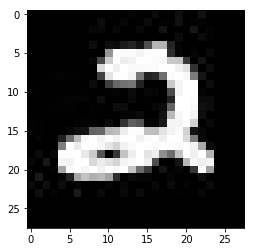

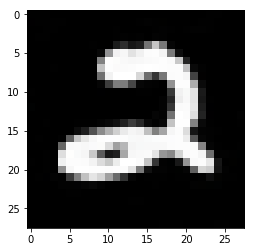

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imresize` is deprecated!
`imresize` is depr

super resolution


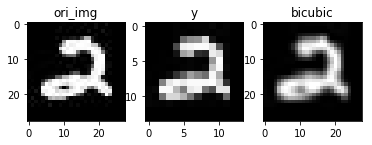

bicubic err = 0.010642


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: `imresize` is deprecated!
`imresize` is 

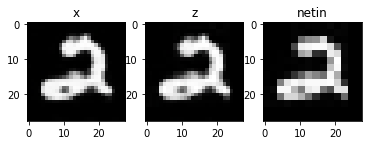

iter = 0: obj_ls = 4.858e-01  |x-z| = 2.710e-02  u_norm = 2.710e-02


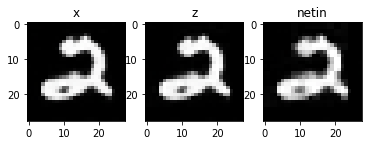

iter = 1: obj_ls = 1.771e-01  |x-z| = 1.231e-02  u_norm = 3.146e-02


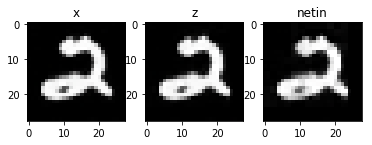

iter = 2: obj_ls = 1.390e-01  |x-z| = 1.432e-02  u_norm = 3.300e-02


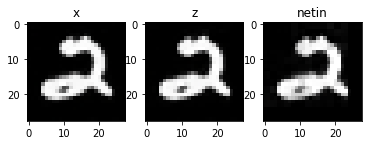

iter = 3: obj_ls = 1.089e-01  |x-z| = 6.697e-03  u_norm = 3.444e-02


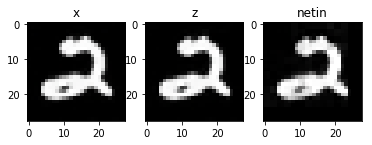

iter = 4: obj_ls = 1.100e-01  |x-z| = 6.734e-03  u_norm = 3.551e-02


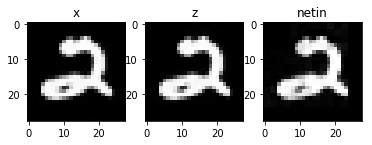

iter = 5: obj_ls = 1.027e-01  |x-z| = 4.861e-03  u_norm = 3.592e-02


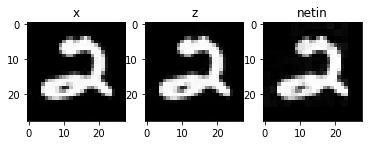

iter = 6: obj_ls = 1.017e-01  |x-z| = 8.302e-03  u_norm = 3.759e-02


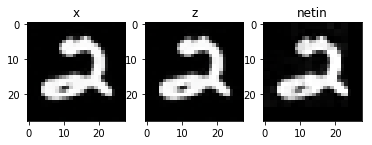

iter = 7: obj_ls = 1.023e-01  |x-z| = 6.323e-03  u_norm = 3.704e-02


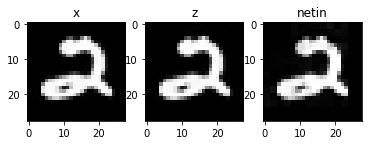

iter = 8: obj_ls = 9.744e-02  |x-z| = 5.714e-03  u_norm = 3.745e-02


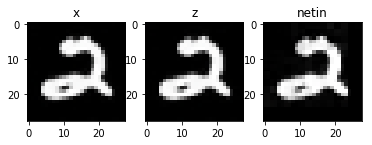

iter = 9: obj_ls = 9.989e-02  |x-z| = 1.770e-03  u_norm = 3.771e-02
compressive sensing


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel

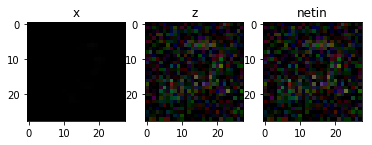

iter = 0: obj_ls = 2.214e+02  |x-z| = 1.329e-01  u_norm = 1.329e-01


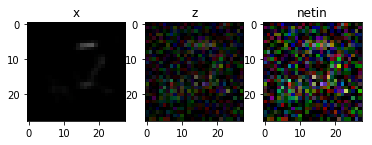

iter = 1: obj_ls = 2.010e+02  |x-z| = 1.249e-01  u_norm = 2.566e-01


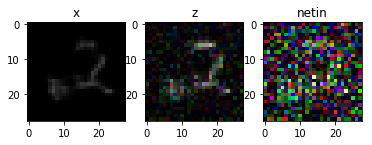

iter = 2: obj_ls = 1.772e+02  |x-z| = 1.136e-01  u_norm = 3.657e-01


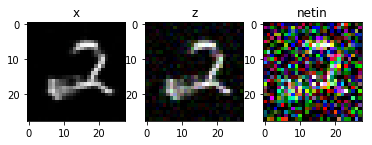

iter = 3: obj_ls = 7.399e+01  |x-z| = 6.725e-02  u_norm = 4.223e-01


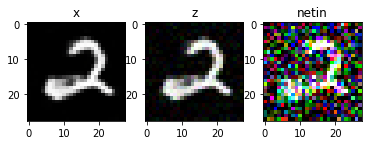

iter = 4: obj_ls = 3.419e+01  |x-z| = 4.530e-02  u_norm = 4.432e-01


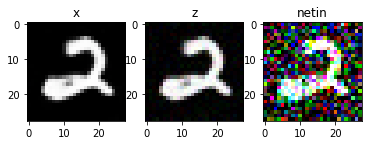

iter = 5: obj_ls = 1.461e+01  |x-z| = 3.392e-02  u_norm = 4.387e-01


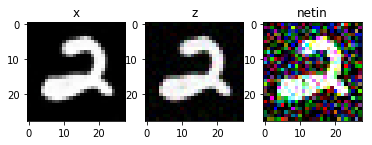

iter = 6: obj_ls = 1.071e+01  |x-z| = 3.469e-02  u_norm = 4.220e-01


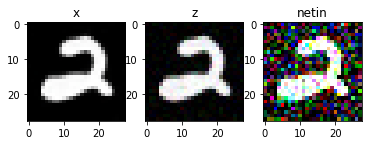

iter = 7: obj_ls = 1.353e+01  |x-z| = 3.818e-02  u_norm = 4.025e-01


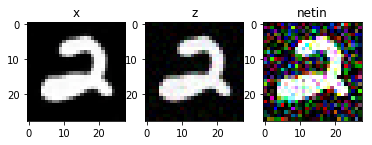

iter = 8: obj_ls = 1.697e+01  |x-z| = 4.774e-02  u_norm = 3.856e-01


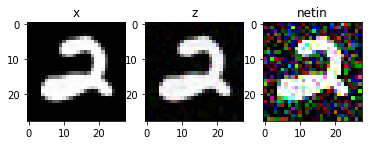

iter = 9: obj_ls = 1.254e+01  |x-z| = 3.559e-02  u_norm = 3.726e-01


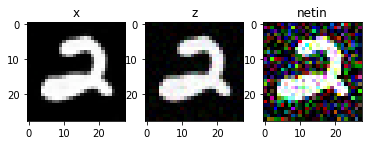

iter = 10: obj_ls = 1.183e+01  |x-z| = 3.376e-02  u_norm = 3.625e-01


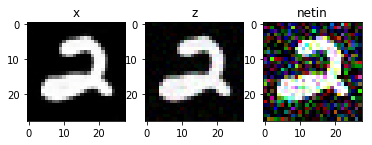

iter = 11: obj_ls = 1.152e+01  |x-z| = 3.243e-02  u_norm = 3.555e-01


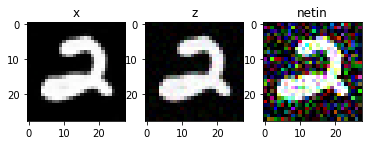

iter = 12: obj_ls = 1.121e+01  |x-z| = 3.110e-02  u_norm = 3.512e-01


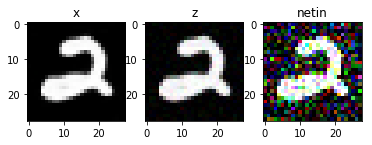

iter = 13: obj_ls = 1.082e+01  |x-z| = 2.965e-02  u_norm = 3.495e-01


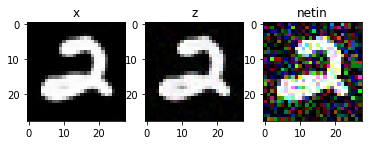

iter = 14: obj_ls = 1.037e+01  |x-z| = 4.233e-02  u_norm = 3.480e-01


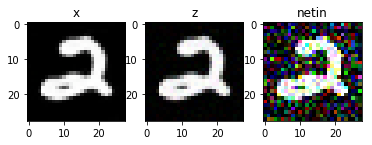

iter = 15: obj_ls = 4.634e+00  |x-z| = 1.944e-02  u_norm = 3.430e-01


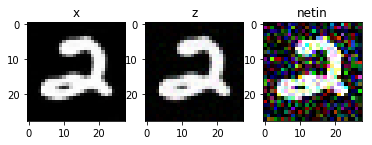

iter = 16: obj_ls = 3.852e+00  |x-z| = 2.599e-02  u_norm = 3.379e-01


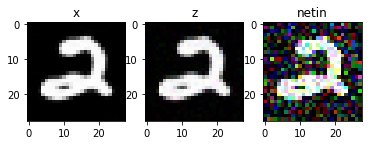

iter = 17: obj_ls = 4.014e+00  |x-z| = 1.982e-02  u_norm = 3.345e-01


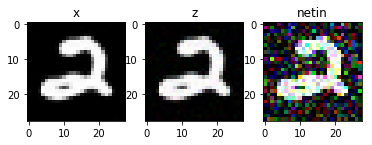

iter = 18: obj_ls = 4.105e+00  |x-z| = 1.725e-02  u_norm = 3.325e-01


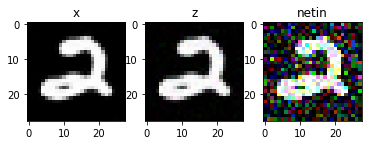

iter = 19: obj_ls = 3.929e+00  |x-z| = 1.725e-02  u_norm = 3.312e-01


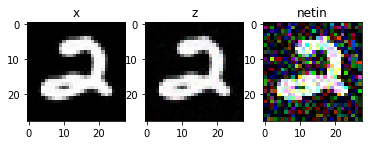

iter = 20: obj_ls = 3.969e+00  |x-z| = 1.580e-02  u_norm = 3.308e-01


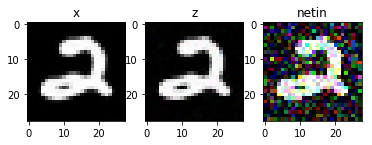

iter = 21: obj_ls = 3.716e+00  |x-z| = 3.406e-02  u_norm = 3.291e-01


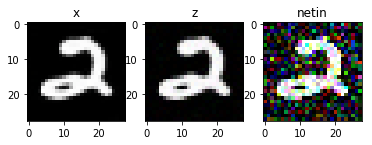

iter = 22: obj_ls = 2.255e+00  |x-z| = 2.500e-02  u_norm = 3.261e-01


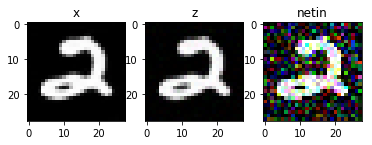

iter = 23: obj_ls = 2.237e+00  |x-z| = 2.404e-02  u_norm = 3.231e-01


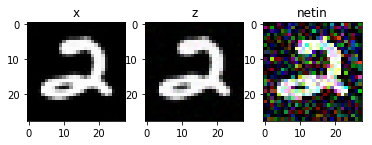

iter = 24: obj_ls = 2.371e+00  |x-z| = 2.129e-02  u_norm = 3.202e-01


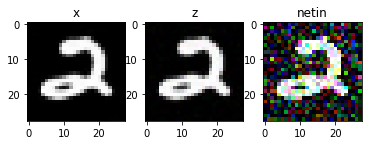

iter = 25: obj_ls = 2.042e+00  |x-z| = 1.436e-02  u_norm = 3.183e-01


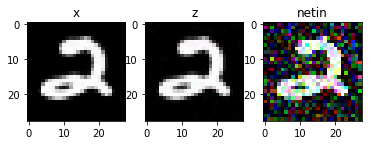

iter = 26: obj_ls = 1.983e+00  |x-z| = 1.230e-02  u_norm = 3.169e-01


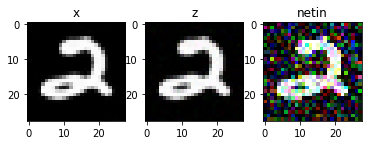

iter = 27: obj_ls = 1.947e+00  |x-z| = 1.219e-02  u_norm = 3.161e-01


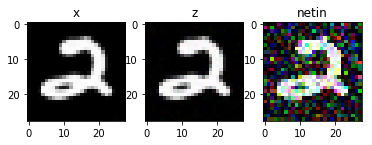

iter = 28: obj_ls = 1.936e+00  |x-z| = 1.055e-02  u_norm = 3.155e-01


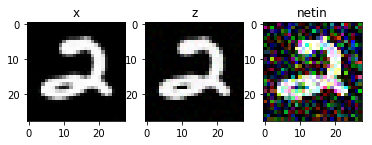

iter = 29: obj_ls = 1.894e+00  |x-z| = 3.401e-02  u_norm = 3.132e-01


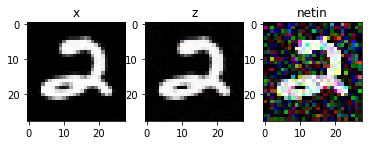

iter = 30: obj_ls = 1.990e+00  |x-z| = 3.174e-02  u_norm = 3.124e-01


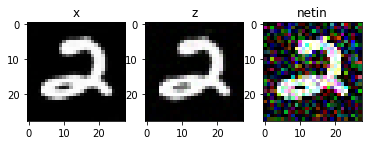

iter = 31: obj_ls = 1.602e+00  |x-z| = 3.080e-02  u_norm = 3.097e-01


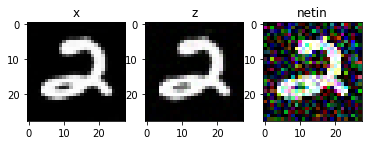

iter = 32: obj_ls = 2.260e+00  |x-z| = 2.907e-02  u_norm = 3.093e-01


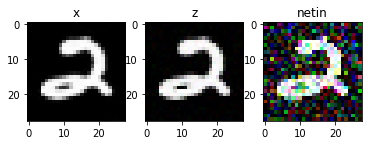

iter = 33: obj_ls = 1.843e+00  |x-z| = 2.822e-02  u_norm = 3.075e-01


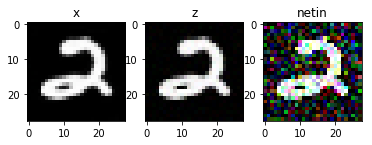

iter = 34: obj_ls = 2.288e+00  |x-z| = 2.622e-02  u_norm = 3.073e-01


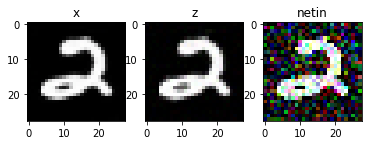

iter = 35: obj_ls = 2.005e+00  |x-z| = 2.520e-02  u_norm = 3.059e-01


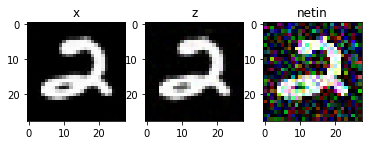

iter = 36: obj_ls = 2.097e+00  |x-z| = 2.384e-02  u_norm = 3.064e-01


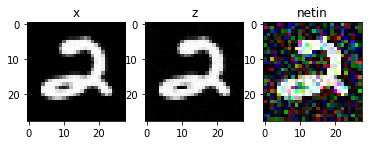

iter = 37: obj_ls = 1.992e+00  |x-z| = 2.349e-02  u_norm = 3.057e-01


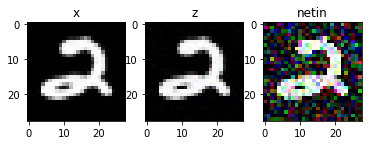

iter = 38: obj_ls = 1.777e+00  |x-z| = 2.271e-02  u_norm = 3.065e-01


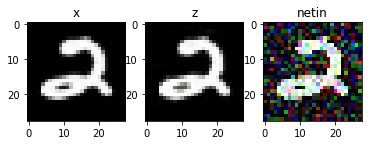

iter = 39: obj_ls = 1.830e+00  |x-z| = 2.241e-02  u_norm = 3.062e-01


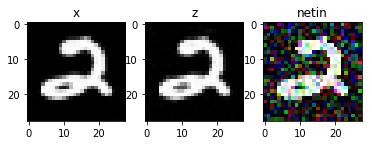

iter = 40: obj_ls = 1.511e+00  |x-z| = 2.140e-02  u_norm = 3.073e-01


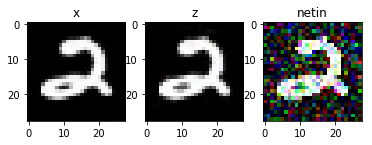

iter = 41: obj_ls = 1.612e+00  |x-z| = 2.090e-02  u_norm = 3.099e-01


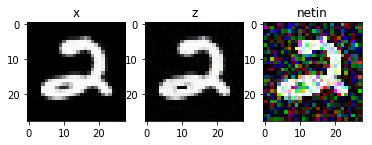

iter = 42: obj_ls = 1.630e+00  |x-z| = 4.042e-02  u_norm = 3.083e-01


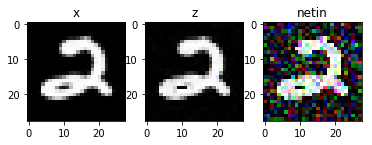

iter = 43: obj_ls = 1.324e+00  |x-z| = 3.914e-02  u_norm = 3.110e-01


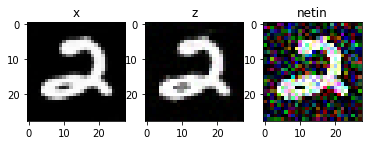

iter = 44: obj_ls = 1.410e+00  |x-z| = 3.919e-02  u_norm = 3.095e-01


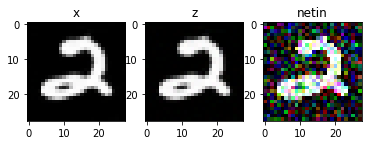

iter = 45: obj_ls = 1.337e+00  |x-z| = 5.051e-03  u_norm = 3.098e-01


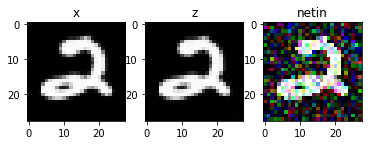

iter = 46: obj_ls = 1.417e+00  |x-z| = 8.526e-03  u_norm = 3.100e-01


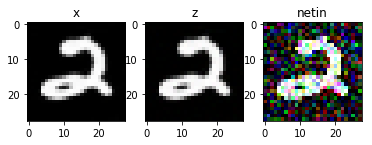

iter = 47: obj_ls = 1.283e+00  |x-z| = 5.129e-03  u_norm = 3.103e-01


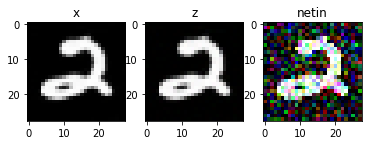

iter = 48: obj_ls = 1.290e+00  |x-z| = 5.033e-03  u_norm = 3.108e-01


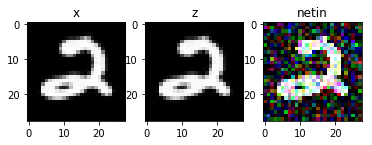

iter = 49: obj_ls = 1.291e+00  |x-z| = 4.991e-03  u_norm = 3.113e-01


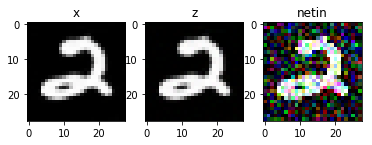

iter = 50: obj_ls = 1.293e+00  |x-z| = 4.959e-03  u_norm = 3.120e-01


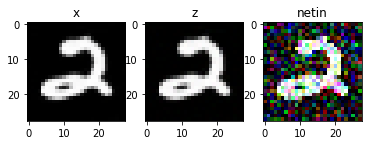

iter = 51: obj_ls = 1.294e+00  |x-z| = 4.934e-03  u_norm = 3.127e-01


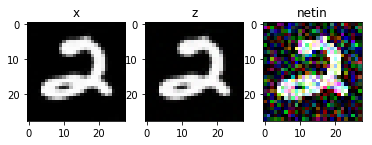

iter = 52: obj_ls = 1.295e+00  |x-z| = 4.913e-03  u_norm = 3.136e-01


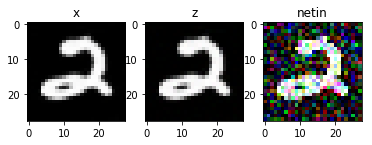

iter = 53: obj_ls = 1.297e+00  |x-z| = 4.896e-03  u_norm = 3.145e-01


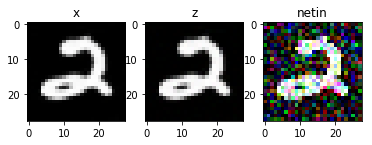

iter = 54: obj_ls = 1.298e+00  |x-z| = 4.883e-03  u_norm = 3.155e-01


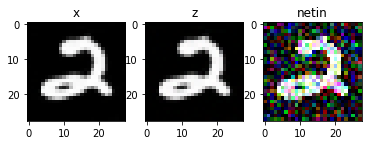

iter = 55: obj_ls = 1.300e+00  |x-z| = 3.393e-03  u_norm = 3.164e-01


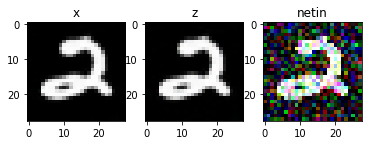

iter = 56: obj_ls = 1.295e+00  |x-z| = 3.380e-03  u_norm = 3.172e-01


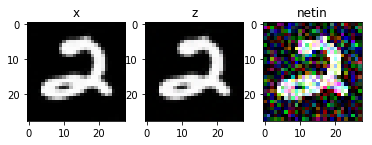

iter = 57: obj_ls = 1.296e+00  |x-z| = 3.378e-03  u_norm = 3.182e-01


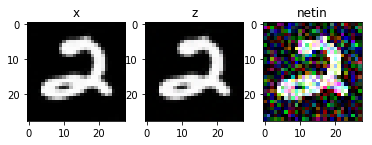

iter = 58: obj_ls = 1.297e+00  |x-z| = 3.380e-03  u_norm = 3.191e-01


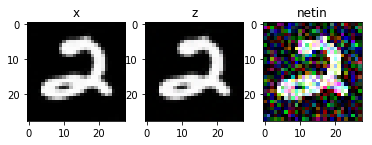

iter = 59: obj_ls = 1.298e+00  |x-z| = 3.383e-03  u_norm = 3.201e-01


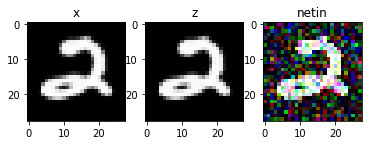

iter = 60: obj_ls = 1.299e+00  |x-z| = 3.387e-03  u_norm = 3.211e-01


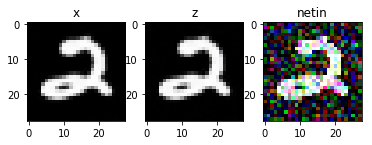

iter = 61: obj_ls = 1.300e+00  |x-z| = 3.391e-03  u_norm = 3.222e-01


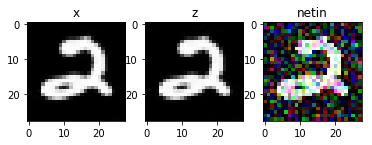

iter = 62: obj_ls = 1.301e+00  |x-z| = 3.397e-03  u_norm = 3.233e-01


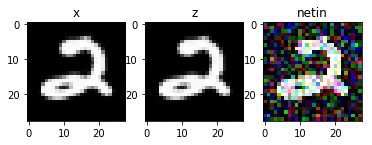

iter = 63: obj_ls = 1.303e+00  |x-z| = 3.403e-03  u_norm = 3.245e-01


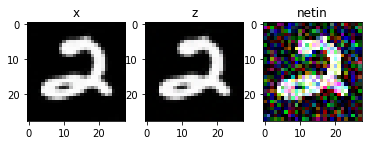

iter = 64: obj_ls = 1.304e+00  |x-z| = 3.410e-03  u_norm = 3.257e-01


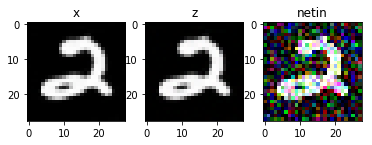

iter = 65: obj_ls = 1.305e+00  |x-z| = 3.418e-03  u_norm = 3.269e-01


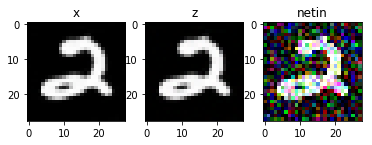

iter = 66: obj_ls = 1.306e+00  |x-z| = 3.426e-03  u_norm = 3.282e-01


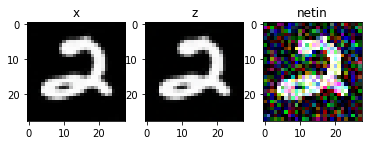

iter = 67: obj_ls = 1.308e+00  |x-z| = 2.257e-03  u_norm = 3.291e-01
denoising


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:387: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


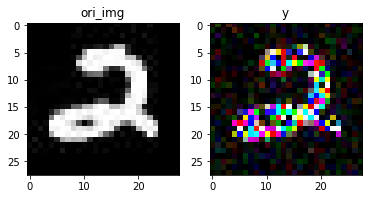

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


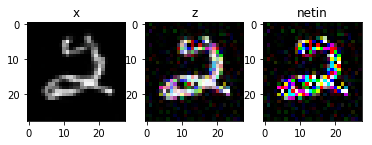

iter = 0: obj_ls = 3.938e+01  |x-z| = 1.287e-01  u_norm = 1.287e-01


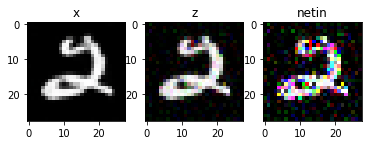

iter = 1: obj_ls = 1.792e+01  |x-z| = 5.605e-02  u_norm = 1.649e-01


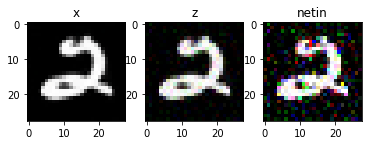

iter = 2: obj_ls = 1.421e+01  |x-z| = 4.463e-02  u_norm = 1.764e-01


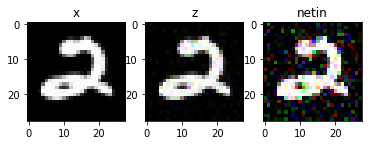

iter = 3: obj_ls = 1.328e+01  |x-z| = 3.852e-02  u_norm = 1.838e-01


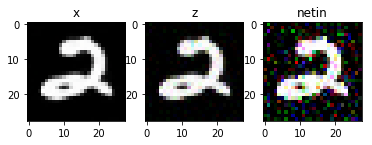

iter = 4: obj_ls = 1.306e+01  |x-z| = 3.271e-02  u_norm = 1.929e-01


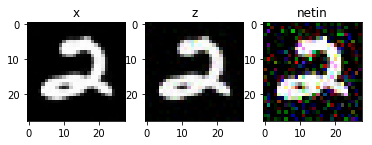

iter = 5: obj_ls = 1.296e+01  |x-z| = 2.212e-02  u_norm = 2.032e-01


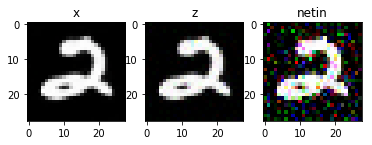

iter = 6: obj_ls = 1.291e+01  |x-z| = 1.686e-02  u_norm = 2.120e-01


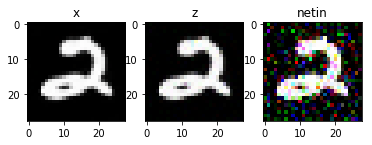

iter = 7: obj_ls = 1.289e+01  |x-z| = 1.301e-02  u_norm = 2.192e-01


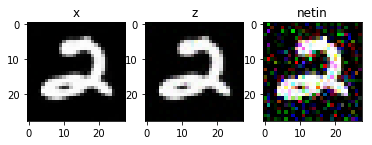

iter = 8: obj_ls = 1.289e+01  |x-z| = 1.001e-02  u_norm = 2.251e-01


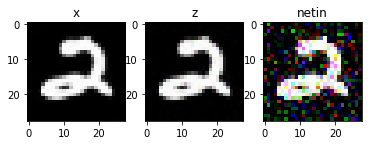

iter = 9: obj_ls = 1.289e+01  |x-z| = 1.016e-02  u_norm = 2.313e-01


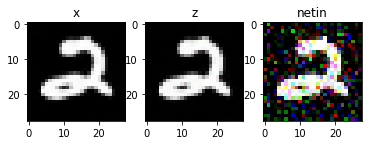

iter = 10: obj_ls = 1.289e+01  |x-z| = 5.456e-03  u_norm = 2.346e-01


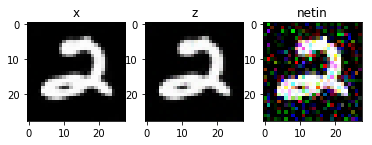

iter = 11: obj_ls = 1.289e+01  |x-z| = 5.273e-03  u_norm = 2.380e-01


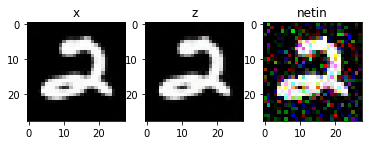

iter = 12: obj_ls = 1.290e+01  |x-z| = 4.964e-03  u_norm = 2.415e-01


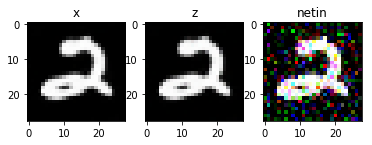

iter = 13: obj_ls = 1.290e+01  |x-z| = 2.644e-03  u_norm = 2.426e-01
inpaint block


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:125: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


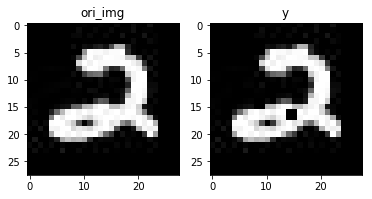

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:229: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:229: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


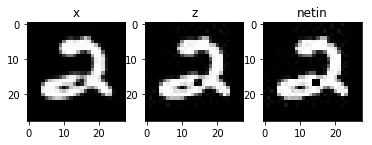

iter = 0: obj_ls = 2.997e+00  |x-z| = 4.006e-02  u_norm = 4.006e-02


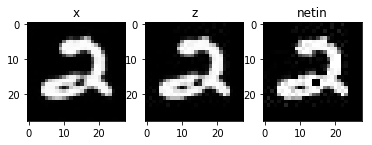

iter = 1: obj_ls = 2.172e+00  |x-z| = 2.517e-02  u_norm = 6.443e-02


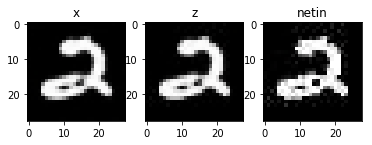

iter = 2: obj_ls = 1.732e+00  |x-z| = 1.707e-02  u_norm = 7.975e-02


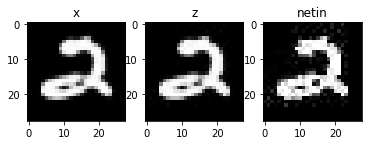

iter = 3: obj_ls = 1.489e+00  |x-z| = 1.347e-02  u_norm = 8.989e-02


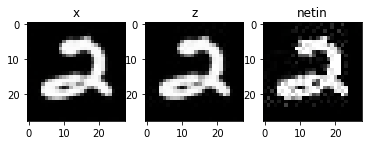

iter = 4: obj_ls = 1.363e+00  |x-z| = 1.254e-02  u_norm = 9.685e-02


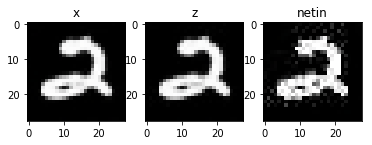

iter = 5: obj_ls = 1.301e+00  |x-z| = 1.113e-02  u_norm = 1.007e-01


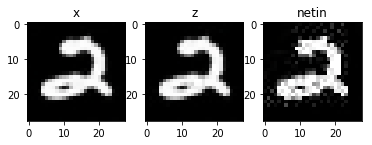

iter = 6: obj_ls = 1.282e+00  |x-z| = 9.279e-03  u_norm = 1.025e-01


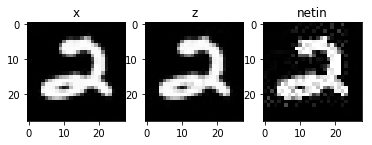

iter = 7: obj_ls = 1.275e+00  |x-z| = 9.933e-03  u_norm = 1.050e-01


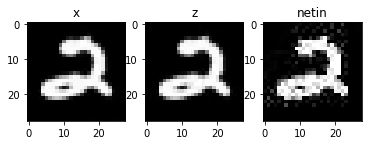

iter = 8: obj_ls = 1.268e+00  |x-z| = 5.160e-03  u_norm = 1.057e-01


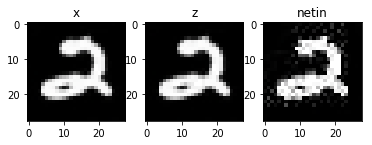

iter = 9: obj_ls = 1.271e+00  |x-z| = 5.418e-03  u_norm = 1.067e-01


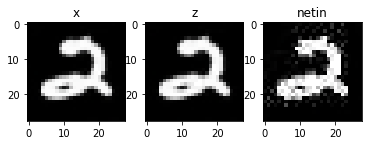

iter = 10: obj_ls = 1.270e+00  |x-z| = 5.227e-03  u_norm = 1.080e-01


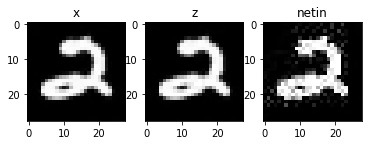

iter = 11: obj_ls = 1.273e+00  |x-z| = 5.169e-03  u_norm = 1.095e-01


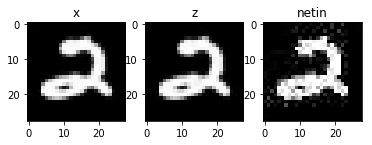

iter = 12: obj_ls = 1.276e+00  |x-z| = 2.975e-03  u_norm = 1.096e-01


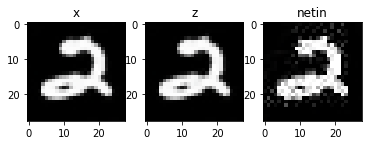

iter = 13: obj_ls = 1.270e+00  |x-z| = 2.823e-03  u_norm = 1.097e-01


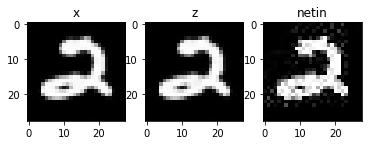

iter = 14: obj_ls = 1.271e+00  |x-z| = 2.724e-03  u_norm = 1.099e-01


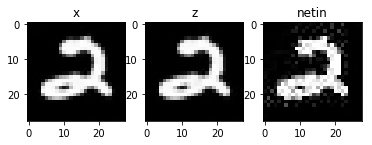

iter = 15: obj_ls = 1.272e+00  |x-z| = 2.647e-03  u_norm = 1.102e-01


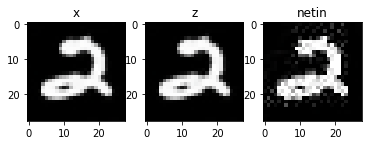

iter = 16: obj_ls = 1.273e+00  |x-z| = 2.575e-03  u_norm = 1.106e-01


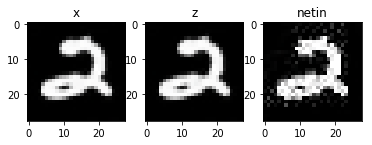

iter = 17: obj_ls = 1.274e+00  |x-z| = 2.509e-03  u_norm = 1.110e-01


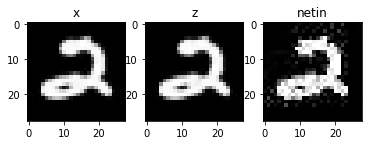

iter = 18: obj_ls = 1.275e+00  |x-z| = 2.452e-03  u_norm = 1.114e-01


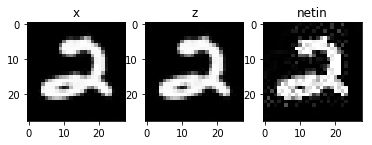

iter = 19: obj_ls = 1.276e+00  |x-z| = 2.409e-03  u_norm = 1.119e-01


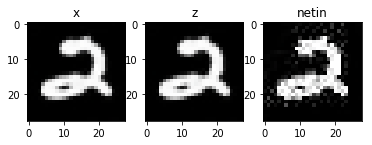

iter = 20: obj_ls = 1.277e+00  |x-z| = 2.382e-03  u_norm = 1.125e-01


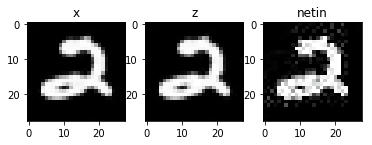

iter = 21: obj_ls = 1.278e+00  |x-z| = 1.449e-02  u_norm = 1.112e-01


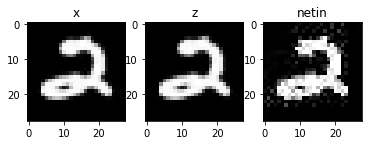

iter = 22: obj_ls = 1.285e+00  |x-z| = 1.390e-02  u_norm = 1.116e-01


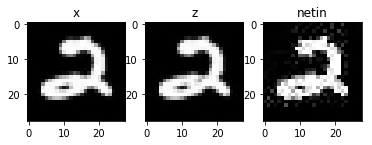

iter = 23: obj_ls = 1.289e+00  |x-z| = 1.364e-02  u_norm = 1.106e-01


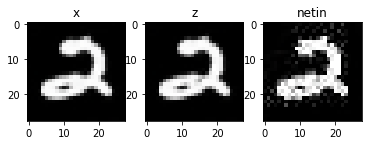

iter = 24: obj_ls = 1.267e+00  |x-z| = 1.315e-02  u_norm = 1.110e-01


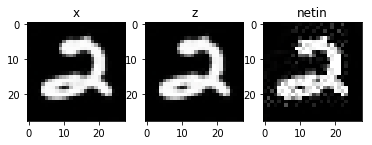

iter = 25: obj_ls = 1.305e+00  |x-z| = 1.340e-02  u_norm = 1.102e-01


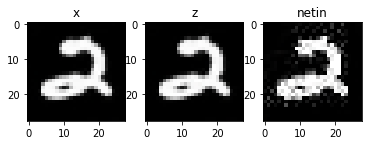

iter = 26: obj_ls = 1.286e+00  |x-z| = 1.179e-02  u_norm = 1.106e-01


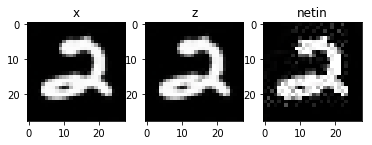

iter = 27: obj_ls = 1.287e+00  |x-z| = 1.118e-02  u_norm = 1.101e-01


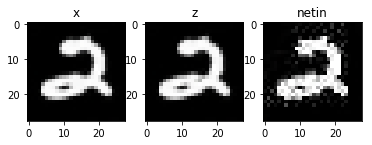

iter = 28: obj_ls = 1.265e+00  |x-z| = 1.100e-02  u_norm = 1.104e-01


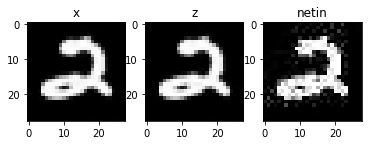

iter = 29: obj_ls = 1.288e+00  |x-z| = 1.114e-02  u_norm = 1.098e-01


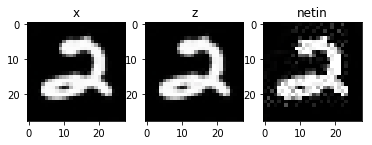

iter = 30: obj_ls = 1.283e+00  |x-z| = 1.083e-02  u_norm = 1.103e-01


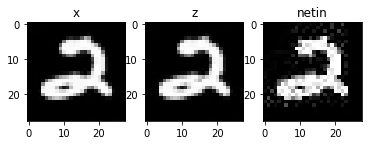

iter = 31: obj_ls = 1.286e+00  |x-z| = 1.045e-02  u_norm = 1.099e-01


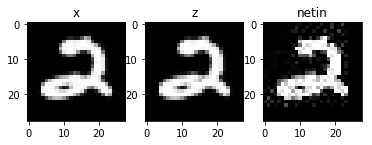

iter = 32: obj_ls = 1.264e+00  |x-z| = 1.039e-02  u_norm = 1.102e-01


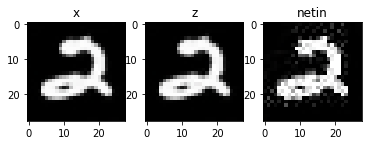

iter = 33: obj_ls = 1.284e+00  |x-z| = 1.047e-02  u_norm = 1.097e-01


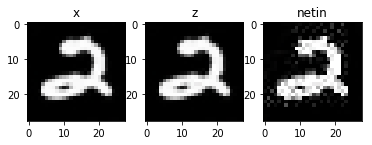

iter = 34: obj_ls = 1.282e+00  |x-z| = 1.037e-02  u_norm = 1.102e-01


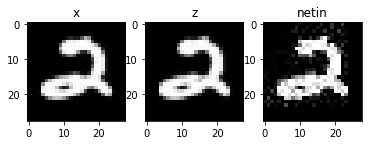

iter = 35: obj_ls = 1.285e+00  |x-z| = 1.007e-02  u_norm = 1.098e-01


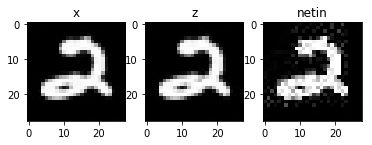

iter = 36: obj_ls = 1.264e+00  |x-z| = 1.007e-02  u_norm = 1.101e-01


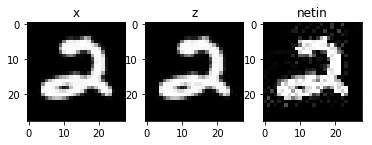

iter = 37: obj_ls = 1.281e+00  |x-z| = 1.012e-02  u_norm = 1.097e-01


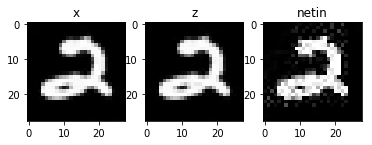

iter = 38: obj_ls = 1.282e+00  |x-z| = 1.009e-02  u_norm = 1.102e-01


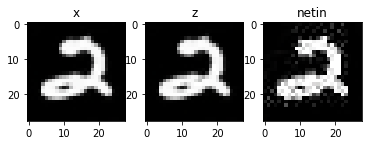

iter = 39: obj_ls = 1.285e+00  |x-z| = 9.841e-03  u_norm = 1.098e-01


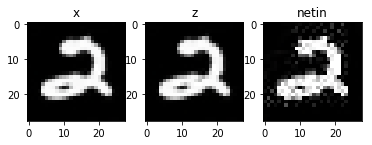

iter = 40: obj_ls = 1.264e+00  |x-z| = 9.860e-03  u_norm = 1.101e-01


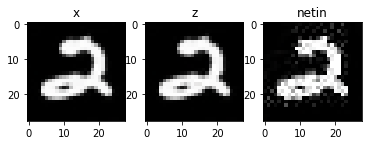

iter = 41: obj_ls = 1.280e+00  |x-z| = 9.888e-03  u_norm = 1.097e-01


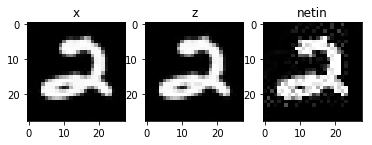

iter = 42: obj_ls = 1.282e+00  |x-z| = 9.891e-03  u_norm = 1.101e-01


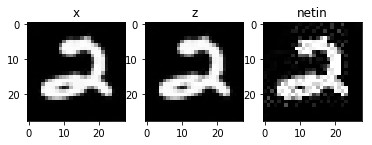

iter = 43: obj_ls = 1.284e+00  |x-z| = 9.673e-03  u_norm = 1.098e-01


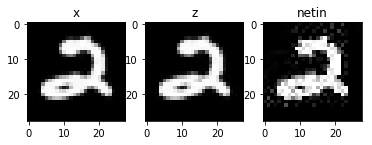

iter = 44: obj_ls = 1.264e+00  |x-z| = 9.698e-03  u_norm = 1.100e-01


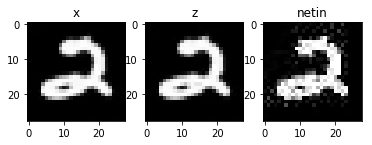

iter = 45: obj_ls = 1.278e+00  |x-z| = 9.711e-03  u_norm = 1.097e-01


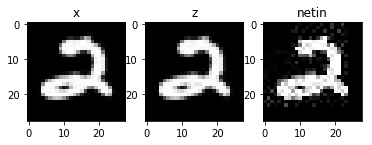

iter = 46: obj_ls = 1.281e+00  |x-z| = 9.728e-03  u_norm = 1.101e-01


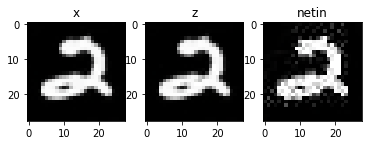

iter = 47: obj_ls = 1.284e+00  |x-z| = 9.531e-03  u_norm = 1.098e-01


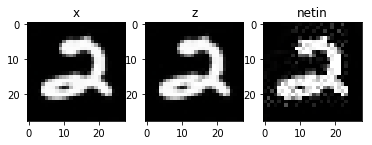

iter = 48: obj_ls = 1.264e+00  |x-z| = 9.558e-03  u_norm = 1.100e-01


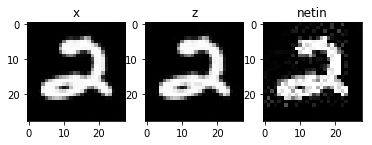

iter = 49: obj_ls = 1.278e+00  |x-z| = 9.559e-03  u_norm = 1.096e-01


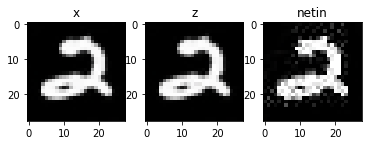

iter = 50: obj_ls = 1.281e+00  |x-z| = 9.583e-03  u_norm = 1.101e-01


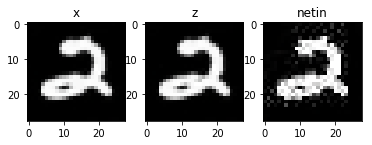

iter = 51: obj_ls = 1.284e+00  |x-z| = 9.402e-03  u_norm = 1.098e-01


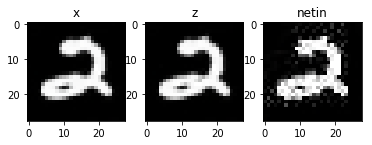

iter = 52: obj_ls = 1.264e+00  |x-z| = 9.427e-03  u_norm = 1.100e-01


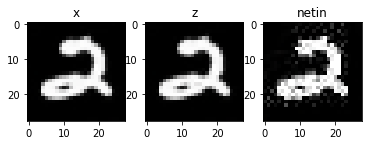

iter = 53: obj_ls = 1.277e+00  |x-z| = 9.421e-03  u_norm = 1.096e-01


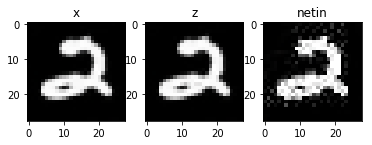

iter = 54: obj_ls = 1.281e+00  |x-z| = 9.448e-03  u_norm = 1.101e-01


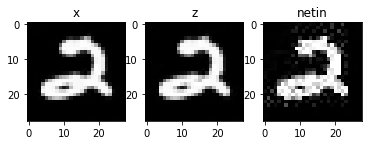

iter = 55: obj_ls = 1.284e+00  |x-z| = 9.278e-03  u_norm = 1.098e-01


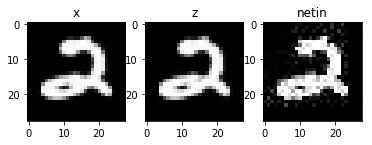

iter = 56: obj_ls = 1.264e+00  |x-z| = 9.302e-03  u_norm = 1.100e-01


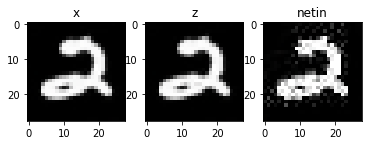

iter = 57: obj_ls = 1.276e+00  |x-z| = 9.289e-03  u_norm = 1.096e-01


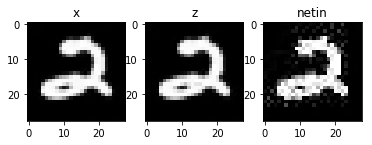

iter = 58: obj_ls = 1.281e+00  |x-z| = 9.319e-03  u_norm = 1.101e-01


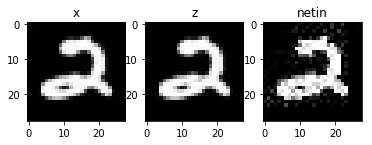

iter = 59: obj_ls = 1.283e+00  |x-z| = 9.158e-03  u_norm = 1.098e-01


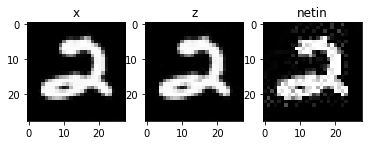

iter = 60: obj_ls = 1.264e+00  |x-z| = 9.181e-03  u_norm = 1.100e-01


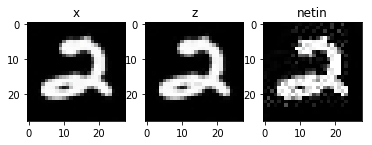

iter = 61: obj_ls = 1.276e+00  |x-z| = 9.163e-03  u_norm = 1.096e-01


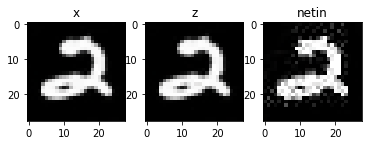

iter = 62: obj_ls = 1.280e+00  |x-z| = 9.193e-03  u_norm = 1.101e-01


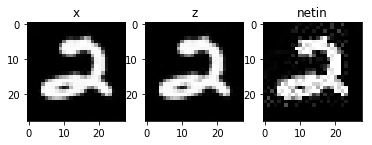

iter = 63: obj_ls = 1.283e+00  |x-z| = 9.040e-03  u_norm = 1.098e-01


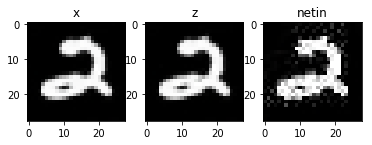

iter = 64: obj_ls = 1.264e+00  |x-z| = 9.062e-03  u_norm = 1.100e-01


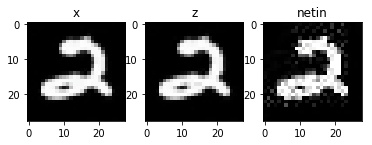

iter = 65: obj_ls = 1.276e+00  |x-z| = 9.041e-03  u_norm = 1.096e-01


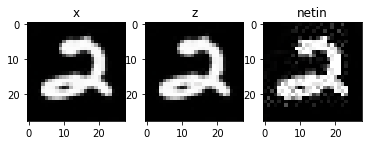

iter = 66: obj_ls = 1.280e+00  |x-z| = 9.072e-03  u_norm = 1.101e-01


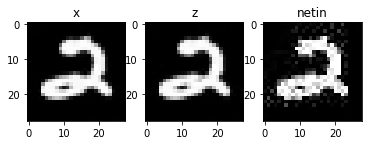

iter = 67: obj_ls = 1.283e+00  |x-z| = 8.925e-03  u_norm = 1.098e-01


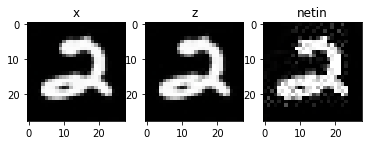

iter = 68: obj_ls = 1.265e+00  |x-z| = 8.946e-03  u_norm = 1.100e-01


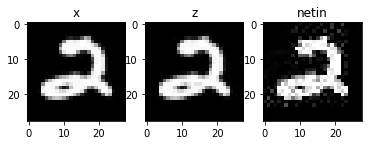

iter = 69: obj_ls = 1.275e+00  |x-z| = 8.922e-03  u_norm = 1.096e-01


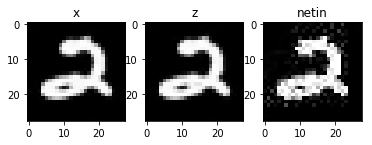

iter = 70: obj_ls = 1.280e+00  |x-z| = 8.953e-03  u_norm = 1.100e-01


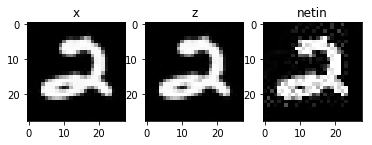

iter = 71: obj_ls = 1.283e+00  |x-z| = 8.811e-03  u_norm = 1.098e-01


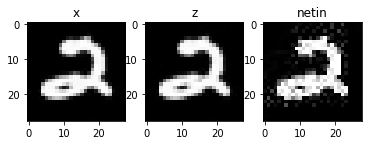

iter = 72: obj_ls = 1.265e+00  |x-z| = 8.832e-03  u_norm = 1.100e-01


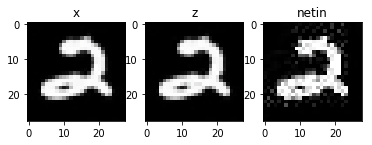

iter = 73: obj_ls = 1.275e+00  |x-z| = 8.807e-03  u_norm = 1.096e-01


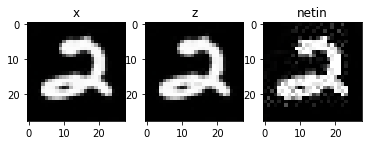

iter = 74: obj_ls = 1.280e+00  |x-z| = 8.838e-03  u_norm = 1.100e-01


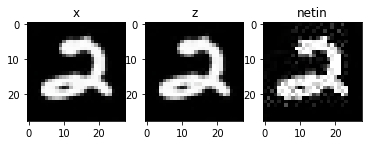

iter = 75: obj_ls = 1.282e+00  |x-z| = 8.722e-03  u_norm = 1.112e-01


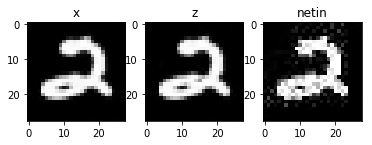

iter = 76: obj_ls = 1.287e+00  |x-z| = 1.730e-02  u_norm = 1.099e-01


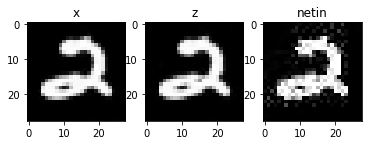

iter = 77: obj_ls = 1.269e+00  |x-z| = 1.743e-02  u_norm = 1.110e-01


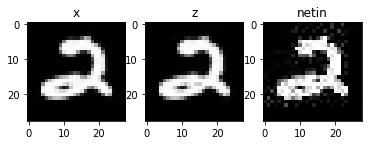

iter = 78: obj_ls = 1.327e+00  |x-z| = 1.769e-02  u_norm = 1.099e-01


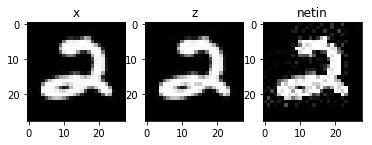

iter = 79: obj_ls = 1.296e+00  |x-z| = 1.732e-02  u_norm = 1.112e-01


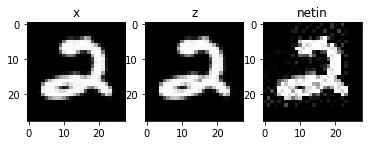

iter = 80: obj_ls = 1.304e+00  |x-z| = 1.677e-02  u_norm = 1.101e-01


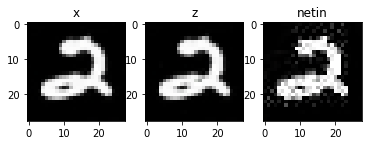

iter = 81: obj_ls = 1.266e+00  |x-z| = 1.666e-02  u_norm = 1.110e-01


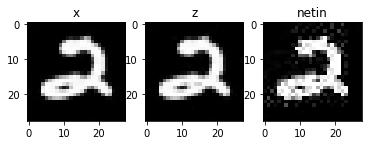

iter = 82: obj_ls = 1.319e+00  |x-z| = 1.685e-02  u_norm = 1.100e-01


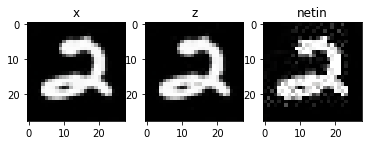

iter = 83: obj_ls = 1.294e+00  |x-z| = 1.664e-02  u_norm = 1.111e-01


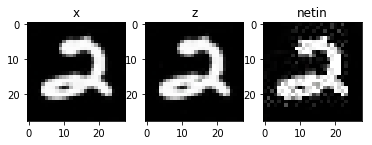

iter = 84: obj_ls = 1.302e+00  |x-z| = 1.612e-02  u_norm = 1.101e-01


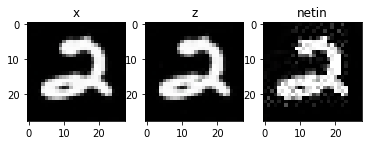

iter = 85: obj_ls = 1.265e+00  |x-z| = 1.605e-02  u_norm = 1.109e-01


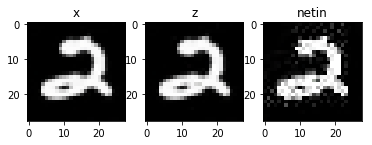

iter = 86: obj_ls = 1.312e+00  |x-z| = 1.619e-02  u_norm = 1.100e-01


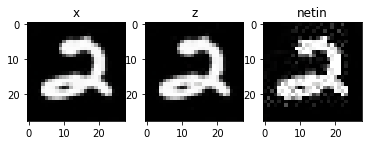

iter = 87: obj_ls = 1.292e+00  |x-z| = 1.604e-02  u_norm = 1.110e-01


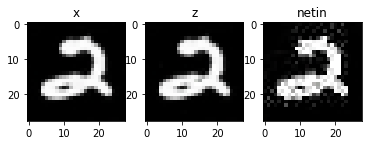

iter = 88: obj_ls = 1.300e+00  |x-z| = 1.557e-02  u_norm = 1.101e-01


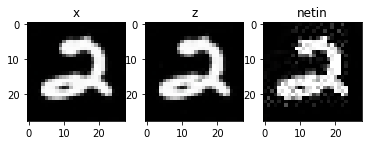

iter = 89: obj_ls = 1.265e+00  |x-z| = 1.552e-02  u_norm = 1.108e-01


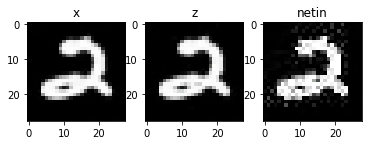

iter = 90: obj_ls = 1.307e+00  |x-z| = 1.563e-02  u_norm = 1.099e-01


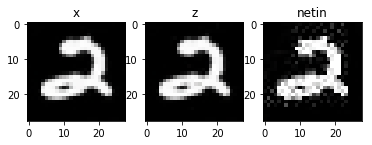

iter = 91: obj_ls = 1.291e+00  |x-z| = 1.552e-02  u_norm = 1.109e-01


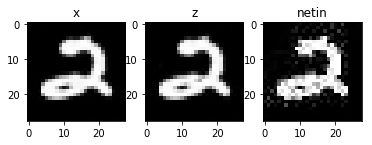

iter = 92: obj_ls = 1.299e+00  |x-z| = 1.510e-02  u_norm = 1.101e-01


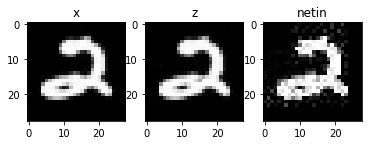

iter = 93: obj_ls = 1.265e+00  |x-z| = 1.505e-02  u_norm = 1.108e-01


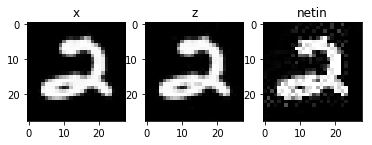

iter = 94: obj_ls = 1.303e+00  |x-z| = 1.515e-02  u_norm = 1.099e-01


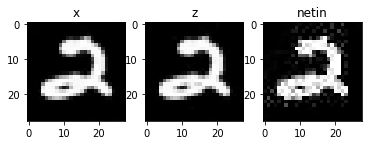

iter = 95: obj_ls = 1.289e+00  |x-z| = 1.506e-02  u_norm = 1.108e-01


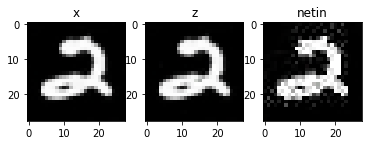

iter = 96: obj_ls = 1.297e+00  |x-z| = 1.467e-02  u_norm = 1.100e-01


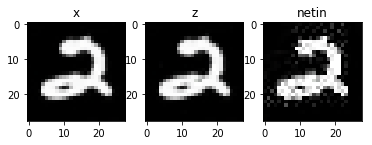

iter = 97: obj_ls = 1.265e+00  |x-z| = 1.463e-02  u_norm = 1.107e-01


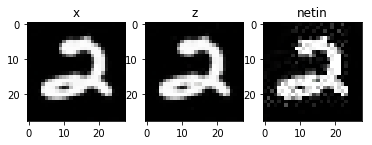

iter = 98: obj_ls = 1.300e+00  |x-z| = 1.471e-02  u_norm = 1.099e-01


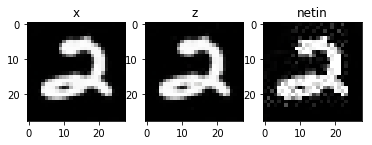

iter = 99: obj_ls = 1.289e+00  |x-z| = 1.465e-02  u_norm = 1.108e-01


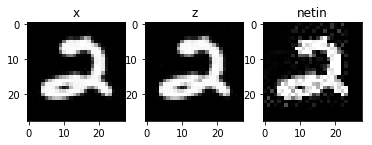

iter = 100: obj_ls = 1.296e+00  |x-z| = 1.428e-02  u_norm = 1.100e-01


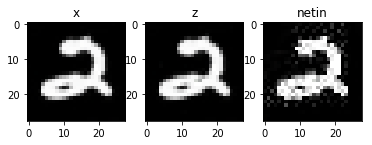

iter = 101: obj_ls = 1.265e+00  |x-z| = 1.426e-02  u_norm = 1.106e-01


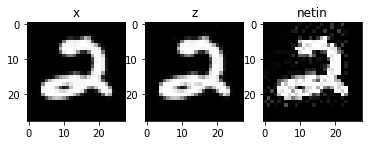

iter = 102: obj_ls = 1.297e+00  |x-z| = 1.432e-02  u_norm = 1.098e-01


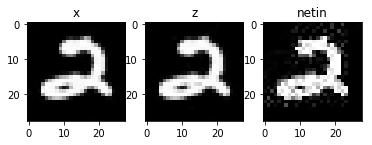

iter = 103: obj_ls = 1.288e+00  |x-z| = 1.427e-02  u_norm = 1.107e-01


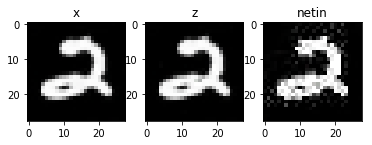

iter = 104: obj_ls = 1.295e+00  |x-z| = 1.393e-02  u_norm = 1.100e-01


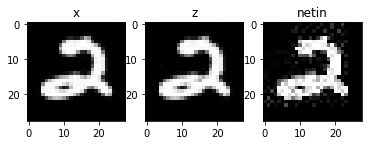

iter = 105: obj_ls = 1.265e+00  |x-z| = 1.391e-02  u_norm = 1.106e-01


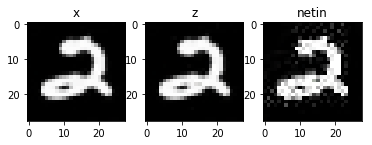

iter = 106: obj_ls = 1.295e+00  |x-z| = 1.397e-02  u_norm = 1.098e-01


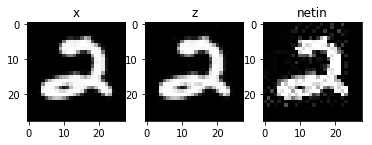

iter = 107: obj_ls = 1.287e+00  |x-z| = 1.393e-02  u_norm = 1.107e-01


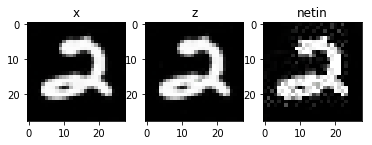

iter = 108: obj_ls = 1.294e+00  |x-z| = 1.361e-02  u_norm = 1.100e-01


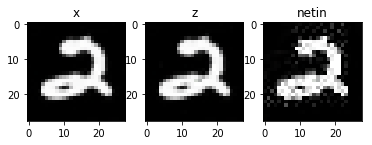

iter = 109: obj_ls = 1.264e+00  |x-z| = 1.359e-02  u_norm = 1.105e-01


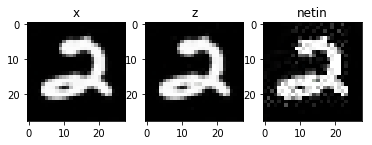

iter = 110: obj_ls = 1.293e+00  |x-z| = 1.364e-02  u_norm = 1.098e-01


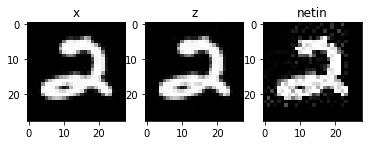

iter = 111: obj_ls = 1.286e+00  |x-z| = 1.361e-02  u_norm = 1.106e-01


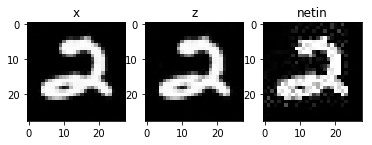

iter = 112: obj_ls = 1.293e+00  |x-z| = 1.331e-02  u_norm = 1.100e-01


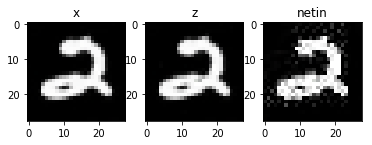

iter = 113: obj_ls = 1.264e+00  |x-z| = 1.330e-02  u_norm = 1.105e-01


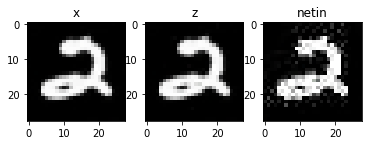

iter = 114: obj_ls = 1.291e+00  |x-z| = 1.334e-02  u_norm = 1.098e-01


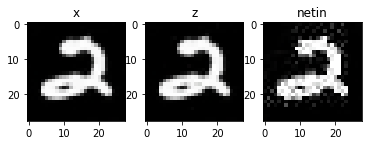

iter = 115: obj_ls = 1.286e+00  |x-z| = 1.332e-02  u_norm = 1.106e-01


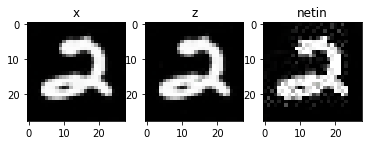

iter = 116: obj_ls = 1.292e+00  |x-z| = 1.304e-02  u_norm = 1.100e-01


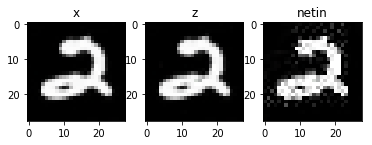

iter = 117: obj_ls = 1.264e+00  |x-z| = 1.303e-02  u_norm = 1.105e-01


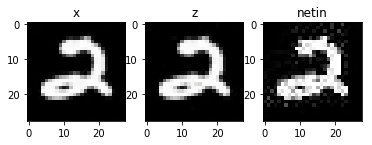

iter = 118: obj_ls = 1.290e+00  |x-z| = 1.306e-02  u_norm = 1.098e-01


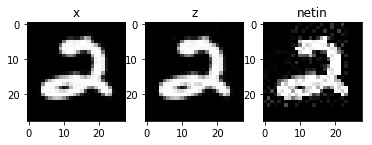

iter = 119: obj_ls = 1.285e+00  |x-z| = 1.305e-02  u_norm = 1.105e-01


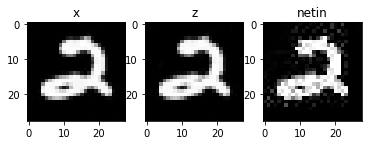

iter = 120: obj_ls = 1.292e+00  |x-z| = 1.278e-02  u_norm = 1.099e-01


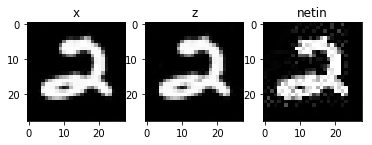

iter = 121: obj_ls = 1.264e+00  |x-z| = 1.278e-02  u_norm = 1.104e-01


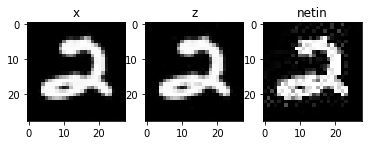

iter = 122: obj_ls = 1.288e+00  |x-z| = 1.280e-02  u_norm = 1.098e-01


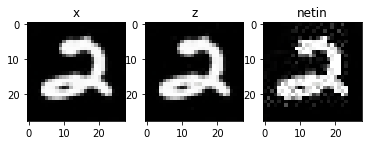

iter = 123: obj_ls = 1.285e+00  |x-z| = 1.279e-02  u_norm = 1.105e-01


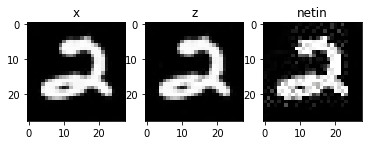

iter = 124: obj_ls = 1.291e+00  |x-z| = 1.254e-02  u_norm = 1.099e-01


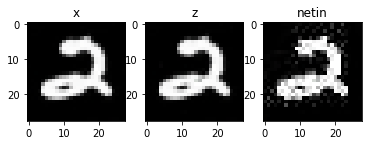

iter = 125: obj_ls = 1.264e+00  |x-z| = 1.254e-02  u_norm = 1.104e-01


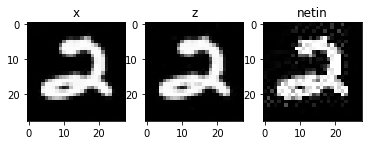

iter = 126: obj_ls = 1.287e+00  |x-z| = 1.255e-02  u_norm = 1.098e-01


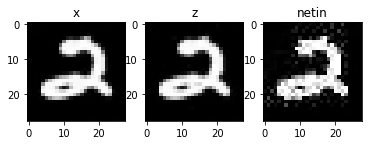

iter = 127: obj_ls = 1.284e+00  |x-z| = 1.255e-02  u_norm = 1.105e-01


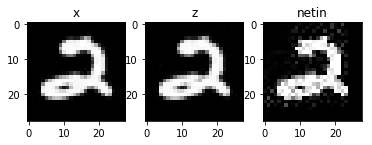

iter = 128: obj_ls = 1.290e+00  |x-z| = 1.231e-02  u_norm = 1.099e-01


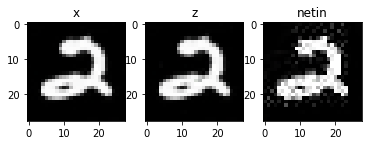

iter = 129: obj_ls = 1.264e+00  |x-z| = 1.231e-02  u_norm = 1.104e-01


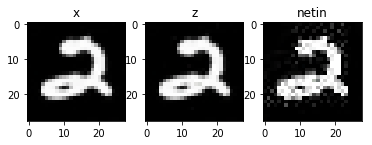

iter = 130: obj_ls = 1.286e+00  |x-z| = 1.232e-02  u_norm = 1.097e-01


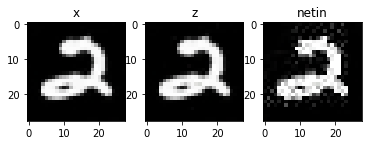

iter = 131: obj_ls = 1.284e+00  |x-z| = 1.233e-02  u_norm = 1.104e-01


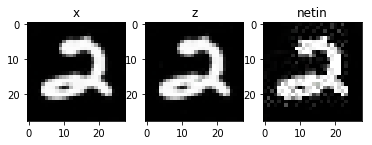

iter = 132: obj_ls = 1.290e+00  |x-z| = 1.210e-02  u_norm = 1.099e-01


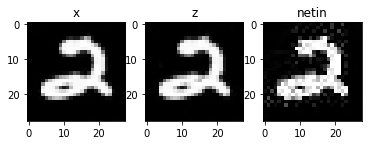

iter = 133: obj_ls = 1.264e+00  |x-z| = 1.210e-02  u_norm = 1.103e-01


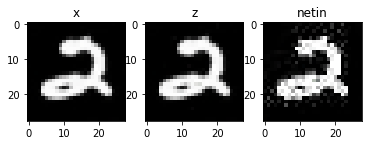

iter = 134: obj_ls = 1.285e+00  |x-z| = 1.211e-02  u_norm = 1.097e-01


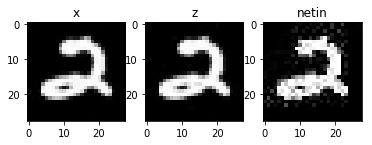

iter = 135: obj_ls = 1.284e+00  |x-z| = 1.211e-02  u_norm = 1.104e-01


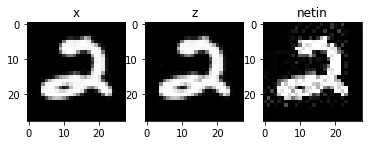

iter = 136: obj_ls = 1.289e+00  |x-z| = 1.189e-02  u_norm = 1.099e-01


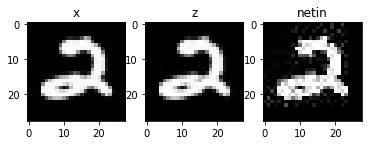

iter = 137: obj_ls = 1.264e+00  |x-z| = 1.190e-02  u_norm = 1.103e-01


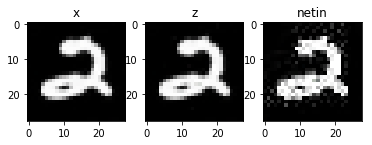

iter = 138: obj_ls = 1.284e+00  |x-z| = 1.190e-02  u_norm = 1.097e-01


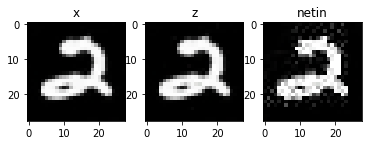

iter = 139: obj_ls = 1.283e+00  |x-z| = 1.191e-02  u_norm = 1.104e-01


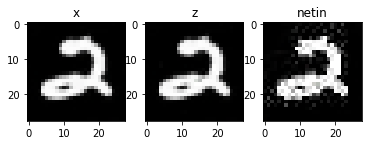

iter = 140: obj_ls = 1.289e+00  |x-z| = 1.170e-02  u_norm = 1.099e-01


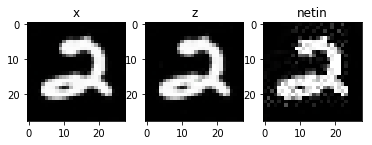

iter = 141: obj_ls = 1.264e+00  |x-z| = 1.171e-02  u_norm = 1.103e-01


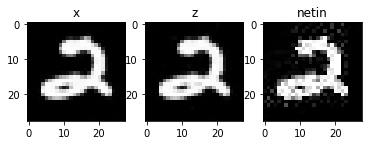

iter = 142: obj_ls = 1.283e+00  |x-z| = 1.171e-02  u_norm = 1.097e-01


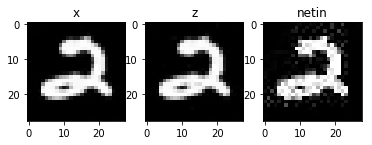

iter = 143: obj_ls = 1.283e+00  |x-z| = 1.172e-02  u_norm = 1.104e-01


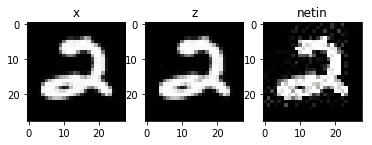

iter = 144: obj_ls = 1.288e+00  |x-z| = 1.152e-02  u_norm = 1.099e-01


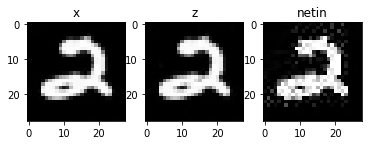

iter = 145: obj_ls = 1.264e+00  |x-z| = 1.152e-02  u_norm = 1.103e-01


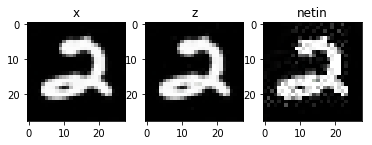

iter = 146: obj_ls = 1.282e+00  |x-z| = 1.152e-02  u_norm = 1.097e-01


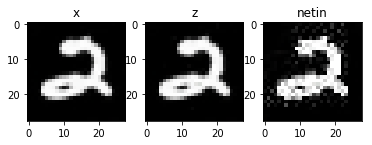

iter = 147: obj_ls = 1.283e+00  |x-z| = 1.153e-02  u_norm = 1.103e-01


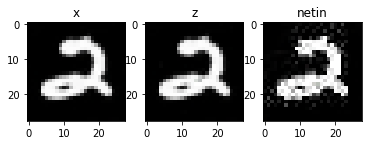

iter = 148: obj_ls = 1.288e+00  |x-z| = 1.134e-02  u_norm = 1.099e-01


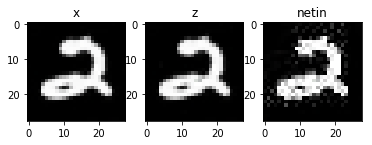

iter = 149: obj_ls = 1.264e+00  |x-z| = 1.135e-02  u_norm = 1.102e-01


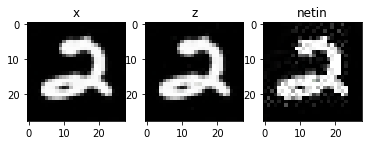

iter = 150: obj_ls = 1.282e+00  |x-z| = 1.134e-02  u_norm = 1.097e-01


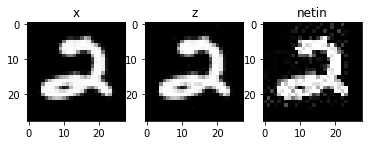

iter = 151: obj_ls = 1.282e+00  |x-z| = 1.136e-02  u_norm = 1.103e-01


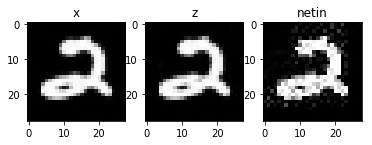

iter = 152: obj_ls = 1.288e+00  |x-z| = 1.117e-02  u_norm = 1.099e-01


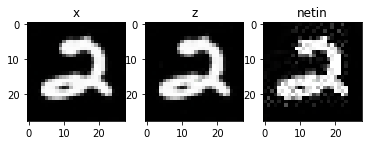

iter = 153: obj_ls = 1.265e+00  |x-z| = 1.118e-02  u_norm = 1.102e-01


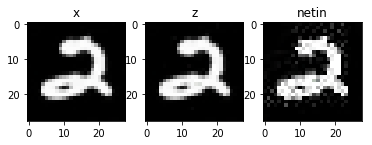

iter = 154: obj_ls = 1.281e+00  |x-z| = 1.117e-02  u_norm = 1.097e-01


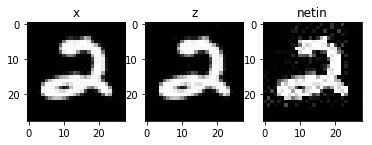

iter = 155: obj_ls = 1.282e+00  |x-z| = 1.119e-02  u_norm = 1.103e-01


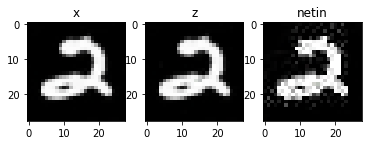

iter = 156: obj_ls = 1.287e+00  |x-z| = 1.101e-02  u_norm = 1.099e-01


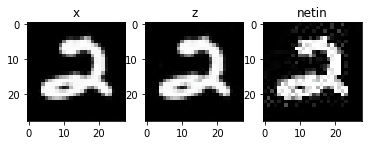

iter = 157: obj_ls = 1.265e+00  |x-z| = 1.102e-02  u_norm = 1.102e-01


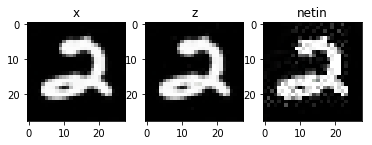

iter = 158: obj_ls = 1.280e+00  |x-z| = 1.101e-02  u_norm = 1.097e-01


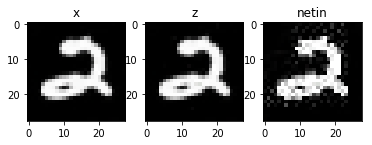

iter = 159: obj_ls = 1.282e+00  |x-z| = 1.103e-02  u_norm = 1.103e-01


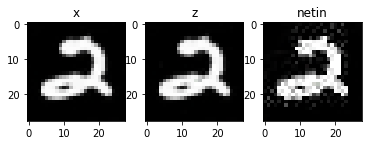

iter = 160: obj_ls = 1.287e+00  |x-z| = 1.086e-02  u_norm = 1.099e-01


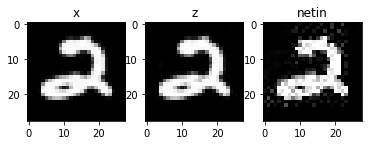

iter = 161: obj_ls = 1.265e+00  |x-z| = 1.087e-02  u_norm = 1.102e-01


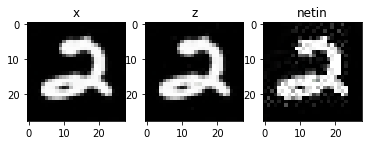

iter = 162: obj_ls = 1.280e+00  |x-z| = 1.086e-02  u_norm = 1.097e-01


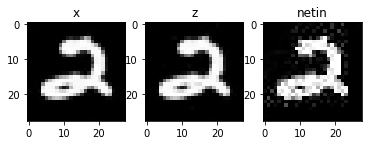

iter = 163: obj_ls = 1.281e+00  |x-z| = 1.088e-02  u_norm = 1.103e-01


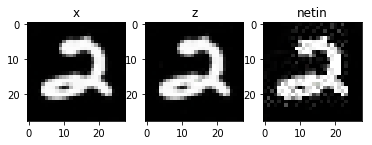

iter = 164: obj_ls = 1.286e+00  |x-z| = 1.071e-02  u_norm = 1.098e-01


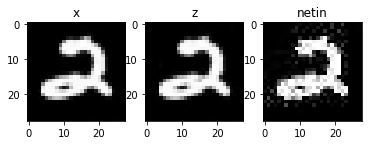

iter = 165: obj_ls = 1.265e+00  |x-z| = 1.073e-02  u_norm = 1.102e-01


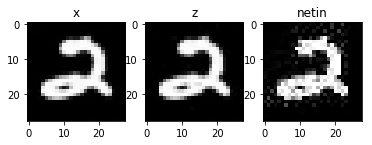

iter = 166: obj_ls = 1.279e+00  |x-z| = 1.071e-02  u_norm = 1.097e-01


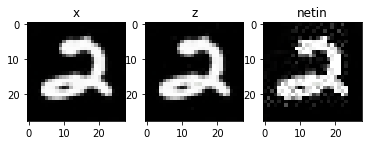

iter = 167: obj_ls = 1.281e+00  |x-z| = 1.073e-02  u_norm = 1.102e-01


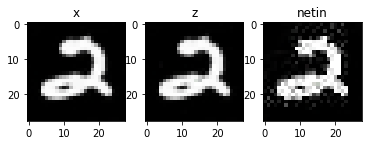

iter = 168: obj_ls = 1.286e+00  |x-z| = 1.057e-02  u_norm = 1.098e-01


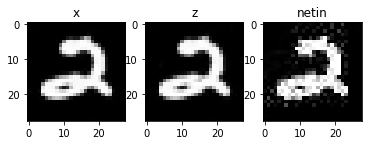

iter = 169: obj_ls = 1.265e+00  |x-z| = 1.058e-02  u_norm = 1.101e-01


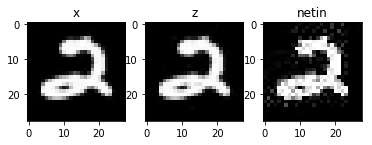

iter = 170: obj_ls = 1.279e+00  |x-z| = 1.057e-02  u_norm = 1.097e-01


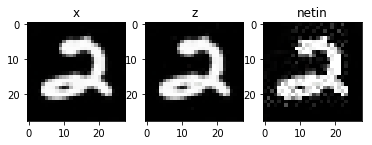

iter = 171: obj_ls = 1.281e+00  |x-z| = 1.059e-02  u_norm = 1.102e-01


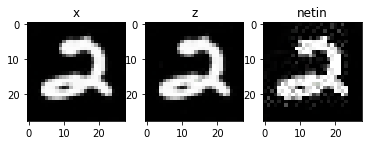

iter = 172: obj_ls = 1.286e+00  |x-z| = 1.044e-02  u_norm = 1.098e-01


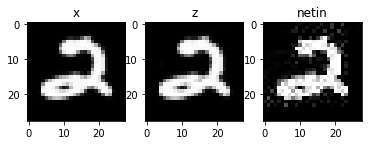

iter = 173: obj_ls = 1.265e+00  |x-z| = 1.045e-02  u_norm = 1.101e-01


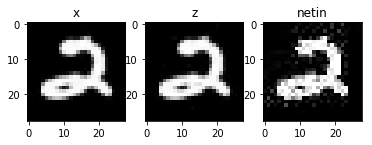

iter = 174: obj_ls = 1.278e+00  |x-z| = 1.043e-02  u_norm = 1.097e-01


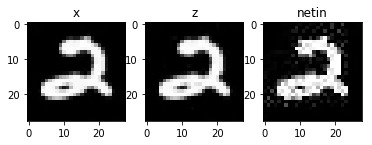

iter = 175: obj_ls = 1.281e+00  |x-z| = 1.046e-02  u_norm = 1.102e-01


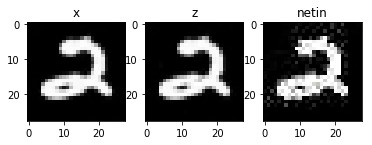

iter = 176: obj_ls = 1.286e+00  |x-z| = 1.031e-02  u_norm = 1.098e-01


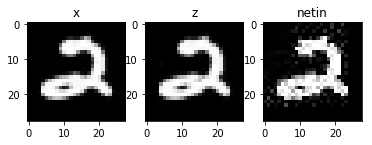

iter = 177: obj_ls = 1.265e+00  |x-z| = 1.032e-02  u_norm = 1.101e-01


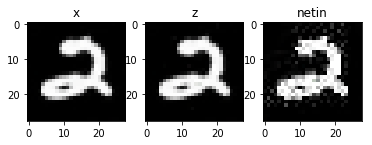

iter = 178: obj_ls = 1.278e+00  |x-z| = 1.030e-02  u_norm = 1.097e-01


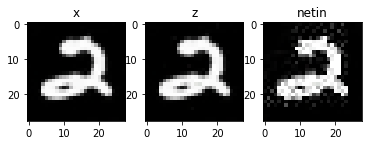

iter = 179: obj_ls = 1.281e+00  |x-z| = 1.032e-02  u_norm = 1.102e-01


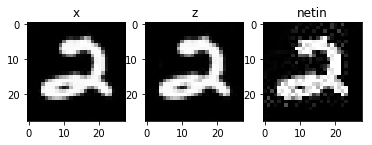

iter = 180: obj_ls = 1.285e+00  |x-z| = 1.018e-02  u_norm = 1.098e-01


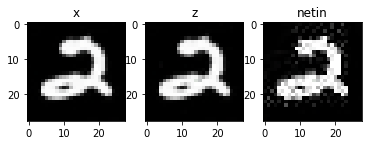

iter = 181: obj_ls = 1.265e+00  |x-z| = 1.019e-02  u_norm = 1.101e-01


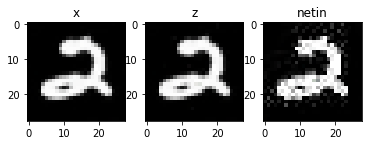

iter = 182: obj_ls = 1.278e+00  |x-z| = 1.017e-02  u_norm = 1.097e-01


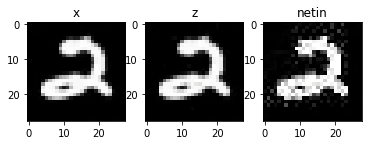

iter = 183: obj_ls = 1.280e+00  |x-z| = 1.020e-02  u_norm = 1.102e-01


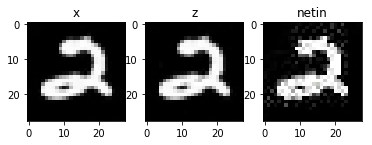

iter = 184: obj_ls = 1.285e+00  |x-z| = 1.006e-02  u_norm = 1.098e-01


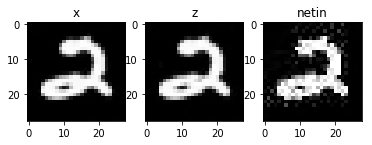

iter = 185: obj_ls = 1.265e+00  |x-z| = 1.007e-02  u_norm = 1.101e-01


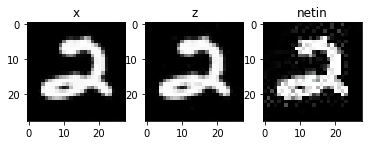

iter = 186: obj_ls = 1.277e+00  |x-z| = 1.005e-02  u_norm = 1.097e-01


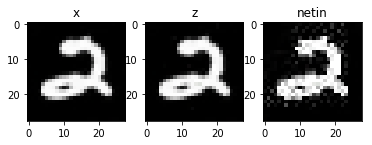

iter = 187: obj_ls = 1.280e+00  |x-z| = 1.008e-02  u_norm = 1.102e-01


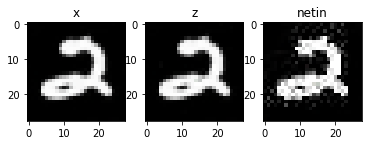

iter = 188: obj_ls = 1.285e+00  |x-z| = 9.942e-03  u_norm = 1.098e-01


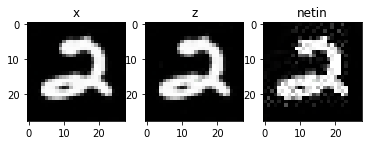

iter = 189: obj_ls = 1.265e+00  |x-z| = 9.958e-03  u_norm = 1.101e-01


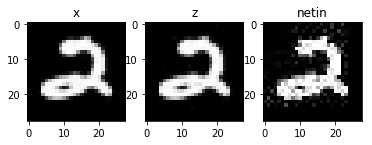

iter = 190: obj_ls = 1.277e+00  |x-z| = 9.935e-03  u_norm = 1.097e-01


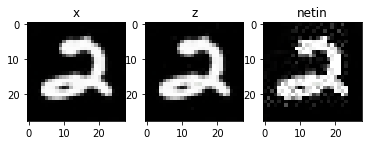

iter = 191: obj_ls = 1.280e+00  |x-z| = 9.961e-03  u_norm = 1.102e-01


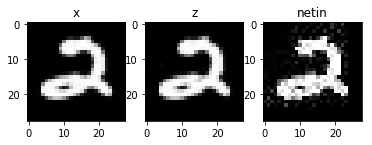

iter = 192: obj_ls = 1.284e+00  |x-z| = 9.830e-03  u_norm = 1.098e-01


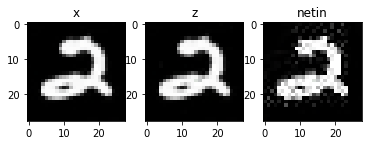

iter = 193: obj_ls = 1.265e+00  |x-z| = 9.845e-03  u_norm = 1.101e-01


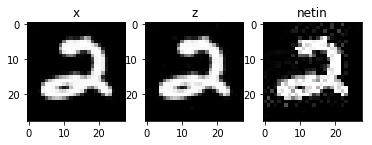

iter = 194: obj_ls = 1.277e+00  |x-z| = 9.822e-03  u_norm = 1.097e-01


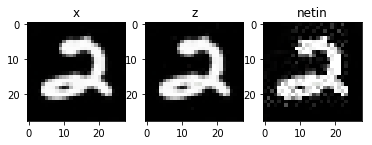

iter = 195: obj_ls = 1.280e+00  |x-z| = 9.848e-03  u_norm = 1.101e-01


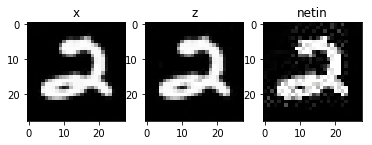

iter = 196: obj_ls = 1.284e+00  |x-z| = 9.721e-03  u_norm = 1.098e-01


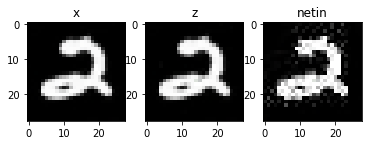

iter = 197: obj_ls = 1.265e+00  |x-z| = 9.737e-03  u_norm = 1.101e-01


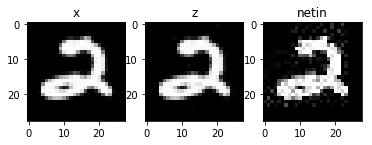

iter = 198: obj_ls = 1.276e+00  |x-z| = 9.712e-03  u_norm = 1.097e-01


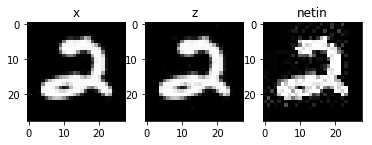

iter = 199: obj_ls = 1.280e+00  |x-z| = 9.739e-03  u_norm = 1.101e-01


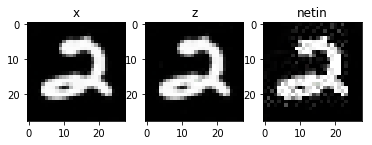

iter = 200: obj_ls = 1.284e+00  |x-z| = 9.616e-03  u_norm = 1.098e-01


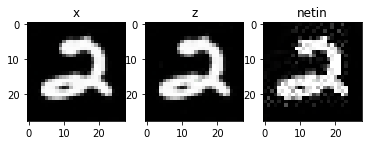

iter = 201: obj_ls = 1.265e+00  |x-z| = 9.632e-03  u_norm = 1.100e-01


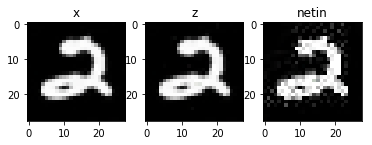

iter = 202: obj_ls = 1.276e+00  |x-z| = 9.607e-03  u_norm = 1.097e-01


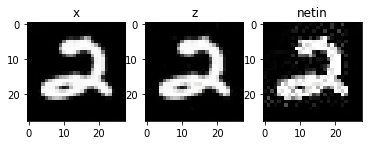

iter = 203: obj_ls = 1.279e+00  |x-z| = 9.634e-03  u_norm = 1.101e-01


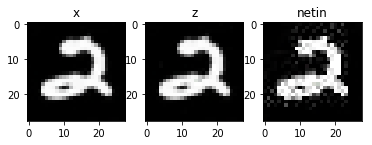

iter = 204: obj_ls = 1.284e+00  |x-z| = 9.514e-03  u_norm = 1.098e-01


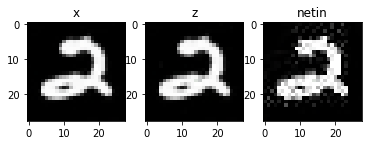

iter = 205: obj_ls = 1.265e+00  |x-z| = 9.531e-03  u_norm = 1.100e-01


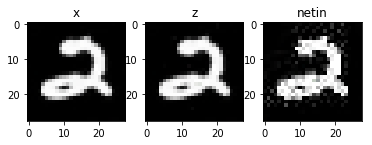

iter = 206: obj_ls = 1.276e+00  |x-z| = 9.505e-03  u_norm = 1.096e-01


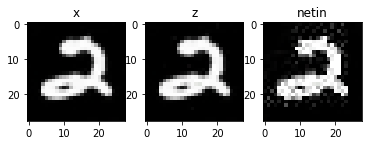

iter = 207: obj_ls = 1.279e+00  |x-z| = 9.532e-03  u_norm = 1.101e-01


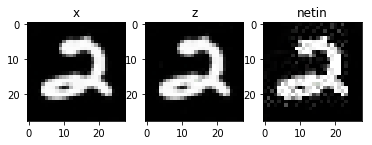

iter = 208: obj_ls = 1.284e+00  |x-z| = 9.416e-03  u_norm = 1.098e-01


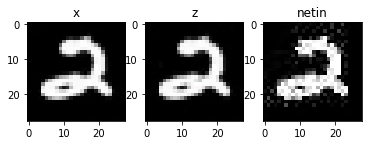

iter = 209: obj_ls = 1.265e+00  |x-z| = 9.433e-03  u_norm = 1.100e-01


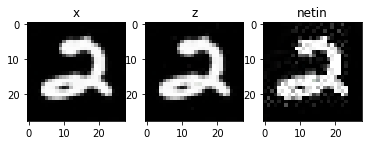

iter = 210: obj_ls = 1.276e+00  |x-z| = 9.406e-03  u_norm = 1.096e-01


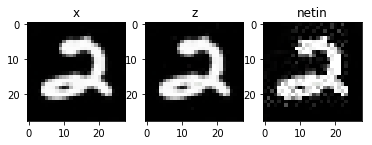

iter = 211: obj_ls = 1.279e+00  |x-z| = 9.434e-03  u_norm = 1.101e-01


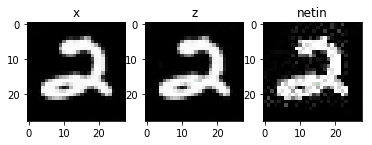

iter = 212: obj_ls = 1.283e+00  |x-z| = 9.321e-03  u_norm = 1.098e-01


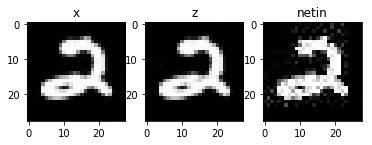

iter = 213: obj_ls = 1.265e+00  |x-z| = 9.338e-03  u_norm = 1.100e-01


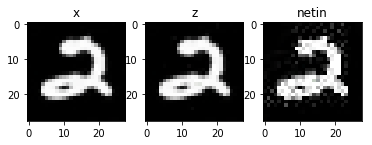

iter = 214: obj_ls = 1.275e+00  |x-z| = 9.311e-03  u_norm = 1.096e-01


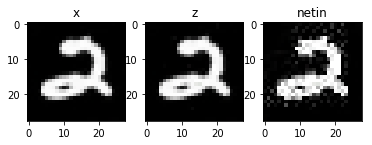

iter = 215: obj_ls = 1.279e+00  |x-z| = 9.339e-03  u_norm = 1.101e-01


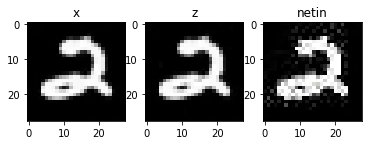

iter = 216: obj_ls = 1.283e+00  |x-z| = 9.229e-03  u_norm = 1.098e-01


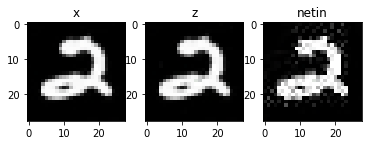

iter = 217: obj_ls = 1.265e+00  |x-z| = 9.246e-03  u_norm = 1.100e-01


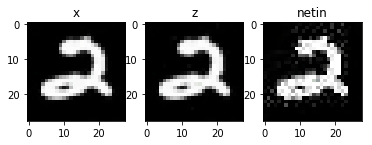

iter = 218: obj_ls = 1.275e+00  |x-z| = 9.219e-03  u_norm = 1.096e-01


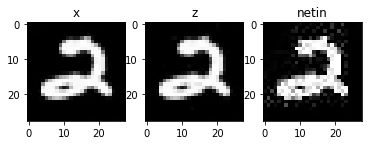

iter = 219: obj_ls = 1.279e+00  |x-z| = 9.247e-03  u_norm = 1.101e-01


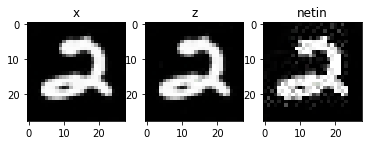

iter = 220: obj_ls = 1.283e+00  |x-z| = 9.140e-03  u_norm = 1.098e-01


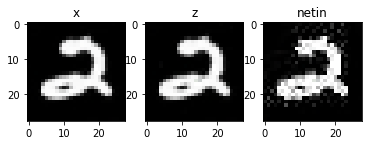

iter = 221: obj_ls = 1.265e+00  |x-z| = 9.157e-03  u_norm = 1.100e-01


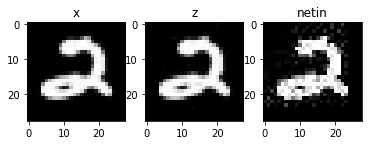

iter = 222: obj_ls = 1.275e+00  |x-z| = 9.130e-03  u_norm = 1.096e-01


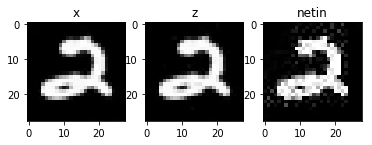

iter = 223: obj_ls = 1.279e+00  |x-z| = 9.158e-03  u_norm = 1.101e-01


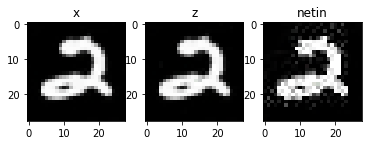

iter = 224: obj_ls = 1.283e+00  |x-z| = 9.054e-03  u_norm = 1.098e-01


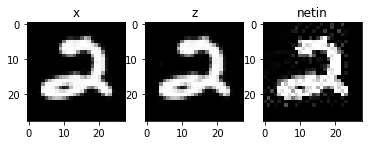

iter = 225: obj_ls = 1.265e+00  |x-z| = 9.071e-03  u_norm = 1.100e-01


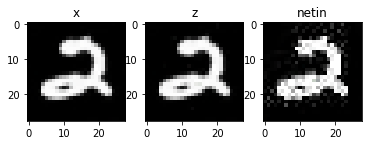

iter = 226: obj_ls = 1.275e+00  |x-z| = 9.043e-03  u_norm = 1.096e-01


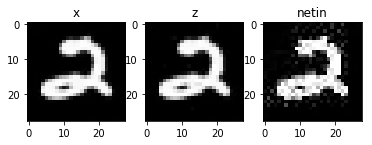

iter = 227: obj_ls = 1.279e+00  |x-z| = 9.071e-03  u_norm = 1.101e-01


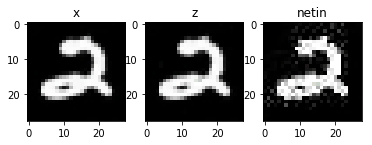

iter = 228: obj_ls = 1.283e+00  |x-z| = 8.971e-03  u_norm = 1.098e-01


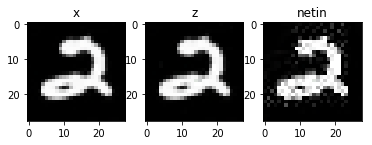

iter = 229: obj_ls = 1.265e+00  |x-z| = 8.988e-03  u_norm = 1.100e-01


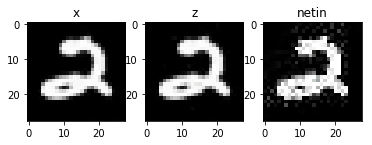

iter = 230: obj_ls = 1.275e+00  |x-z| = 8.960e-03  u_norm = 1.096e-01


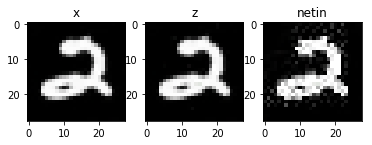

iter = 231: obj_ls = 1.278e+00  |x-z| = 8.988e-03  u_norm = 1.100e-01


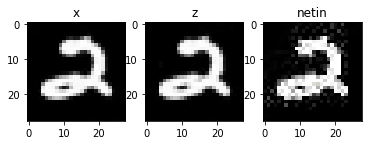

iter = 232: obj_ls = 1.282e+00  |x-z| = 8.890e-03  u_norm = 1.098e-01


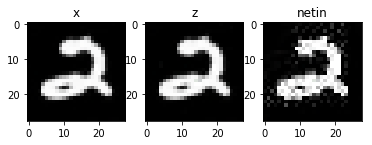

iter = 233: obj_ls = 1.265e+00  |x-z| = 8.907e-03  u_norm = 1.100e-01


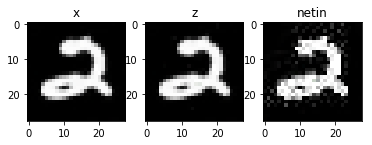

iter = 234: obj_ls = 1.274e+00  |x-z| = 8.879e-03  u_norm = 1.096e-01


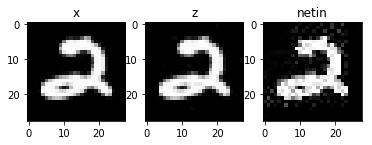

iter = 235: obj_ls = 1.278e+00  |x-z| = 8.907e-03  u_norm = 1.100e-01


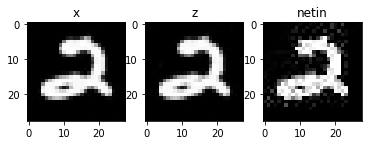

iter = 236: obj_ls = 1.282e+00  |x-z| = 8.812e-03  u_norm = 1.098e-01


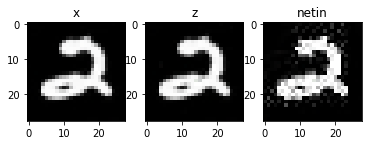

iter = 237: obj_ls = 1.265e+00  |x-z| = 8.829e-03  u_norm = 1.100e-01


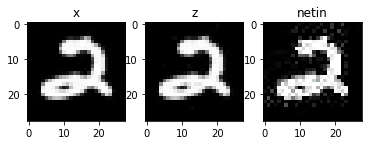

iter = 238: obj_ls = 1.274e+00  |x-z| = 8.800e-03  u_norm = 1.096e-01


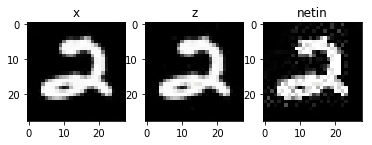

iter = 239: obj_ls = 1.278e+00  |x-z| = 8.828e-03  u_norm = 1.100e-01


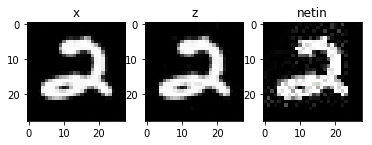

iter = 240: obj_ls = 1.282e+00  |x-z| = 8.756e-03  u_norm = 1.112e-01


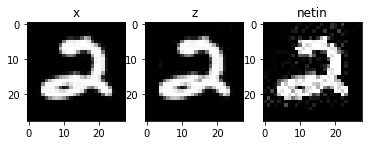

iter = 241: obj_ls = 1.287e+00  |x-z| = 1.740e-02  u_norm = 1.099e-01


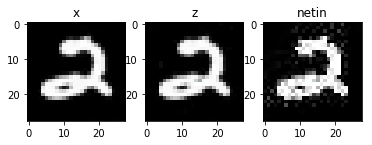

iter = 242: obj_ls = 1.268e+00  |x-z| = 1.750e-02  u_norm = 1.111e-01


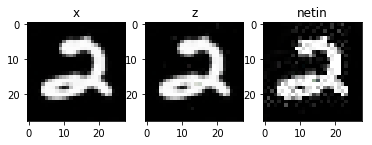

iter = 243: obj_ls = 1.312e+00  |x-z| = 1.764e-02  u_norm = 1.099e-01


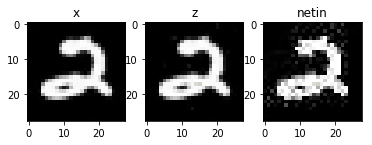

iter = 244: obj_ls = 1.290e+00  |x-z| = 1.748e-02  u_norm = 1.112e-01


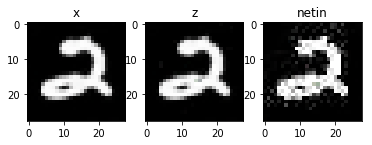

iter = 245: obj_ls = 1.305e+00  |x-z| = 1.715e-02  u_norm = 1.101e-01


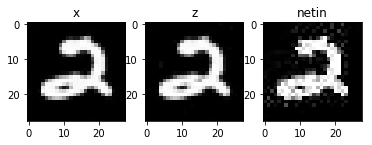

iter = 246: obj_ls = 1.266e+00  |x-z| = 1.711e-02  u_norm = 1.111e-01


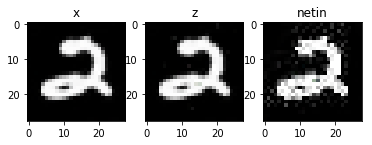

iter = 247: obj_ls = 1.308e+00  |x-z| = 1.720e-02  u_norm = 1.100e-01


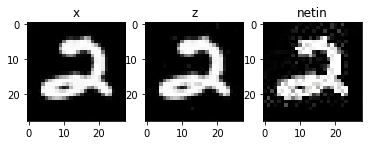

iter = 248: obj_ls = 1.289e+00  |x-z| = 1.712e-02  u_norm = 1.112e-01


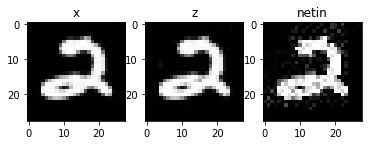

iter = 249: obj_ls = 1.303e+00  |x-z| = 1.680e-02  u_norm = 1.101e-01


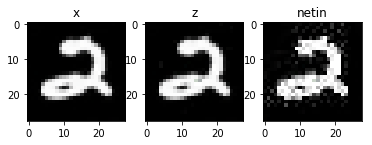

iter = 250: obj_ls = 1.265e+00  |x-z| = 1.676e-02  u_norm = 1.111e-01


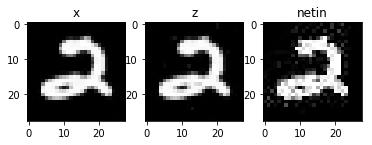

iter = 251: obj_ls = 1.305e+00  |x-z| = 1.683e-02  u_norm = 1.100e-01


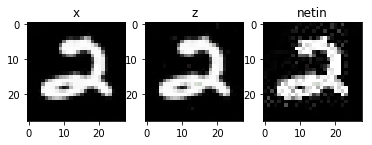

iter = 252: obj_ls = 1.288e+00  |x-z| = 1.678e-02  u_norm = 1.112e-01


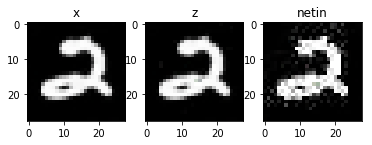

iter = 253: obj_ls = 1.302e+00  |x-z| = 1.648e-02  u_norm = 1.101e-01


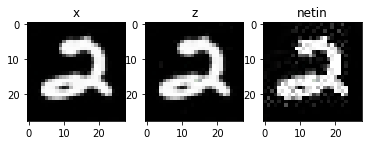

iter = 254: obj_ls = 1.265e+00  |x-z| = 1.646e-02  u_norm = 1.110e-01


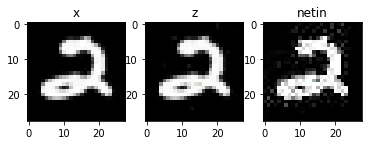

iter = 255: obj_ls = 1.302e+00  |x-z| = 1.652e-02  u_norm = 1.100e-01


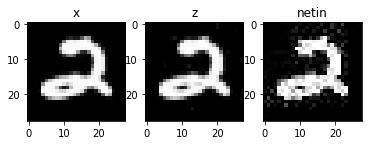

iter = 256: obj_ls = 1.287e+00  |x-z| = 1.648e-02  u_norm = 1.111e-01


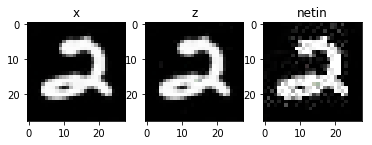

iter = 257: obj_ls = 1.301e+00  |x-z| = 1.620e-02  u_norm = 1.101e-01


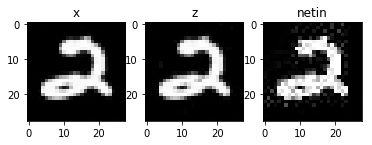

iter = 258: obj_ls = 1.265e+00  |x-z| = 1.619e-02  u_norm = 1.110e-01


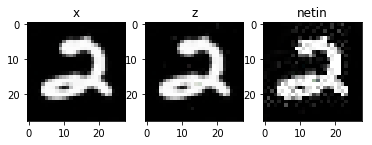

iter = 259: obj_ls = 1.300e+00  |x-z| = 1.623e-02  u_norm = 1.099e-01


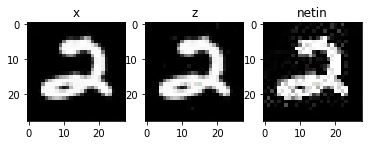

iter = 260: obj_ls = 1.286e+00  |x-z| = 1.621e-02  u_norm = 1.111e-01


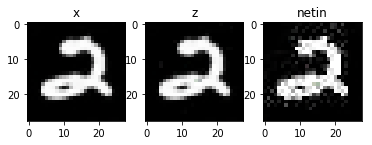

iter = 261: obj_ls = 1.300e+00  |x-z| = 1.595e-02  u_norm = 1.101e-01


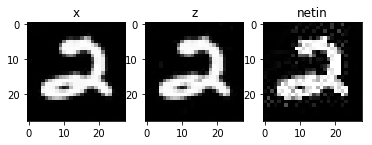

iter = 262: obj_ls = 1.265e+00  |x-z| = 1.594e-02  u_norm = 1.109e-01


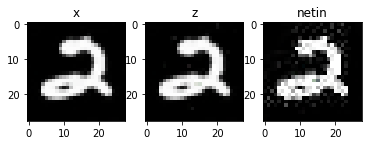

iter = 263: obj_ls = 1.298e+00  |x-z| = 1.598e-02  u_norm = 1.099e-01


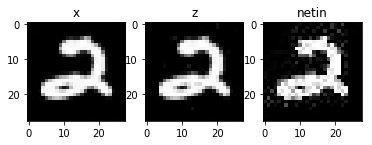

iter = 264: obj_ls = 1.286e+00  |x-z| = 1.596e-02  u_norm = 1.110e-01


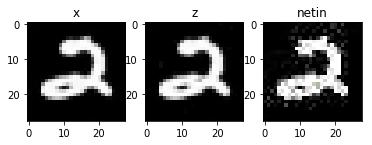

iter = 265: obj_ls = 1.300e+00  |x-z| = 1.572e-02  u_norm = 1.101e-01


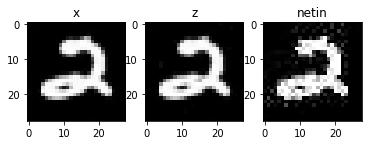

iter = 266: obj_ls = 1.265e+00  |x-z| = 1.572e-02  u_norm = 1.109e-01


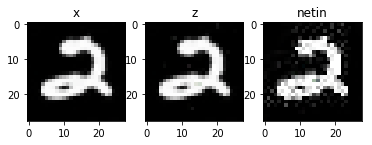

iter = 267: obj_ls = 1.296e+00  |x-z| = 1.575e-02  u_norm = 1.099e-01


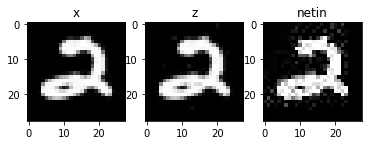

iter = 268: obj_ls = 1.285e+00  |x-z| = 1.574e-02  u_norm = 1.110e-01


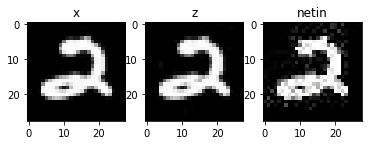

iter = 269: obj_ls = 1.299e+00  |x-z| = 1.551e-02  u_norm = 1.101e-01


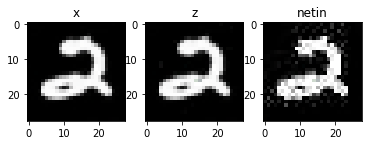

iter = 270: obj_ls = 1.265e+00  |x-z| = 1.551e-02  u_norm = 1.109e-01


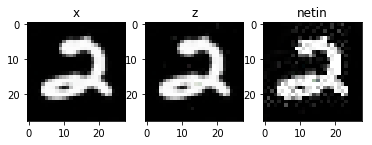

iter = 271: obj_ls = 1.295e+00  |x-z| = 1.553e-02  u_norm = 1.099e-01


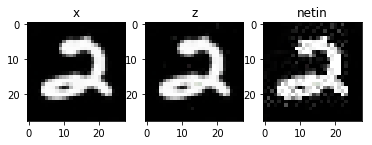

iter = 272: obj_ls = 1.284e+00  |x-z| = 1.553e-02  u_norm = 1.109e-01


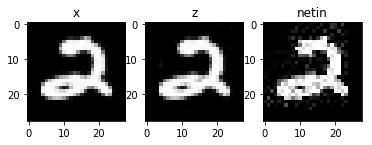

iter = 273: obj_ls = 1.298e+00  |x-z| = 1.532e-02  u_norm = 1.101e-01


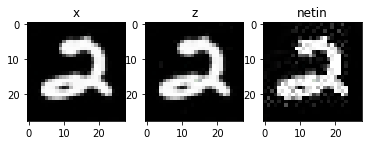

iter = 274: obj_ls = 1.265e+00  |x-z| = 1.532e-02  u_norm = 1.108e-01


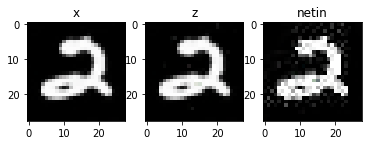

iter = 275: obj_ls = 1.293e+00  |x-z| = 1.534e-02  u_norm = 1.099e-01


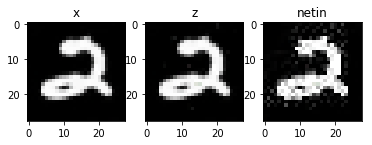

iter = 276: obj_ls = 1.284e+00  |x-z| = 1.534e-02  u_norm = 1.109e-01


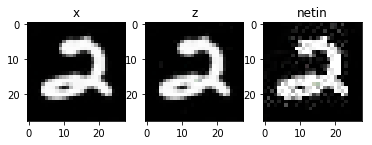

iter = 277: obj_ls = 1.298e+00  |x-z| = 1.514e-02  u_norm = 1.100e-01


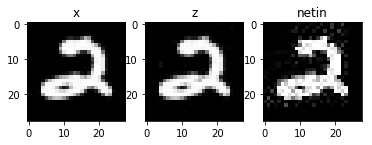

iter = 278: obj_ls = 1.265e+00  |x-z| = 1.515e-02  u_norm = 1.108e-01


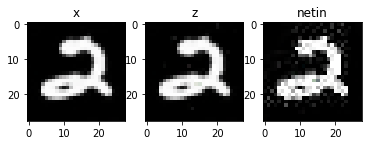

iter = 279: obj_ls = 1.292e+00  |x-z| = 1.516e-02  u_norm = 1.099e-01


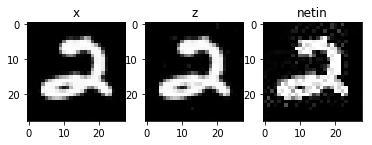

iter = 280: obj_ls = 1.284e+00  |x-z| = 1.517e-02  u_norm = 1.109e-01


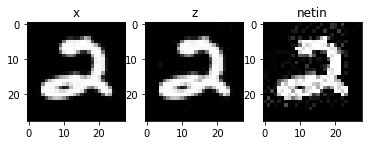

iter = 281: obj_ls = 1.297e+00  |x-z| = 1.498e-02  u_norm = 1.100e-01


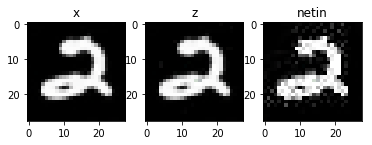

iter = 282: obj_ls = 1.265e+00  |x-z| = 1.499e-02  u_norm = 1.108e-01


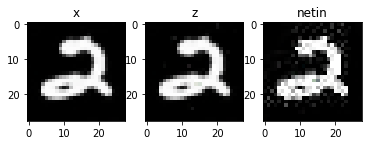

iter = 283: obj_ls = 1.291e+00  |x-z| = 1.499e-02  u_norm = 1.099e-01


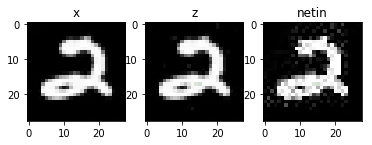

iter = 284: obj_ls = 1.283e+00  |x-z| = 1.500e-02  u_norm = 1.109e-01


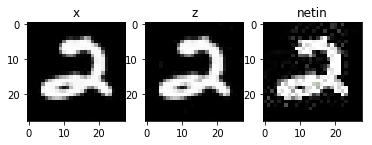

iter = 285: obj_ls = 1.297e+00  |x-z| = 1.482e-02  u_norm = 1.100e-01


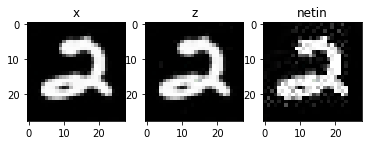

iter = 286: obj_ls = 1.265e+00  |x-z| = 1.483e-02  u_norm = 1.108e-01


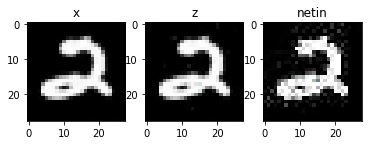

iter = 287: obj_ls = 1.290e+00  |x-z| = 1.484e-02  u_norm = 1.099e-01


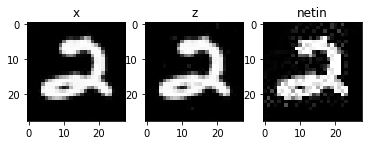

iter = 288: obj_ls = 1.283e+00  |x-z| = 1.485e-02  u_norm = 1.108e-01


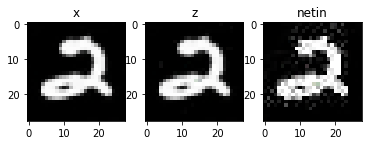

iter = 289: obj_ls = 1.296e+00  |x-z| = 1.468e-02  u_norm = 1.100e-01


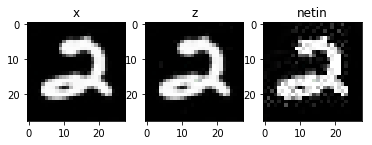

iter = 290: obj_ls = 1.265e+00  |x-z| = 1.469e-02  u_norm = 1.107e-01


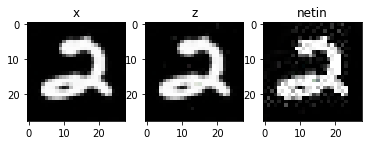

iter = 291: obj_ls = 1.289e+00  |x-z| = 1.469e-02  u_norm = 1.098e-01


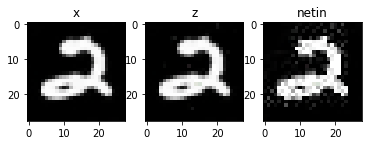

iter = 292: obj_ls = 1.283e+00  |x-z| = 1.471e-02  u_norm = 1.108e-01


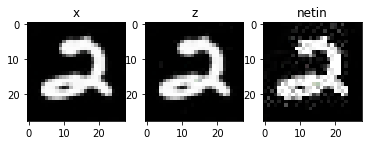

iter = 293: obj_ls = 1.296e+00  |x-z| = 1.455e-02  u_norm = 1.100e-01


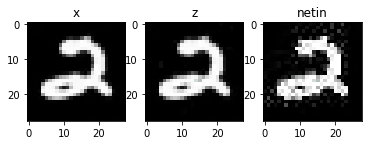

iter = 294: obj_ls = 1.265e+00  |x-z| = 1.456e-02  u_norm = 1.107e-01


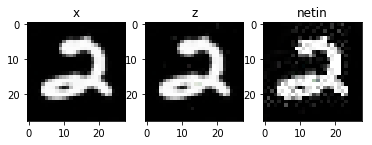

iter = 295: obj_ls = 1.288e+00  |x-z| = 1.456e-02  u_norm = 1.098e-01


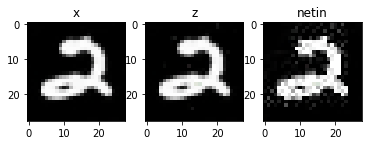

iter = 296: obj_ls = 1.282e+00  |x-z| = 1.458e-02  u_norm = 1.108e-01


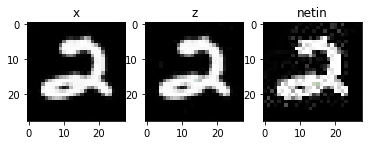

iter = 297: obj_ls = 1.295e+00  |x-z| = 1.442e-02  u_norm = 1.100e-01


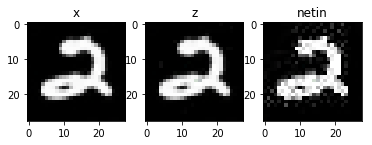

iter = 298: obj_ls = 1.265e+00  |x-z| = 1.444e-02  u_norm = 1.107e-01


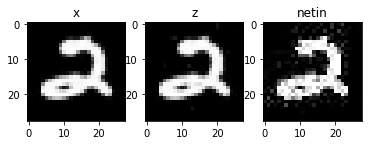

iter = 299: obj_ls = 1.288e+00  |x-z| = 1.443e-02  u_norm = 1.098e-01
inpaint center


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


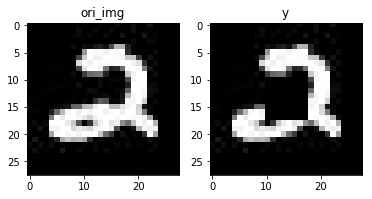

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:162: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:162: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:164: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:164: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


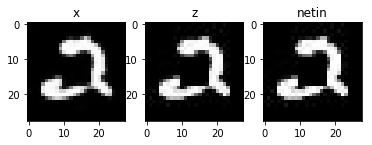

iter = 0: obj_ls = 2.184e+00  |x-z| = 3.665e-02  u_norm = 3.665e-02


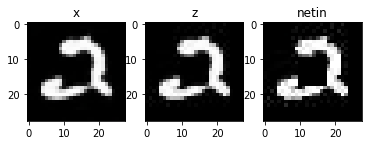

iter = 1: obj_ls = 1.630e+00  |x-z| = 2.575e-02  u_norm = 6.162e-02


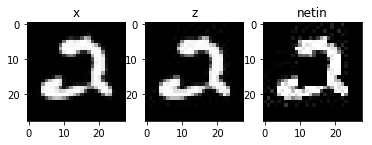

iter = 2: obj_ls = 1.462e+00  |x-z| = 2.004e-02  u_norm = 8.067e-02


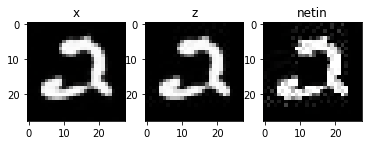

iter = 3: obj_ls = 1.371e+00  |x-z| = 1.596e-02  u_norm = 9.549e-02


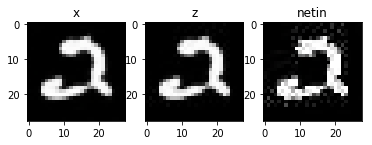

iter = 4: obj_ls = 1.322e+00  |x-z| = 1.568e-02  u_norm = 1.101e-01


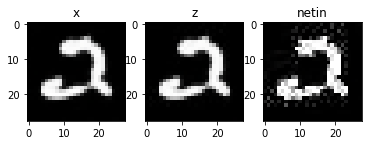

iter = 5: obj_ls = 1.314e+00  |x-z| = 1.037e-02  u_norm = 1.194e-01


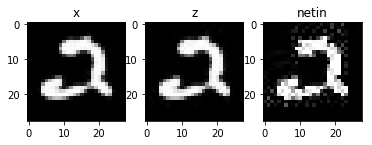

iter = 6: obj_ls = 1.291e+00  |x-z| = 1.012e-02  u_norm = 1.287e-01


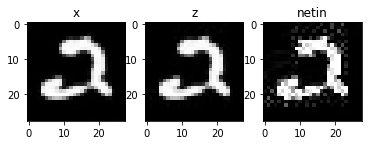

iter = 7: obj_ls = 1.295e+00  |x-z| = 1.007e-02  u_norm = 1.381e-01


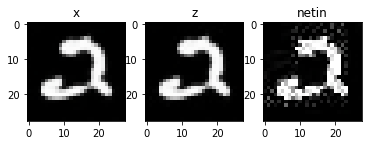

iter = 8: obj_ls = 1.300e+00  |x-z| = 5.880e-03  u_norm = 1.426e-01


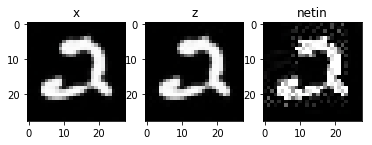

iter = 9: obj_ls = 1.281e+00  |x-z| = 5.355e-03  u_norm = 1.472e-01


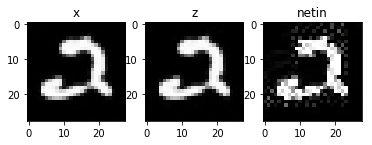

iter = 10: obj_ls = 1.285e+00  |x-z| = 5.184e-03  u_norm = 1.518e-01


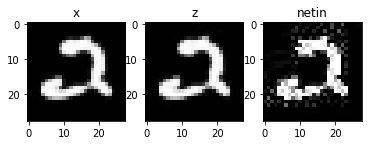

iter = 11: obj_ls = 1.289e+00  |x-z| = 5.271e-03  u_norm = 1.564e-01


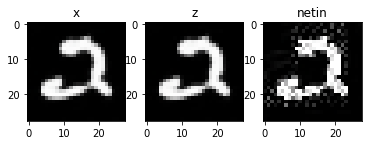

iter = 12: obj_ls = 1.294e+00  |x-z| = 3.369e-03  u_norm = 1.580e-01


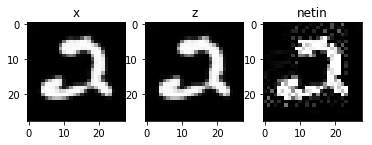

iter = 13: obj_ls = 1.278e+00  |x-z| = 2.685e-03  u_norm = 1.594e-01


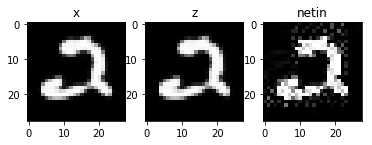

iter = 14: obj_ls = 1.280e+00  |x-z| = 2.138e-03  u_norm = 1.609e-01


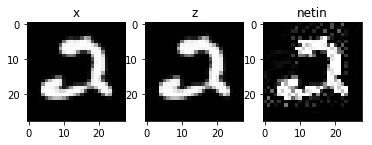

iter = 15: obj_ls = 1.280e+00  |x-z| = 2.129e-03  u_norm = 1.624e-01


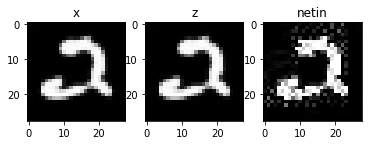

iter = 16: obj_ls = 1.281e+00  |x-z| = 2.140e-03  u_norm = 1.639e-01


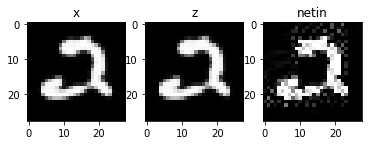

iter = 17: obj_ls = 1.282e+00  |x-z| = 2.157e-03  u_norm = 1.654e-01


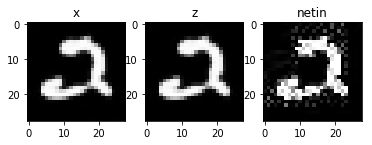

iter = 18: obj_ls = 1.284e+00  |x-z| = 2.180e-03  u_norm = 1.670e-01


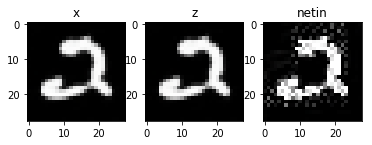

iter = 19: obj_ls = 1.285e+00  |x-z| = 2.207e-03  u_norm = 1.686e-01


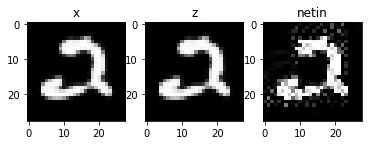

iter = 20: obj_ls = 1.287e+00  |x-z| = 2.238e-03  u_norm = 1.702e-01


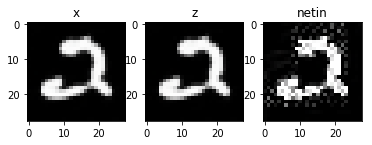

iter = 21: obj_ls = 1.289e+00  |x-z| = 2.273e-03  u_norm = 1.719e-01


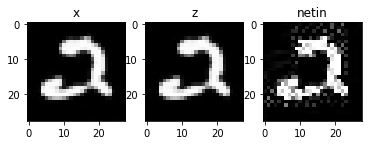

iter = 22: obj_ls = 1.291e+00  |x-z| = 2.312e-03  u_norm = 1.736e-01


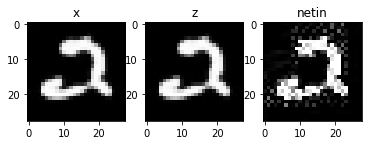

iter = 23: obj_ls = 1.293e+00  |x-z| = 2.839e-03  u_norm = 1.723e-01


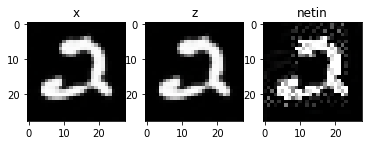

iter = 24: obj_ls = 1.279e+00  |x-z| = 2.507e-03  u_norm = 1.709e-01


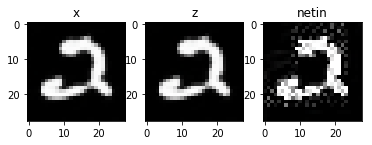

iter = 25: obj_ls = 1.279e+00  |x-z| = 2.097e-03  u_norm = 1.694e-01


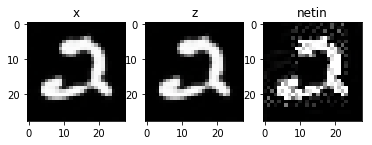

iter = 26: obj_ls = 1.277e+00  |x-z| = 2.122e-03  u_norm = 1.679e-01


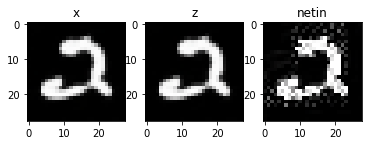

iter = 27: obj_ls = 1.276e+00  |x-z| = 2.144e-03  u_norm = 1.665e-01


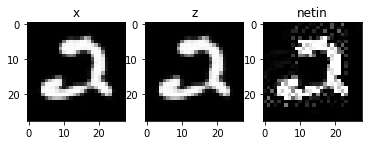

iter = 28: obj_ls = 1.275e+00  |x-z| = 2.164e-03  u_norm = 1.650e-01


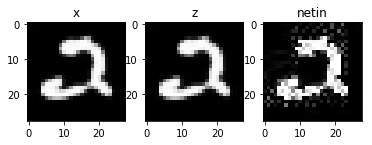

iter = 29: obj_ls = 1.275e+00  |x-z| = 2.181e-03  u_norm = 1.636e-01


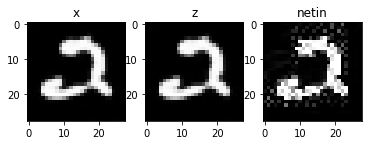

iter = 30: obj_ls = 1.274e+00  |x-z| = 2.196e-03  u_norm = 1.621e-01


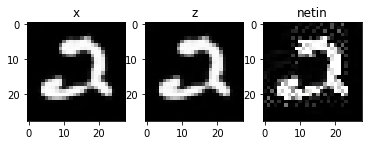

iter = 31: obj_ls = 1.274e+00  |x-z| = 2.210e-03  u_norm = 1.607e-01


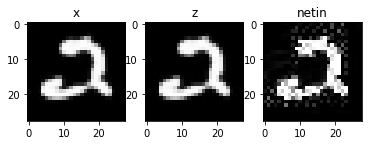

iter = 32: obj_ls = 1.273e+00  |x-z| = 2.221e-03  u_norm = 1.593e-01


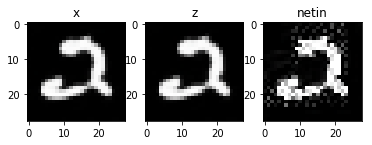

iter = 33: obj_ls = 1.273e+00  |x-z| = 2.232e-03  u_norm = 1.579e-01


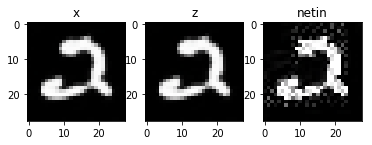

iter = 34: obj_ls = 1.273e+00  |x-z| = 2.240e-03  u_norm = 1.565e-01


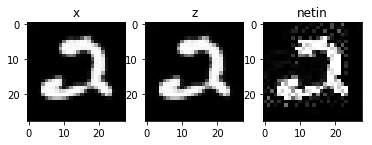

iter = 35: obj_ls = 1.273e+00  |x-z| = 3.434e-03  u_norm = 1.576e-01


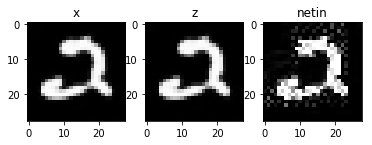

iter = 36: obj_ls = 1.264e+00  |x-z| = 3.260e-03  u_norm = 1.586e-01


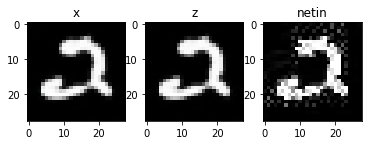

iter = 37: obj_ls = 1.266e+00  |x-z| = 3.003e-03  u_norm = 1.598e-01


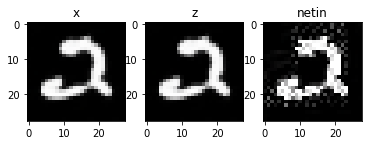

iter = 38: obj_ls = 1.266e+00  |x-z| = 3.005e-03  u_norm = 1.609e-01


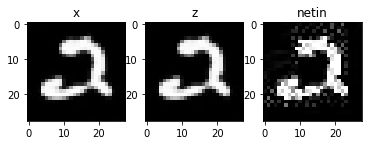

iter = 39: obj_ls = 1.267e+00  |x-z| = 3.015e-03  u_norm = 1.621e-01


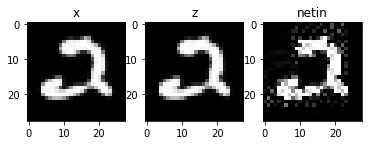

iter = 40: obj_ls = 1.268e+00  |x-z| = 3.029e-03  u_norm = 1.634e-01


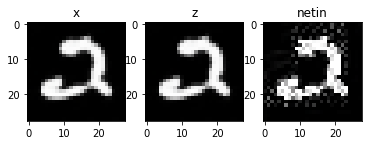

iter = 41: obj_ls = 1.270e+00  |x-z| = 3.047e-03  u_norm = 1.648e-01


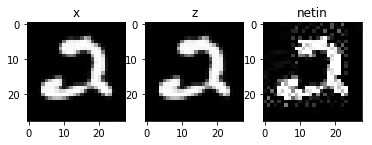

iter = 42: obj_ls = 1.272e+00  |x-z| = 3.068e-03  u_norm = 1.662e-01


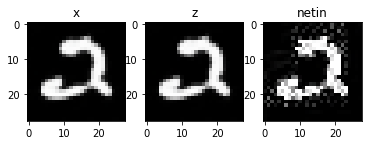

iter = 43: obj_ls = 1.274e+00  |x-z| = 3.094e-03  u_norm = 1.677e-01


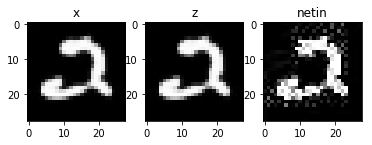

iter = 44: obj_ls = 1.277e+00  |x-z| = 3.123e-03  u_norm = 1.693e-01


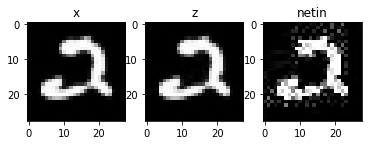

iter = 45: obj_ls = 1.279e+00  |x-z| = 7.484e-03  u_norm = 1.696e-01


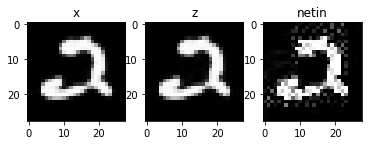

iter = 46: obj_ls = 1.273e+00  |x-z| = 7.294e-03  u_norm = 1.701e-01


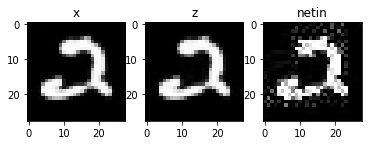

iter = 47: obj_ls = 1.275e+00  |x-z| = 7.051e-03  u_norm = 1.709e-01


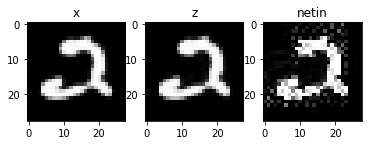

iter = 48: obj_ls = 1.280e+00  |x-z| = 7.062e-03  u_norm = 1.721e-01


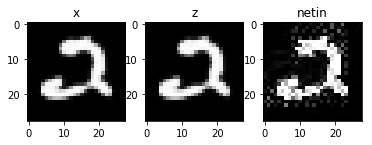

iter = 49: obj_ls = 1.288e+00  |x-z| = 3.907e-03  u_norm = 1.725e-01


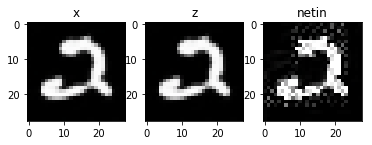

iter = 50: obj_ls = 1.263e+00  |x-z| = 3.460e-03  u_norm = 1.727e-01


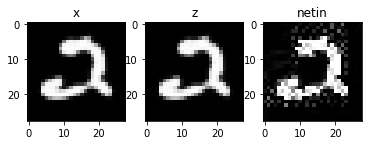

iter = 51: obj_ls = 1.265e+00  |x-z| = 3.282e-03  u_norm = 1.730e-01


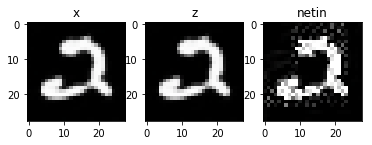

iter = 52: obj_ls = 1.265e+00  |x-z| = 3.252e-03  u_norm = 1.733e-01


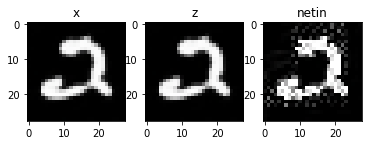

iter = 53: obj_ls = 1.266e+00  |x-z| = 3.240e-03  u_norm = 1.737e-01


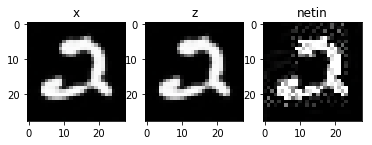

iter = 54: obj_ls = 1.268e+00  |x-z| = 3.236e-03  u_norm = 1.742e-01


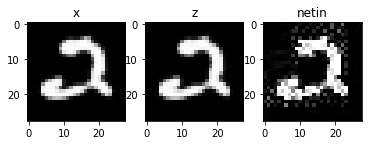

iter = 55: obj_ls = 1.269e+00  |x-z| = 3.237e-03  u_norm = 1.748e-01


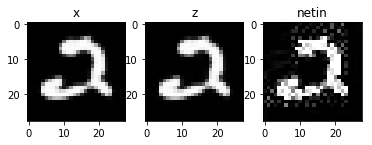

iter = 56: obj_ls = 1.271e+00  |x-z| = 3.001e-03  u_norm = 1.732e-01


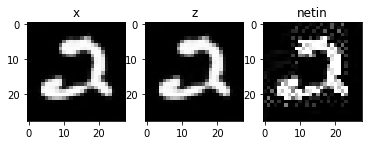

iter = 57: obj_ls = 1.262e+00  |x-z| = 3.059e-03  u_norm = 1.716e-01


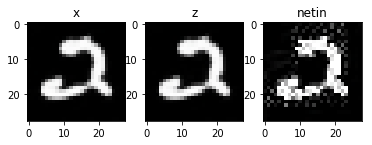

iter = 58: obj_ls = 1.260e+00  |x-z| = 2.980e-03  u_norm = 1.699e-01


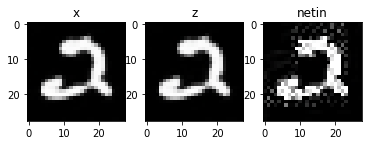

iter = 59: obj_ls = 1.258e+00  |x-z| = 3.008e-03  u_norm = 1.683e-01


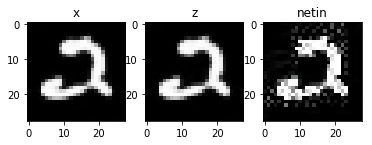

iter = 60: obj_ls = 1.257e+00  |x-z| = 3.033e-03  u_norm = 1.666e-01


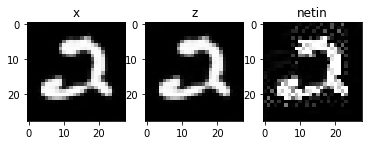

iter = 61: obj_ls = 1.256e+00  |x-z| = 3.053e-03  u_norm = 1.650e-01


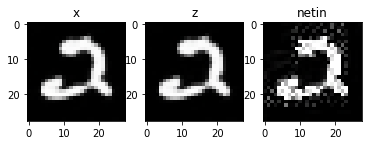

iter = 62: obj_ls = 1.255e+00  |x-z| = 3.070e-03  u_norm = 1.634e-01


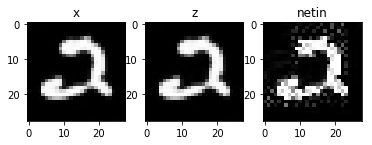

iter = 63: obj_ls = 1.255e+00  |x-z| = 3.084e-03  u_norm = 1.619e-01


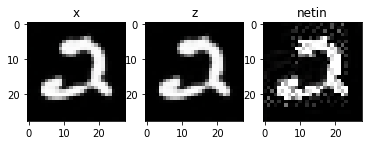

iter = 64: obj_ls = 1.255e+00  |x-z| = 3.094e-03  u_norm = 1.604e-01


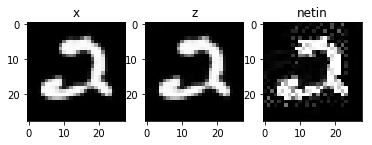

iter = 65: obj_ls = 1.255e+00  |x-z| = 3.103e-03  u_norm = 1.590e-01


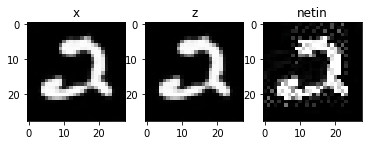

iter = 66: obj_ls = 1.256e+00  |x-z| = 3.280e-03  u_norm = 1.593e-01


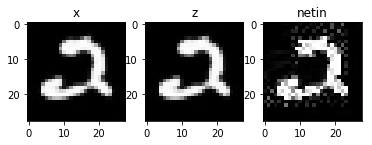

iter = 67: obj_ls = 1.250e+00  |x-z| = 3.147e-03  u_norm = 1.597e-01


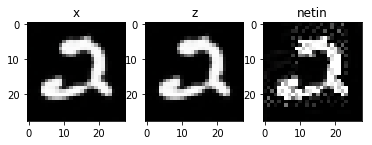

iter = 68: obj_ls = 1.252e+00  |x-z| = 3.137e-03  u_norm = 1.601e-01


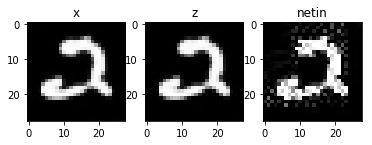

iter = 69: obj_ls = 1.252e+00  |x-z| = 3.132e-03  u_norm = 1.606e-01


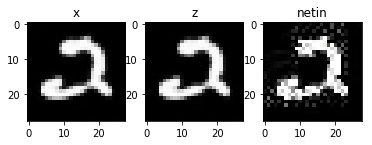

iter = 70: obj_ls = 1.253e+00  |x-z| = 3.137e-03  u_norm = 1.611e-01


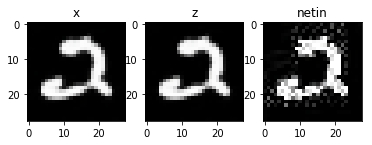

iter = 71: obj_ls = 1.255e+00  |x-z| = 3.145e-03  u_norm = 1.618e-01


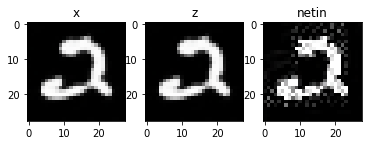

iter = 72: obj_ls = 1.257e+00  |x-z| = 3.157e-03  u_norm = 1.625e-01


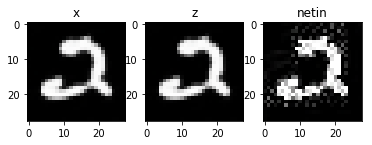

iter = 73: obj_ls = 1.259e+00  |x-z| = 3.172e-03  u_norm = 1.633e-01


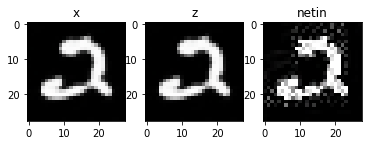

iter = 74: obj_ls = 1.261e+00  |x-z| = 3.191e-03  u_norm = 1.642e-01


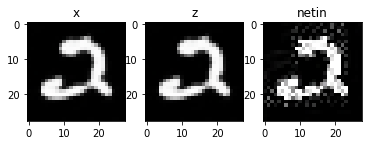

iter = 75: obj_ls = 1.264e+00  |x-z| = 3.214e-03  u_norm = 1.652e-01


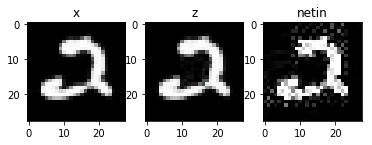

iter = 76: obj_ls = 1.267e+00  |x-z| = 1.947e-02  u_norm = 1.640e-01


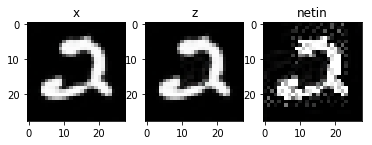

iter = 77: obj_ls = 1.261e+00  |x-z| = 2.019e-02  u_norm = 1.651e-01


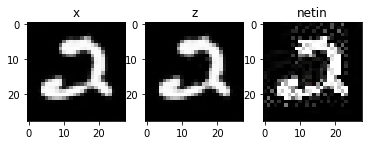

iter = 78: obj_ls = 1.292e+00  |x-z| = 2.016e-02  u_norm = 1.642e-01


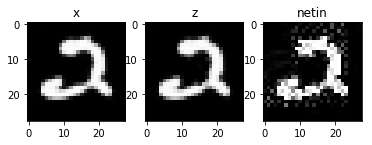

iter = 79: obj_ls = 1.246e+00  |x-z| = 1.966e-02  u_norm = 1.649e-01


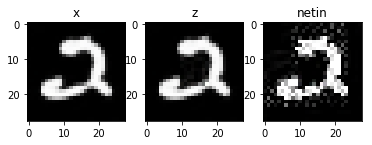

iter = 80: obj_ls = 1.279e+00  |x-z| = 1.954e-02  u_norm = 1.639e-01


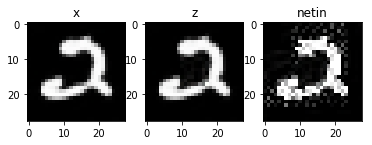

iter = 81: obj_ls = 1.241e+00  |x-z| = 2.019e-02  u_norm = 1.648e-01


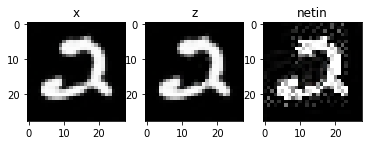

iter = 82: obj_ls = 1.273e+00  |x-z| = 2.014e-02  u_norm = 1.637e-01


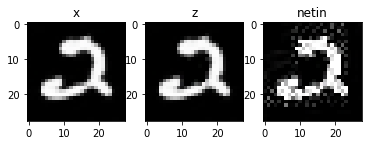

iter = 83: obj_ls = 1.233e+00  |x-z| = 1.976e-02  u_norm = 1.644e-01


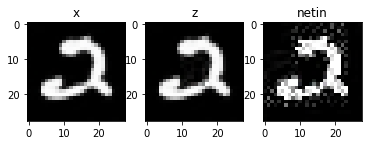

iter = 84: obj_ls = 1.268e+00  |x-z| = 1.962e-02  u_norm = 1.633e-01


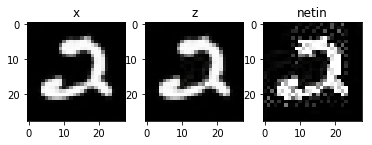

iter = 85: obj_ls = 1.227e+00  |x-z| = 1.979e-02  u_norm = 1.641e-01


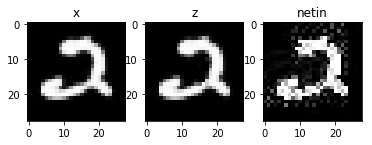

iter = 86: obj_ls = 1.258e+00  |x-z| = 1.972e-02  u_norm = 1.629e-01


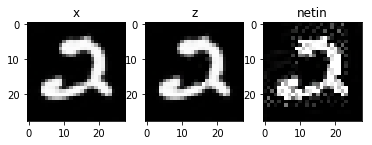

iter = 87: obj_ls = 1.225e+00  |x-z| = 1.941e-02  u_norm = 1.637e-01


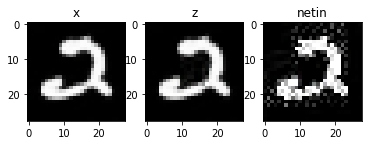

iter = 88: obj_ls = 1.258e+00  |x-z| = 1.929e-02  u_norm = 1.626e-01


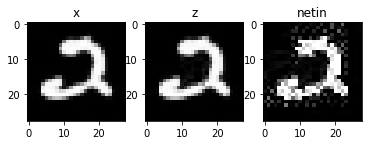

iter = 89: obj_ls = 1.219e+00  |x-z| = 1.911e-02  u_norm = 1.634e-01


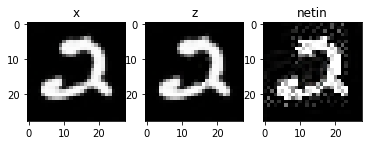

iter = 90: obj_ls = 1.248e+00  |x-z| = 1.904e-02  u_norm = 1.623e-01


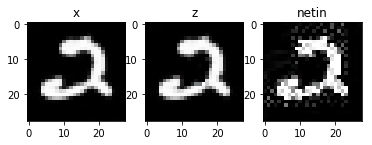

iter = 91: obj_ls = 1.219e+00  |x-z| = 1.878e-02  u_norm = 1.630e-01


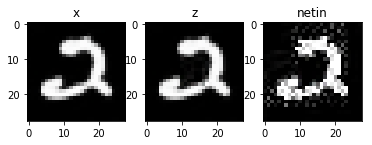

iter = 92: obj_ls = 1.251e+00  |x-z| = 1.868e-02  u_norm = 1.621e-01


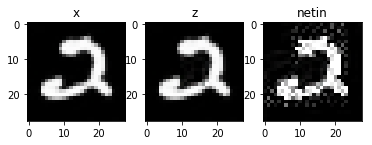

iter = 93: obj_ls = 1.217e+00  |x-z| = 1.846e-02  u_norm = 1.628e-01


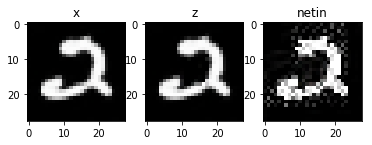

iter = 94: obj_ls = 1.243e+00  |x-z| = 1.840e-02  u_norm = 1.619e-01


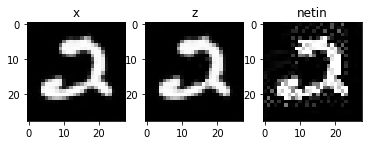

iter = 95: obj_ls = 1.217e+00  |x-z| = 1.822e-02  u_norm = 1.626e-01


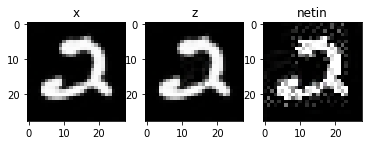

iter = 96: obj_ls = 1.246e+00  |x-z| = 1.813e-02  u_norm = 1.618e-01


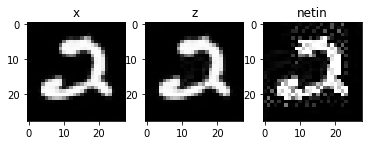

iter = 97: obj_ls = 1.217e+00  |x-z| = 1.798e-02  u_norm = 1.625e-01


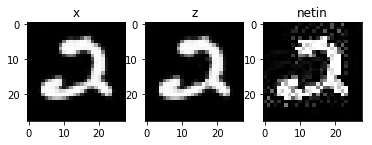

iter = 98: obj_ls = 1.242e+00  |x-z| = 1.793e-02  u_norm = 1.617e-01


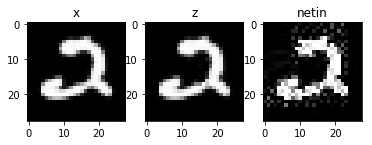

iter = 99: obj_ls = 1.216e+00  |x-z| = 1.782e-02  u_norm = 1.624e-01


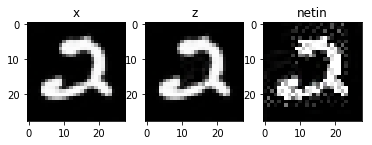

iter = 100: obj_ls = 1.244e+00  |x-z| = 1.773e-02  u_norm = 1.616e-01


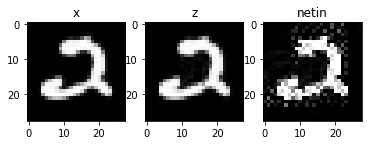

iter = 101: obj_ls = 1.218e+00  |x-z| = 1.764e-02  u_norm = 1.624e-01


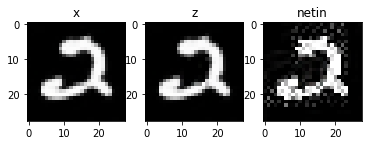

iter = 102: obj_ls = 1.242e+00  |x-z| = 1.759e-02  u_norm = 1.616e-01


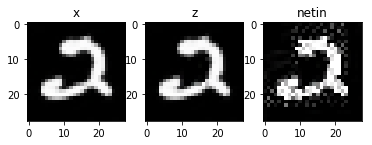

iter = 103: obj_ls = 1.215e+00  |x-z| = 1.752e-02  u_norm = 1.623e-01


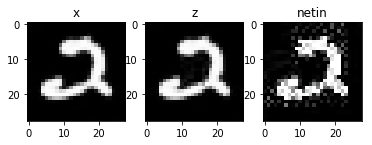

iter = 104: obj_ls = 1.242e+00  |x-z| = 1.743e-02  u_norm = 1.615e-01


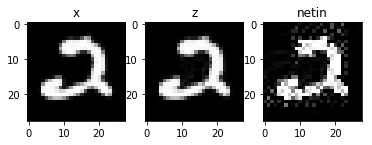

iter = 105: obj_ls = 1.219e+00  |x-z| = 1.738e-02  u_norm = 1.623e-01


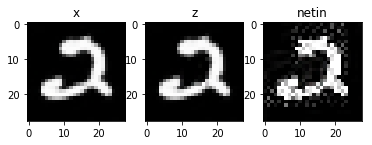

iter = 106: obj_ls = 1.242e+00  |x-z| = 1.733e-02  u_norm = 1.615e-01


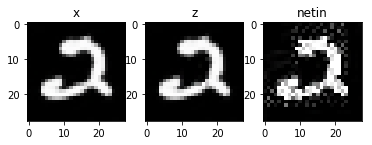

iter = 107: obj_ls = 1.215e+00  |x-z| = 1.729e-02  u_norm = 1.622e-01


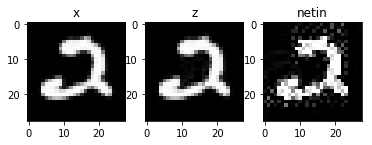

iter = 108: obj_ls = 1.241e+00  |x-z| = 1.720e-02  u_norm = 1.615e-01


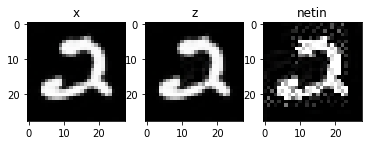

iter = 109: obj_ls = 1.219e+00  |x-z| = 1.716e-02  u_norm = 1.622e-01


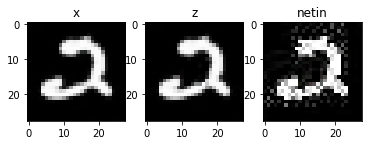

iter = 110: obj_ls = 1.242e+00  |x-z| = 1.712e-02  u_norm = 1.615e-01


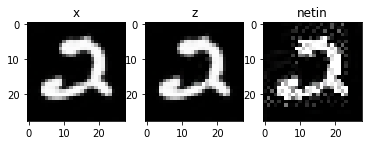

iter = 111: obj_ls = 1.215e+00  |x-z| = 1.710e-02  u_norm = 1.622e-01


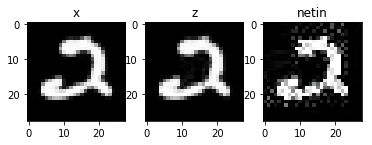

iter = 112: obj_ls = 1.240e+00  |x-z| = 1.700e-02  u_norm = 1.614e-01


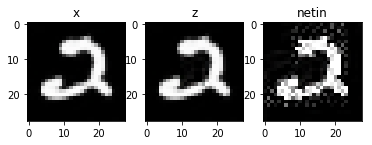

iter = 113: obj_ls = 1.219e+00  |x-z| = 1.698e-02  u_norm = 1.622e-01


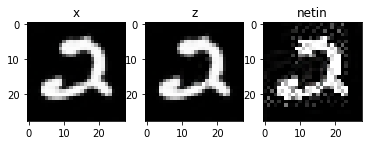

iter = 114: obj_ls = 1.242e+00  |x-z| = 1.693e-02  u_norm = 1.615e-01


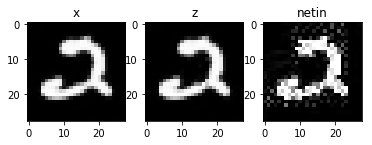

iter = 115: obj_ls = 1.214e+00  |x-z| = 1.692e-02  u_norm = 1.621e-01


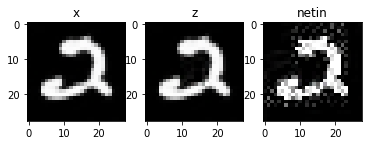

iter = 116: obj_ls = 1.239e+00  |x-z| = 1.682e-02  u_norm = 1.614e-01


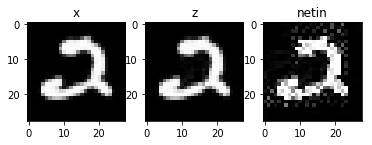

iter = 117: obj_ls = 1.219e+00  |x-z| = 1.681e-02  u_norm = 1.622e-01


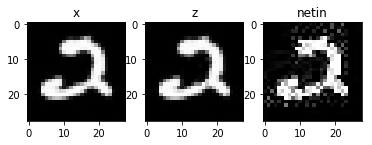

iter = 118: obj_ls = 1.242e+00  |x-z| = 1.676e-02  u_norm = 1.615e-01


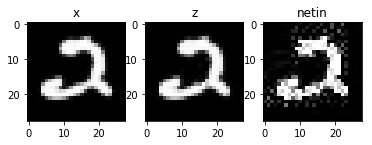

iter = 119: obj_ls = 1.214e+00  |x-z| = 1.676e-02  u_norm = 1.621e-01


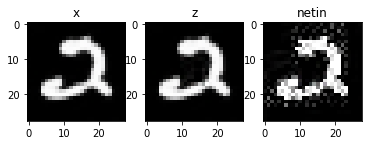

iter = 120: obj_ls = 1.239e+00  |x-z| = 1.666e-02  u_norm = 1.614e-01


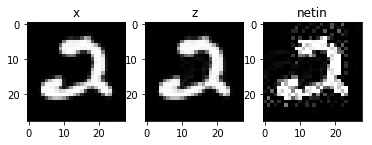

iter = 121: obj_ls = 1.219e+00  |x-z| = 1.664e-02  u_norm = 1.621e-01


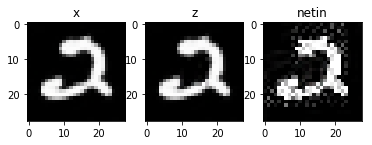

iter = 122: obj_ls = 1.242e+00  |x-z| = 1.660e-02  u_norm = 1.615e-01


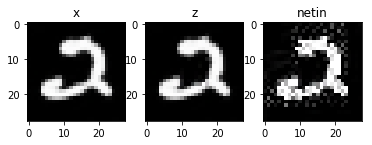

iter = 123: obj_ls = 1.214e+00  |x-z| = 1.660e-02  u_norm = 1.621e-01


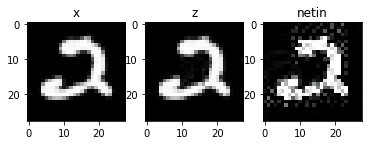

iter = 124: obj_ls = 1.238e+00  |x-z| = 1.650e-02  u_norm = 1.614e-01


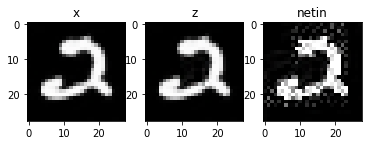

iter = 125: obj_ls = 1.219e+00  |x-z| = 1.649e-02  u_norm = 1.621e-01


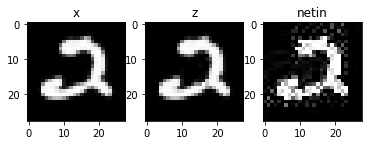

iter = 126: obj_ls = 1.241e+00  |x-z| = 1.645e-02  u_norm = 1.614e-01


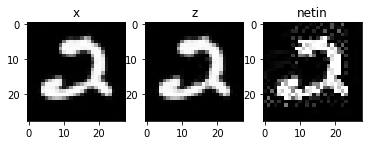

iter = 127: obj_ls = 1.214e+00  |x-z| = 1.645e-02  u_norm = 1.621e-01


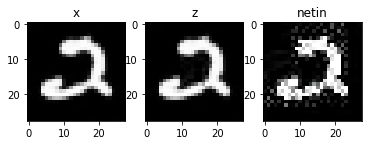

iter = 128: obj_ls = 1.238e+00  |x-z| = 1.635e-02  u_norm = 1.614e-01


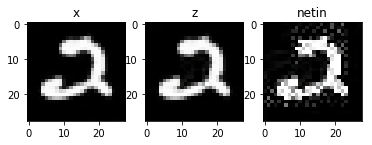

iter = 129: obj_ls = 1.219e+00  |x-z| = 1.634e-02  u_norm = 1.621e-01


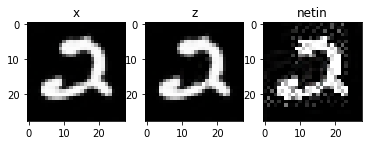

iter = 130: obj_ls = 1.241e+00  |x-z| = 1.630e-02  u_norm = 1.614e-01


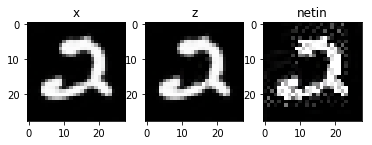

iter = 131: obj_ls = 1.213e+00  |x-z| = 1.630e-02  u_norm = 1.620e-01


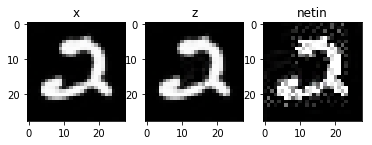

iter = 132: obj_ls = 1.237e+00  |x-z| = 1.620e-02  u_norm = 1.614e-01


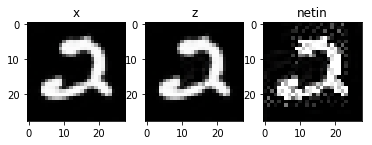

iter = 133: obj_ls = 1.219e+00  |x-z| = 1.619e-02  u_norm = 1.621e-01


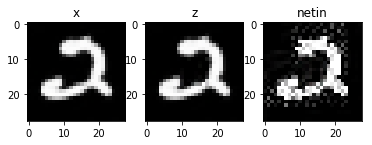

iter = 134: obj_ls = 1.241e+00  |x-z| = 1.616e-02  u_norm = 1.614e-01


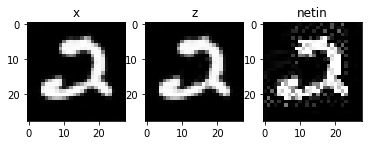

iter = 135: obj_ls = 1.213e+00  |x-z| = 1.615e-02  u_norm = 1.620e-01


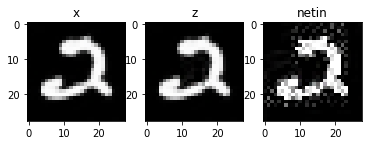

iter = 136: obj_ls = 1.236e+00  |x-z| = 1.606e-02  u_norm = 1.613e-01


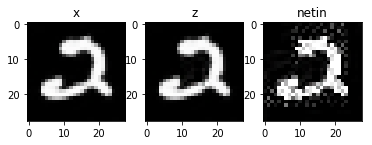

iter = 137: obj_ls = 1.219e+00  |x-z| = 1.605e-02  u_norm = 1.620e-01


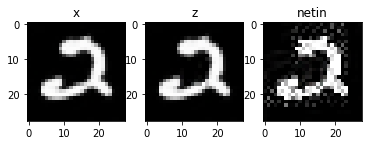

iter = 138: obj_ls = 1.240e+00  |x-z| = 1.601e-02  u_norm = 1.614e-01


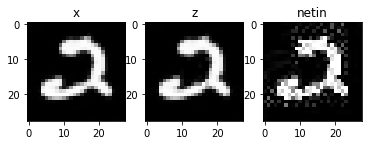

iter = 139: obj_ls = 1.213e+00  |x-z| = 1.601e-02  u_norm = 1.620e-01


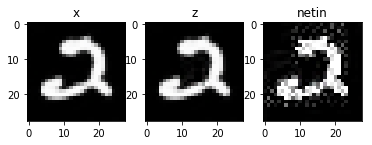

iter = 140: obj_ls = 1.236e+00  |x-z| = 1.592e-02  u_norm = 1.613e-01


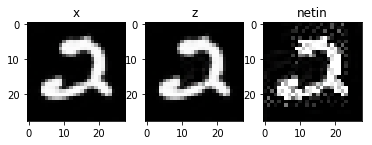

iter = 141: obj_ls = 1.219e+00  |x-z| = 1.591e-02  u_norm = 1.620e-01


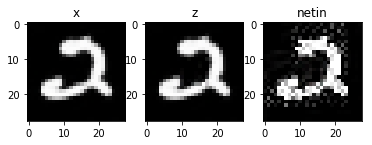

iter = 142: obj_ls = 1.240e+00  |x-z| = 1.587e-02  u_norm = 1.614e-01


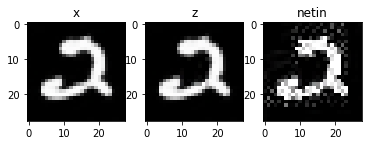

iter = 143: obj_ls = 1.213e+00  |x-z| = 1.587e-02  u_norm = 1.619e-01


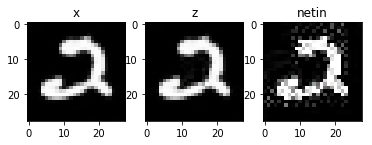

iter = 144: obj_ls = 1.235e+00  |x-z| = 1.578e-02  u_norm = 1.613e-01


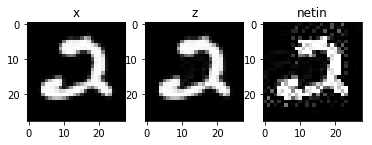

iter = 145: obj_ls = 1.219e+00  |x-z| = 1.577e-02  u_norm = 1.620e-01


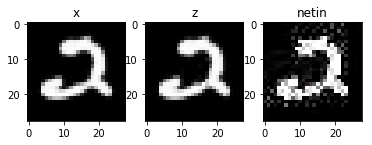

iter = 146: obj_ls = 1.240e+00  |x-z| = 1.574e-02  u_norm = 1.614e-01


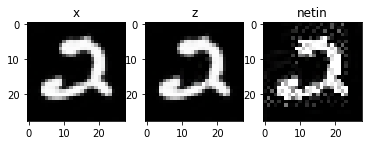

iter = 147: obj_ls = 1.213e+00  |x-z| = 1.574e-02  u_norm = 1.619e-01


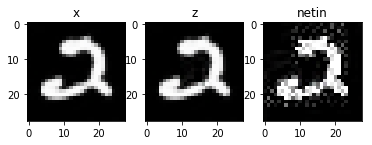

iter = 148: obj_ls = 1.235e+00  |x-z| = 1.565e-02  u_norm = 1.613e-01


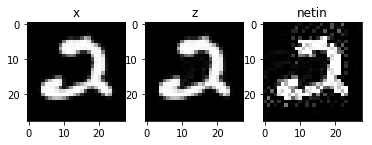

iter = 149: obj_ls = 1.218e+00  |x-z| = 1.564e-02  u_norm = 1.619e-01


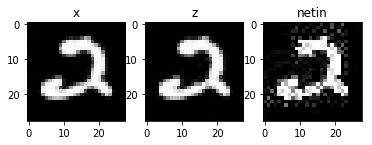

iter = 150: obj_ls = 1.239e+00  |x-z| = 1.560e-02  u_norm = 1.614e-01


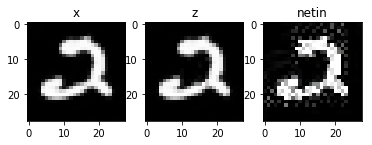

iter = 151: obj_ls = 1.212e+00  |x-z| = 1.560e-02  u_norm = 1.619e-01


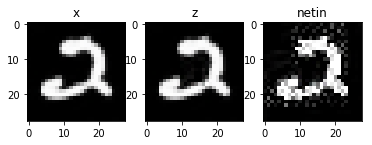

iter = 152: obj_ls = 1.234e+00  |x-z| = 1.552e-02  u_norm = 1.613e-01


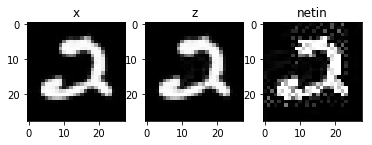

iter = 153: obj_ls = 1.218e+00  |x-z| = 1.550e-02  u_norm = 1.619e-01


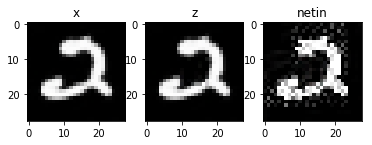

iter = 154: obj_ls = 1.239e+00  |x-z| = 1.547e-02  u_norm = 1.613e-01


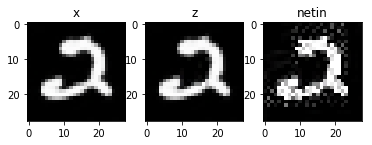

iter = 155: obj_ls = 1.212e+00  |x-z| = 1.547e-02  u_norm = 1.619e-01


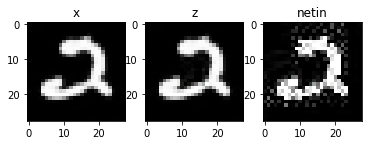

iter = 156: obj_ls = 1.234e+00  |x-z| = 1.539e-02  u_norm = 1.613e-01


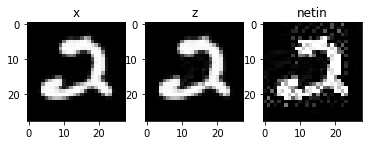

iter = 157: obj_ls = 1.218e+00  |x-z| = 1.538e-02  u_norm = 1.619e-01


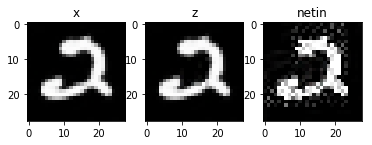

iter = 158: obj_ls = 1.238e+00  |x-z| = 1.534e-02  u_norm = 1.613e-01


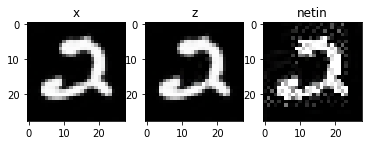

iter = 159: obj_ls = 1.212e+00  |x-z| = 1.534e-02  u_norm = 1.618e-01


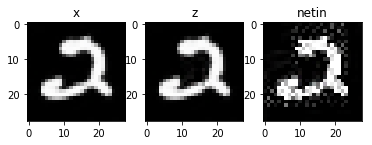

iter = 160: obj_ls = 1.233e+00  |x-z| = 1.526e-02  u_norm = 1.612e-01


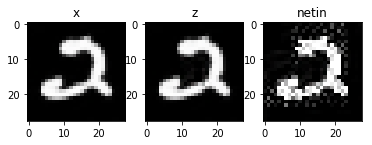

iter = 161: obj_ls = 1.218e+00  |x-z| = 1.525e-02  u_norm = 1.619e-01


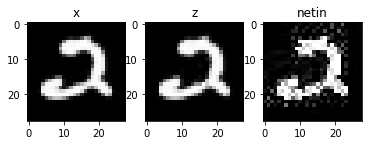

iter = 162: obj_ls = 1.238e+00  |x-z| = 1.522e-02  u_norm = 1.613e-01


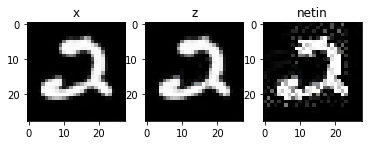

iter = 163: obj_ls = 1.212e+00  |x-z| = 1.522e-02  u_norm = 1.618e-01


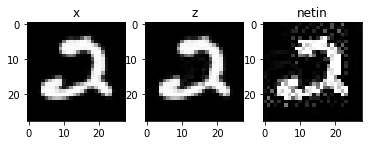

iter = 164: obj_ls = 1.233e+00  |x-z| = 1.514e-02  u_norm = 1.612e-01


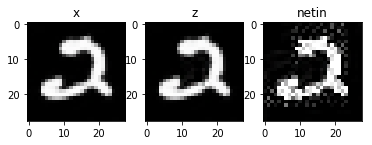

iter = 165: obj_ls = 1.218e+00  |x-z| = 1.512e-02  u_norm = 1.618e-01


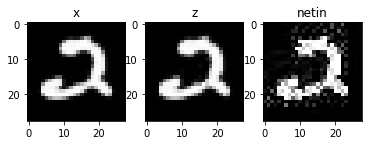

iter = 166: obj_ls = 1.237e+00  |x-z| = 1.509e-02  u_norm = 1.613e-01


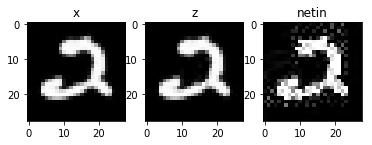

iter = 167: obj_ls = 1.211e+00  |x-z| = 1.509e-02  u_norm = 1.618e-01


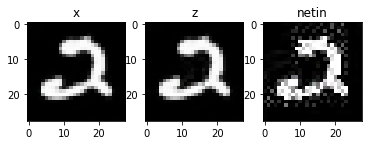

iter = 168: obj_ls = 1.232e+00  |x-z| = 1.501e-02  u_norm = 1.612e-01


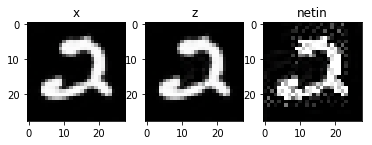

iter = 169: obj_ls = 1.217e+00  |x-z| = 1.500e-02  u_norm = 1.618e-01


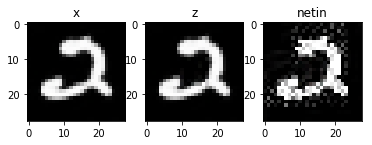

iter = 170: obj_ls = 1.237e+00  |x-z| = 1.497e-02  u_norm = 1.613e-01


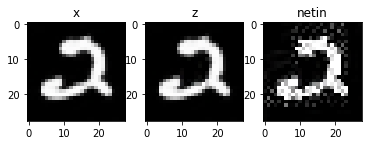

iter = 171: obj_ls = 1.211e+00  |x-z| = 1.497e-02  u_norm = 1.617e-01


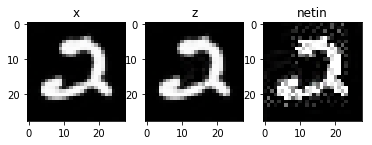

iter = 172: obj_ls = 1.232e+00  |x-z| = 1.489e-02  u_norm = 1.612e-01


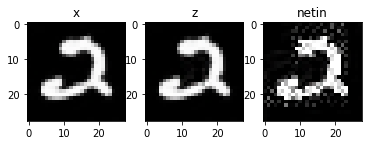

iter = 173: obj_ls = 1.217e+00  |x-z| = 1.488e-02  u_norm = 1.618e-01


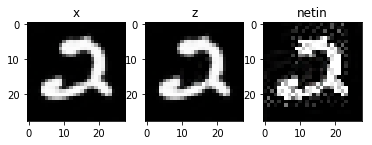

iter = 174: obj_ls = 1.237e+00  |x-z| = 1.485e-02  u_norm = 1.612e-01


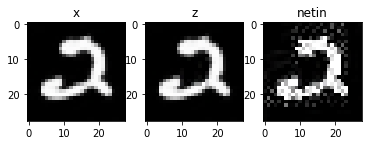

iter = 175: obj_ls = 1.211e+00  |x-z| = 1.485e-02  u_norm = 1.617e-01


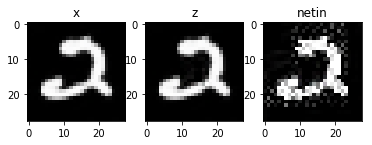

iter = 176: obj_ls = 1.231e+00  |x-z| = 1.477e-02  u_norm = 1.612e-01


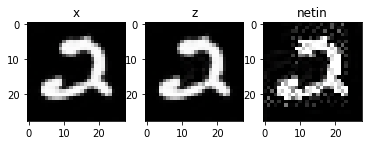

iter = 177: obj_ls = 1.217e+00  |x-z| = 1.476e-02  u_norm = 1.617e-01


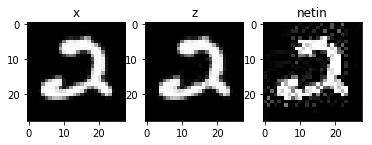

iter = 178: obj_ls = 1.236e+00  |x-z| = 1.473e-02  u_norm = 1.612e-01


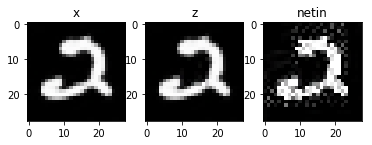

iter = 179: obj_ls = 1.210e+00  |x-z| = 1.473e-02  u_norm = 1.617e-01


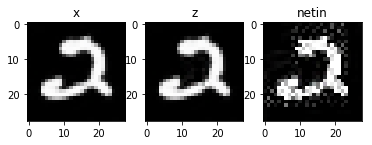

iter = 180: obj_ls = 1.230e+00  |x-z| = 1.466e-02  u_norm = 1.611e-01


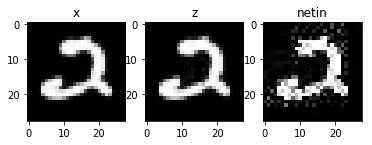

iter = 181: obj_ls = 1.216e+00  |x-z| = 1.465e-02  u_norm = 1.617e-01


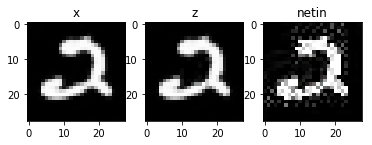

iter = 182: obj_ls = 1.236e+00  |x-z| = 1.462e-02  u_norm = 1.612e-01


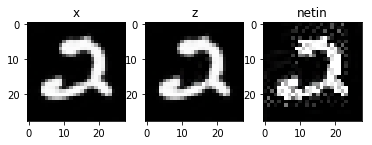

iter = 183: obj_ls = 1.210e+00  |x-z| = 1.462e-02  u_norm = 1.617e-01


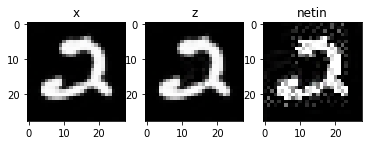

iter = 184: obj_ls = 1.230e+00  |x-z| = 1.454e-02  u_norm = 1.611e-01


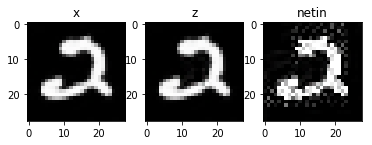

iter = 185: obj_ls = 1.216e+00  |x-z| = 1.453e-02  u_norm = 1.617e-01


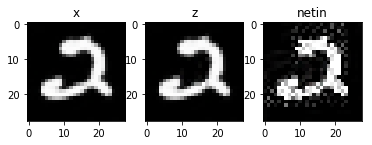

iter = 186: obj_ls = 1.235e+00  |x-z| = 1.450e-02  u_norm = 1.612e-01


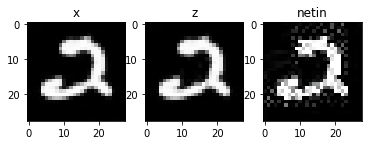

iter = 187: obj_ls = 1.210e+00  |x-z| = 1.451e-02  u_norm = 1.616e-01


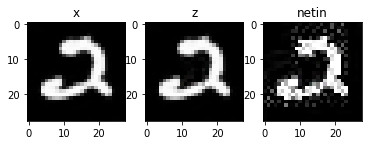

iter = 188: obj_ls = 1.229e+00  |x-z| = 1.443e-02  u_norm = 1.611e-01


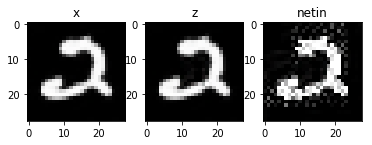

iter = 189: obj_ls = 1.216e+00  |x-z| = 1.442e-02  u_norm = 1.616e-01


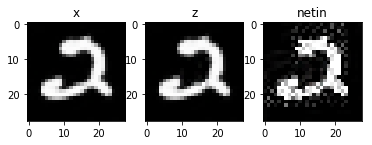

iter = 190: obj_ls = 1.235e+00  |x-z| = 1.439e-02  u_norm = 1.611e-01


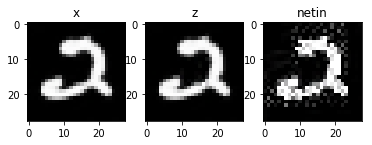

iter = 191: obj_ls = 1.209e+00  |x-z| = 1.439e-02  u_norm = 1.616e-01


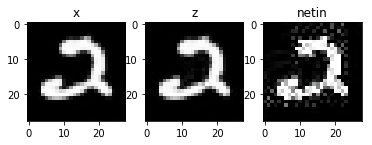

iter = 192: obj_ls = 1.229e+00  |x-z| = 1.432e-02  u_norm = 1.611e-01


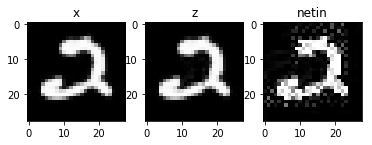

iter = 193: obj_ls = 1.216e+00  |x-z| = 1.431e-02  u_norm = 1.616e-01


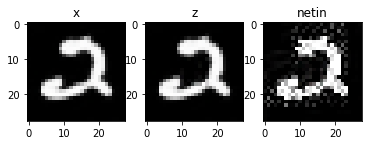

iter = 194: obj_ls = 1.234e+00  |x-z| = 1.428e-02  u_norm = 1.611e-01


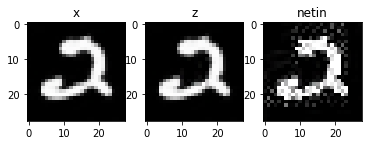

iter = 195: obj_ls = 1.209e+00  |x-z| = 1.428e-02  u_norm = 1.616e-01


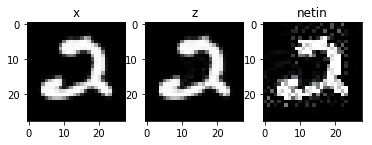

iter = 196: obj_ls = 1.228e+00  |x-z| = 1.421e-02  u_norm = 1.610e-01


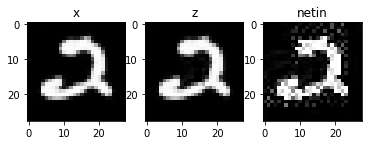

iter = 197: obj_ls = 1.215e+00  |x-z| = 1.420e-02  u_norm = 1.616e-01


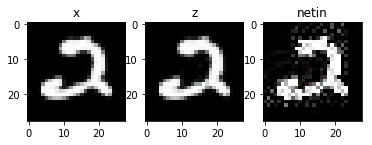

iter = 198: obj_ls = 1.234e+00  |x-z| = 1.418e-02  u_norm = 1.611e-01


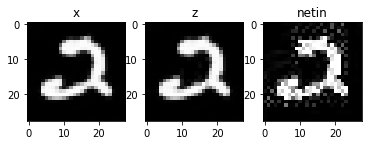

iter = 199: obj_ls = 1.208e+00  |x-z| = 1.418e-02  u_norm = 1.615e-01


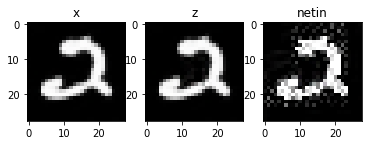

iter = 200: obj_ls = 1.228e+00  |x-z| = 1.411e-02  u_norm = 1.610e-01


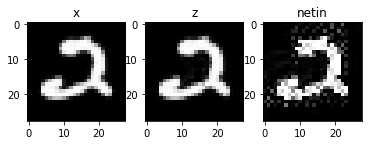

iter = 201: obj_ls = 1.215e+00  |x-z| = 1.409e-02  u_norm = 1.615e-01


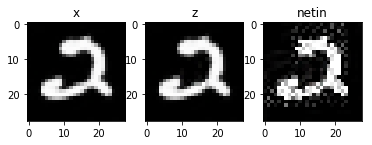

iter = 202: obj_ls = 1.233e+00  |x-z| = 1.407e-02  u_norm = 1.611e-01


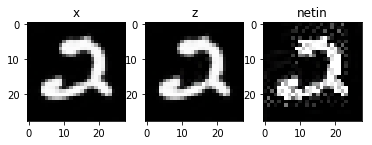

iter = 203: obj_ls = 1.208e+00  |x-z| = 1.407e-02  u_norm = 1.615e-01


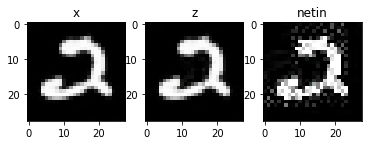

iter = 204: obj_ls = 1.227e+00  |x-z| = 1.400e-02  u_norm = 1.610e-01


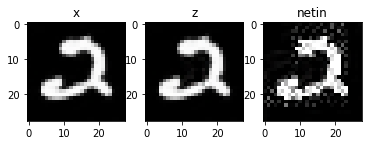

iter = 205: obj_ls = 1.215e+00  |x-z| = 1.399e-02  u_norm = 1.615e-01


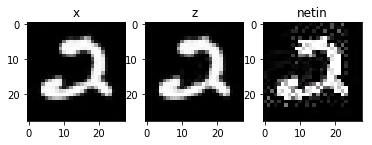

iter = 206: obj_ls = 1.233e+00  |x-z| = 1.397e-02  u_norm = 1.610e-01


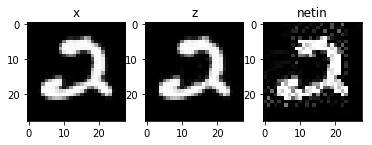

iter = 207: obj_ls = 1.208e+00  |x-z| = 1.397e-02  u_norm = 1.614e-01


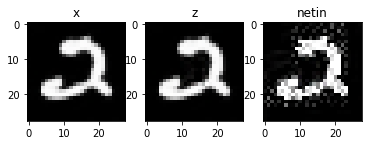

iter = 208: obj_ls = 1.226e+00  |x-z| = 1.390e-02  u_norm = 1.609e-01


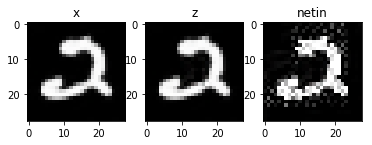

iter = 209: obj_ls = 1.214e+00  |x-z| = 1.389e-02  u_norm = 1.615e-01


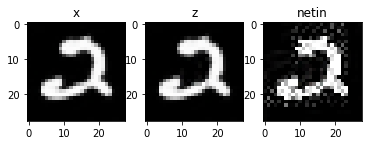

iter = 210: obj_ls = 1.232e+00  |x-z| = 1.386e-02  u_norm = 1.610e-01


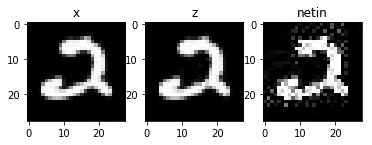

iter = 211: obj_ls = 1.207e+00  |x-z| = 1.387e-02  u_norm = 1.614e-01


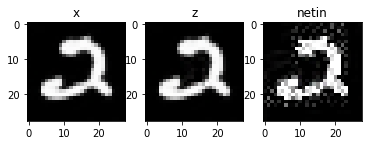

iter = 212: obj_ls = 1.226e+00  |x-z| = 1.380e-02  u_norm = 1.609e-01


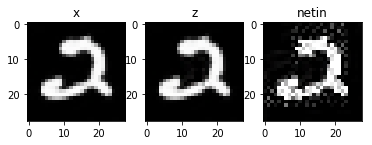

iter = 213: obj_ls = 1.214e+00  |x-z| = 1.379e-02  u_norm = 1.614e-01


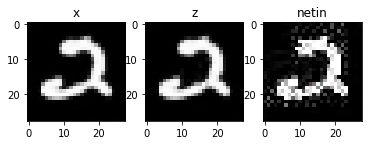

iter = 214: obj_ls = 1.232e+00  |x-z| = 1.376e-02  u_norm = 1.610e-01


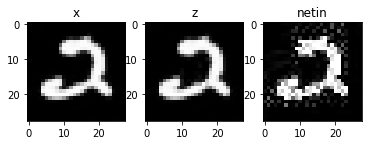

iter = 215: obj_ls = 1.207e+00  |x-z| = 1.377e-02  u_norm = 1.614e-01


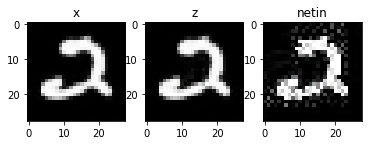

iter = 216: obj_ls = 1.225e+00  |x-z| = 1.370e-02  u_norm = 1.609e-01


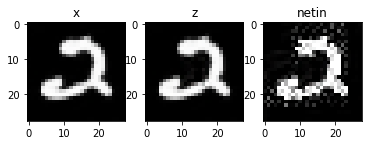

iter = 217: obj_ls = 1.214e+00  |x-z| = 1.369e-02  u_norm = 1.614e-01


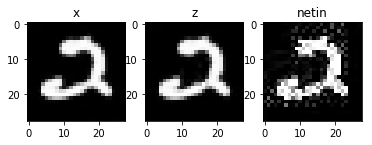

iter = 218: obj_ls = 1.231e+00  |x-z| = 1.367e-02  u_norm = 1.610e-01


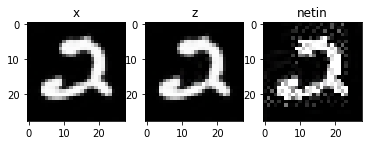

iter = 219: obj_ls = 1.207e+00  |x-z| = 1.367e-02  u_norm = 1.613e-01


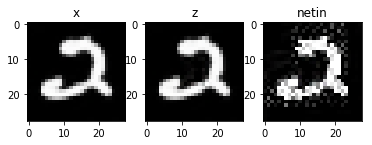

iter = 220: obj_ls = 1.225e+00  |x-z| = 1.361e-02  u_norm = 1.609e-01


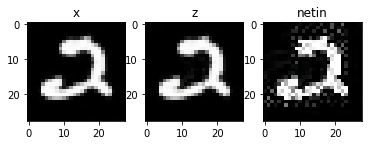

iter = 221: obj_ls = 1.213e+00  |x-z| = 1.359e-02  u_norm = 1.614e-01


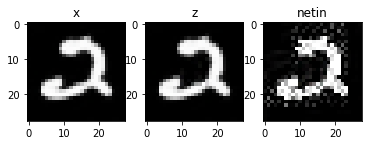

iter = 222: obj_ls = 1.231e+00  |x-z| = 1.357e-02  u_norm = 1.609e-01


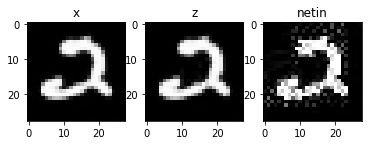

iter = 223: obj_ls = 1.206e+00  |x-z| = 1.357e-02  u_norm = 1.613e-01


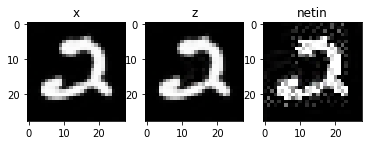

iter = 224: obj_ls = 1.224e+00  |x-z| = 1.351e-02  u_norm = 1.608e-01


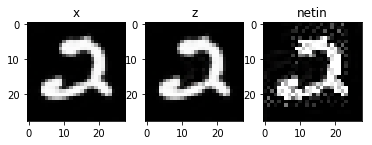

iter = 225: obj_ls = 1.213e+00  |x-z| = 1.350e-02  u_norm = 1.613e-01


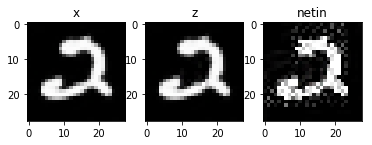

iter = 226: obj_ls = 1.230e+00  |x-z| = 1.348e-02  u_norm = 1.609e-01


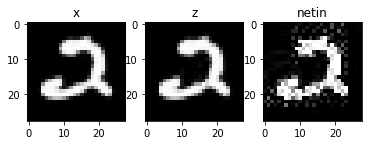

iter = 227: obj_ls = 1.206e+00  |x-z| = 1.348e-02  u_norm = 1.613e-01


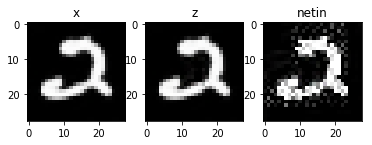

iter = 228: obj_ls = 1.224e+00  |x-z| = 1.342e-02  u_norm = 1.608e-01


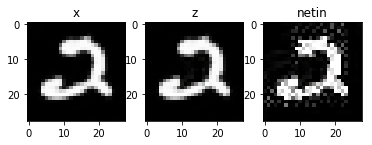

iter = 229: obj_ls = 1.213e+00  |x-z| = 1.341e-02  u_norm = 1.613e-01


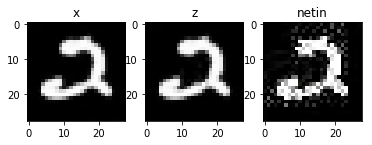

iter = 230: obj_ls = 1.230e+00  |x-z| = 1.338e-02  u_norm = 1.609e-01


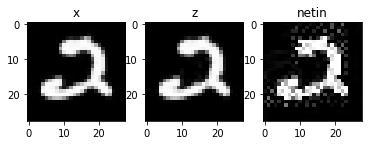

iter = 231: obj_ls = 1.206e+00  |x-z| = 1.339e-02  u_norm = 1.613e-01


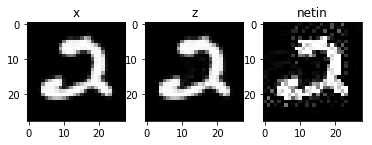

iter = 232: obj_ls = 1.223e+00  |x-z| = 1.333e-02  u_norm = 1.608e-01


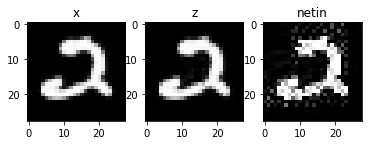

iter = 233: obj_ls = 1.212e+00  |x-z| = 1.331e-02  u_norm = 1.613e-01


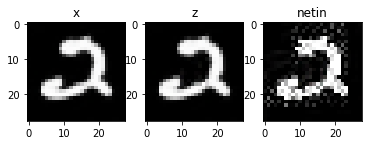

iter = 234: obj_ls = 1.229e+00  |x-z| = 1.329e-02  u_norm = 1.609e-01


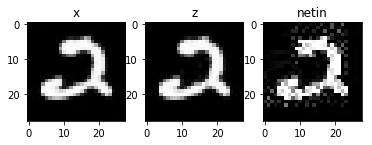

iter = 235: obj_ls = 1.205e+00  |x-z| = 1.330e-02  u_norm = 1.612e-01


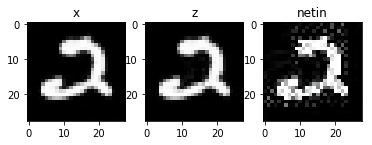

iter = 236: obj_ls = 1.223e+00  |x-z| = 1.324e-02  u_norm = 1.608e-01


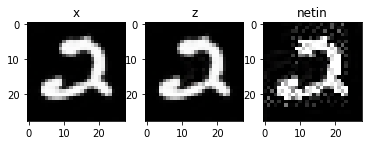

iter = 237: obj_ls = 1.212e+00  |x-z| = 1.323e-02  u_norm = 1.612e-01


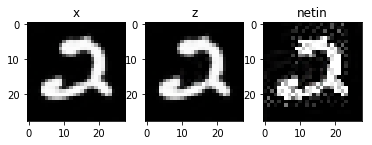

iter = 238: obj_ls = 1.229e+00  |x-z| = 1.320e-02  u_norm = 1.608e-01


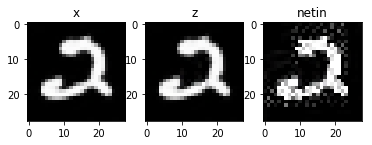

iter = 239: obj_ls = 1.205e+00  |x-z| = 1.321e-02  u_norm = 1.612e-01


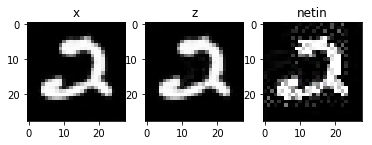

iter = 240: obj_ls = 1.222e+00  |x-z| = 1.315e-02  u_norm = 1.607e-01


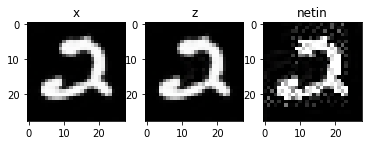

iter = 241: obj_ls = 1.212e+00  |x-z| = 1.314e-02  u_norm = 1.612e-01


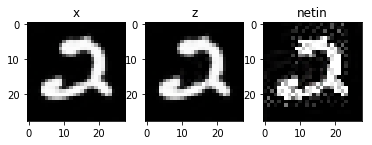

iter = 242: obj_ls = 1.229e+00  |x-z| = 1.312e-02  u_norm = 1.608e-01


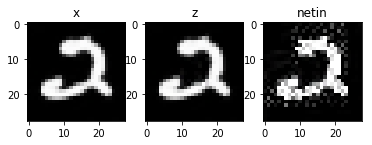

iter = 243: obj_ls = 1.205e+00  |x-z| = 1.313e-02  u_norm = 1.612e-01


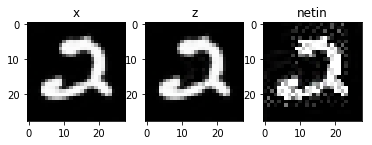

iter = 244: obj_ls = 1.222e+00  |x-z| = 1.307e-02  u_norm = 1.607e-01


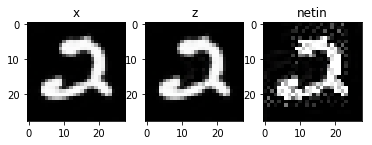

iter = 245: obj_ls = 1.212e+00  |x-z| = 1.305e-02  u_norm = 1.612e-01


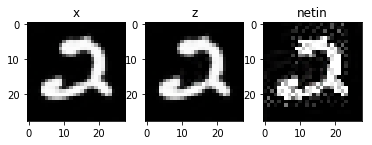

iter = 246: obj_ls = 1.228e+00  |x-z| = 1.303e-02  u_norm = 1.608e-01


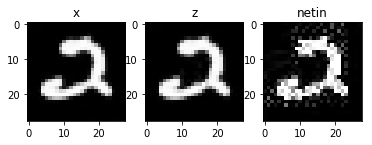

iter = 247: obj_ls = 1.205e+00  |x-z| = 1.304e-02  u_norm = 1.611e-01


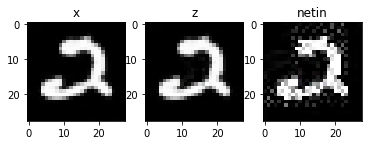

iter = 248: obj_ls = 1.221e+00  |x-z| = 1.299e-02  u_norm = 1.607e-01


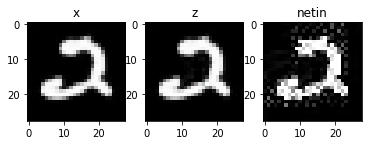

iter = 249: obj_ls = 1.211e+00  |x-z| = 1.297e-02  u_norm = 1.612e-01


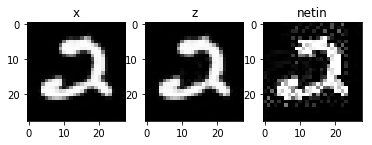

iter = 250: obj_ls = 1.228e+00  |x-z| = 1.295e-02  u_norm = 1.608e-01


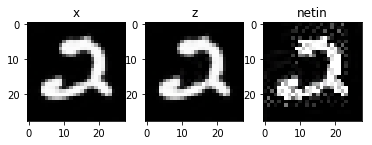

iter = 251: obj_ls = 1.204e+00  |x-z| = 1.296e-02  u_norm = 1.611e-01


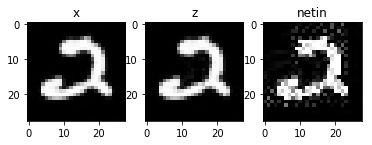

iter = 252: obj_ls = 1.221e+00  |x-z| = 1.290e-02  u_norm = 1.607e-01


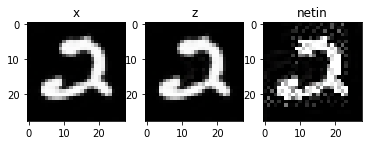

iter = 253: obj_ls = 1.211e+00  |x-z| = 1.289e-02  u_norm = 1.611e-01


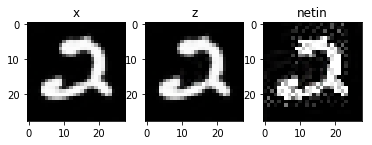

iter = 254: obj_ls = 1.227e+00  |x-z| = 1.287e-02  u_norm = 1.608e-01


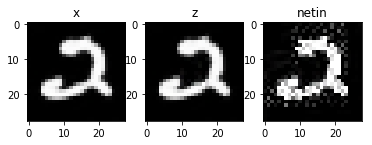

iter = 255: obj_ls = 1.204e+00  |x-z| = 1.288e-02  u_norm = 1.611e-01


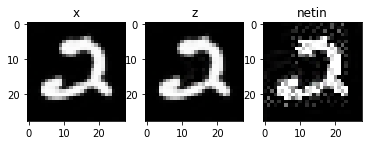

iter = 256: obj_ls = 1.221e+00  |x-z| = 1.283e-02  u_norm = 1.607e-01


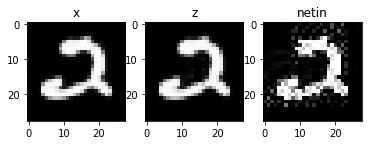

iter = 257: obj_ls = 1.211e+00  |x-z| = 1.281e-02  u_norm = 1.611e-01


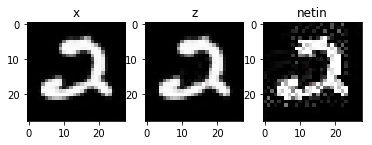

iter = 258: obj_ls = 1.227e+00  |x-z| = 1.279e-02  u_norm = 1.607e-01


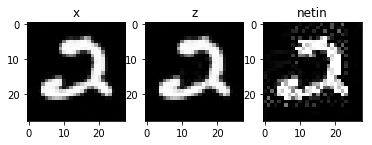

iter = 259: obj_ls = 1.204e+00  |x-z| = 1.280e-02  u_norm = 1.611e-01


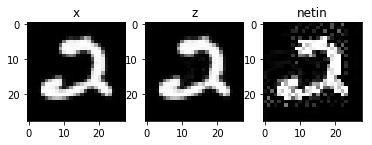

iter = 260: obj_ls = 1.220e+00  |x-z| = 1.275e-02  u_norm = 1.606e-01


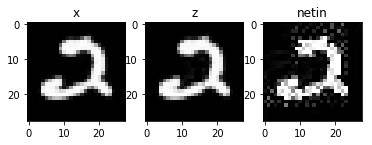

iter = 261: obj_ls = 1.211e+00  |x-z| = 1.274e-02  u_norm = 1.611e-01


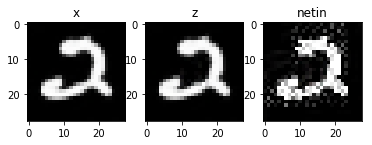

iter = 262: obj_ls = 1.227e+00  |x-z| = 1.272e-02  u_norm = 1.607e-01


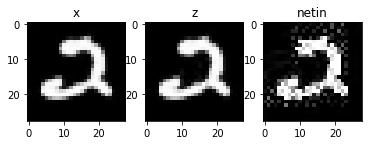

iter = 263: obj_ls = 1.204e+00  |x-z| = 1.273e-02  u_norm = 1.611e-01


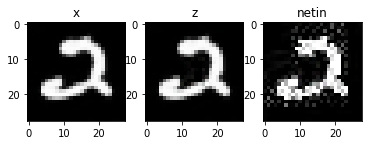

iter = 264: obj_ls = 1.220e+00  |x-z| = 1.267e-02  u_norm = 1.606e-01


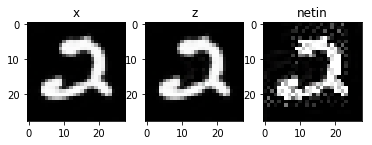

iter = 265: obj_ls = 1.211e+00  |x-z| = 1.266e-02  u_norm = 1.611e-01


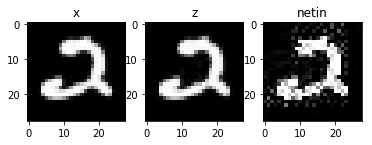

iter = 266: obj_ls = 1.227e+00  |x-z| = 1.264e-02  u_norm = 1.607e-01


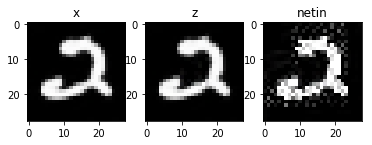

iter = 267: obj_ls = 1.204e+00  |x-z| = 1.265e-02  u_norm = 1.610e-01


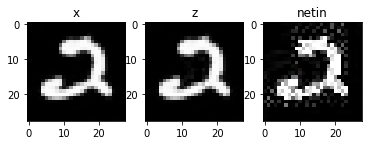

iter = 268: obj_ls = 1.220e+00  |x-z| = 1.260e-02  u_norm = 1.606e-01


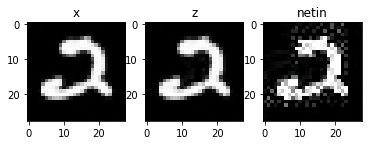

iter = 269: obj_ls = 1.210e+00  |x-z| = 1.259e-02  u_norm = 1.610e-01


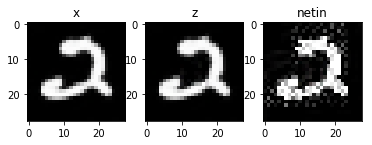

iter = 270: obj_ls = 1.226e+00  |x-z| = 1.257e-02  u_norm = 1.607e-01


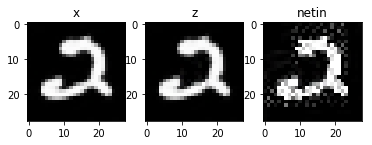

iter = 271: obj_ls = 1.203e+00  |x-z| = 1.258e-02  u_norm = 1.610e-01


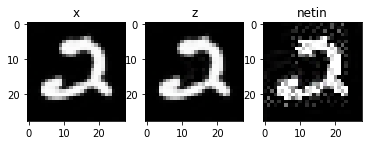

iter = 272: obj_ls = 1.220e+00  |x-z| = 1.253e-02  u_norm = 1.606e-01


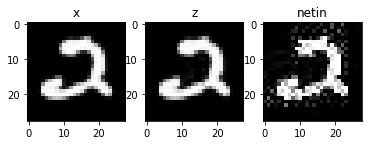

iter = 273: obj_ls = 1.210e+00  |x-z| = 1.252e-02  u_norm = 1.610e-01


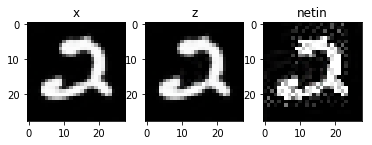

iter = 274: obj_ls = 1.226e+00  |x-z| = 1.250e-02  u_norm = 1.607e-01


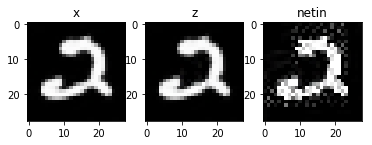

iter = 275: obj_ls = 1.203e+00  |x-z| = 1.251e-02  u_norm = 1.610e-01


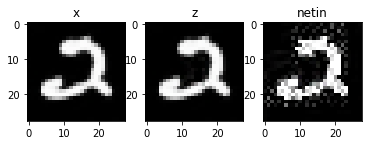

iter = 276: obj_ls = 1.219e+00  |x-z| = 1.246e-02  u_norm = 1.606e-01


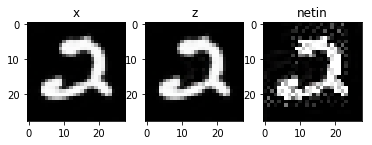

iter = 277: obj_ls = 1.210e+00  |x-z| = 1.245e-02  u_norm = 1.610e-01


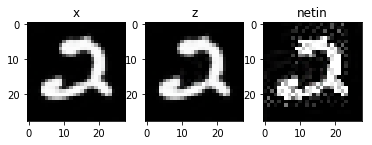

iter = 278: obj_ls = 1.226e+00  |x-z| = 1.243e-02  u_norm = 1.607e-01


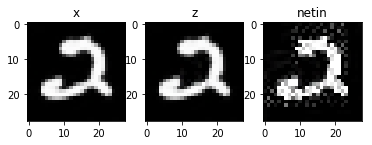

iter = 279: obj_ls = 1.203e+00  |x-z| = 1.245e-02  u_norm = 1.610e-01


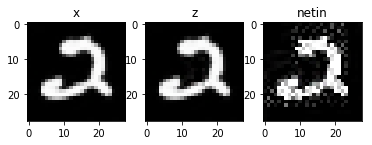

iter = 280: obj_ls = 1.219e+00  |x-z| = 1.240e-02  u_norm = 1.606e-01


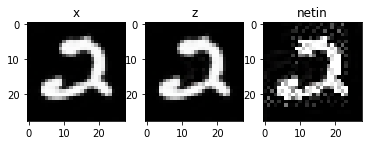

iter = 281: obj_ls = 1.210e+00  |x-z| = 1.239e-02  u_norm = 1.610e-01


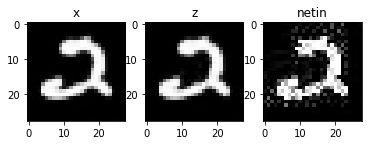

iter = 282: obj_ls = 1.226e+00  |x-z| = 1.237e-02  u_norm = 1.607e-01


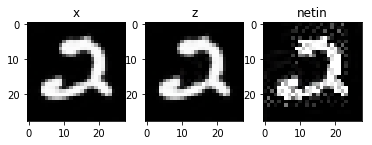

iter = 283: obj_ls = 1.203e+00  |x-z| = 1.238e-02  u_norm = 1.610e-01


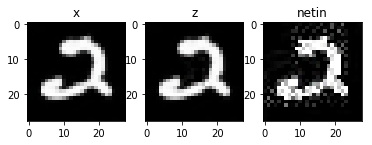

iter = 284: obj_ls = 1.219e+00  |x-z| = 1.233e-02  u_norm = 1.606e-01


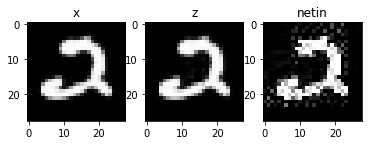

iter = 285: obj_ls = 1.210e+00  |x-z| = 1.232e-02  u_norm = 1.610e-01


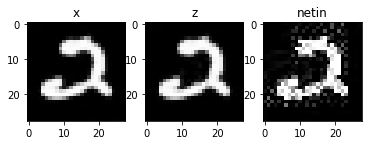

iter = 286: obj_ls = 1.226e+00  |x-z| = 1.230e-02  u_norm = 1.607e-01


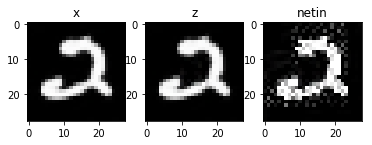

iter = 287: obj_ls = 1.203e+00  |x-z| = 1.232e-02  u_norm = 1.610e-01


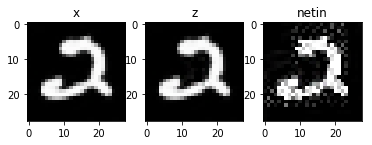

iter = 288: obj_ls = 1.219e+00  |x-z| = 1.227e-02  u_norm = 1.606e-01


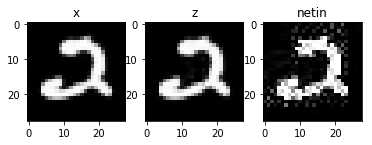

iter = 289: obj_ls = 1.210e+00  |x-z| = 1.226e-02  u_norm = 1.610e-01


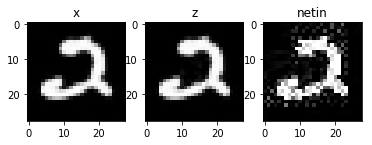

iter = 290: obj_ls = 1.225e+00  |x-z| = 1.224e-02  u_norm = 1.606e-01


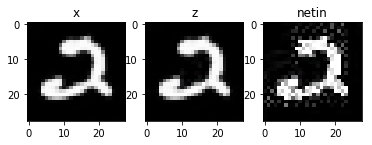

iter = 291: obj_ls = 1.203e+00  |x-z| = 1.226e-02  u_norm = 1.609e-01


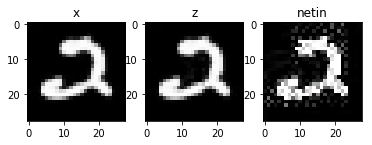

iter = 292: obj_ls = 1.219e+00  |x-z| = 1.221e-02  u_norm = 1.606e-01


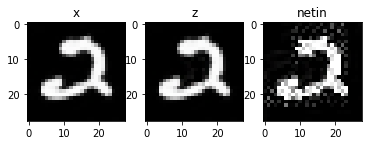

iter = 293: obj_ls = 1.210e+00  |x-z| = 1.220e-02  u_norm = 1.610e-01


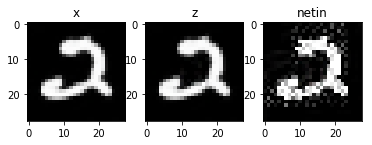

iter = 294: obj_ls = 1.225e+00  |x-z| = 1.218e-02  u_norm = 1.606e-01


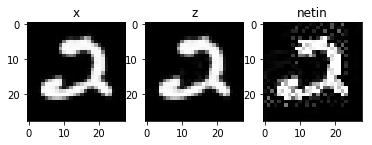

iter = 295: obj_ls = 1.203e+00  |x-z| = 1.220e-02  u_norm = 1.609e-01


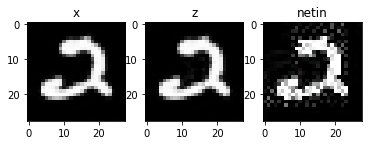

iter = 296: obj_ls = 1.218e+00  |x-z| = 1.216e-02  u_norm = 1.605e-01


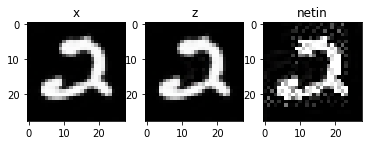

iter = 297: obj_ls = 1.210e+00  |x-z| = 1.214e-02  u_norm = 1.610e-01


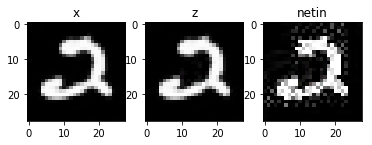

iter = 298: obj_ls = 1.225e+00  |x-z| = 1.213e-02  u_norm = 1.606e-01


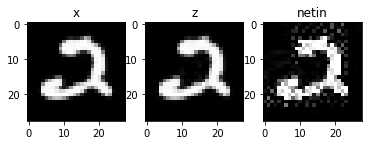

iter = 299: obj_ls = 1.203e+00  |x-z| = 1.215e-02  u_norm = 1.609e-01


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:189: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [30]:
img =load_image("/home/ubuntu/OneNet/img_1.jpg")
print(img.shape)
print(img_size[0])
ori_img = np.reshape(img, [1, img_size[0],img_size[1],img_size[2]], order='F')
idx = 0

result_folder = '%s/%d' % (clean_paper_results,idx)
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

if run_ours:
    direct_img = denoise(ori_img)
if show_img_progress:
    plt.figure('original')
    img_plot = plt.imshow(reshape_img(ori_img))
    plt.pause(0.001)

    plt.figure('direct')
    img_plot = plt.imshow((reshape_img(np.clip(denoise(direct_img),0.0,1.0))*255).astype(np.uint8))
    plt.pause(0.001)


filename = '%s/ori_img.jpg' % result_folder
sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

if run_ours:
    filename = '%s/direct_img.jpg' % result_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(direct_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


##############################################################################################
##### super resolution
print ('super resolution')

#set parameters
alpha = 0.5 # 1.0
max_iter = 30
solver_tol = 2e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

resize_ratio = 0.5
noise_std = 0.0
results = solve_superres(ori_img, denoise, reshape_img, resize_ratio=resize_ratio,
                         noise_std=noise_std,
                         alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

#################################################################################################
##### compressive sensing
print ('compressive sensing')

#set parameters
alpha = 0.3
max_iter = 300
solver_tol = 3e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

compress_ratio = 0.1
noise_std = 0.0
results = solve_cs(ori_img, denoise, reshape_img, compress_ratio=compress_ratio,
                   noise_std=noise_std,
                   alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

############################################################################################
#### denoising

print ('denoising')

# set parameter
alpha = 0.3
max_iter = 300
solver_tol = 3e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

drop_prob = 0.5
noise_std = 0.1

results = solve_denoising_dropping(ori_img, denoise, reshape_img, drop_prob=drop_prob,
                                   noise_mean=0, noise_std=noise_std,
                                   alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

##########################################################################################
## inpaint block

print ('inpaint block')

# set parameter
alpha = 0.3
max_iter = 300
solver_tol = 1e-4

alpha_l1 = 0.3
lambda_l1 = 0.03
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

box_size = int(0.1 * ori_img.shape[1])
noise_std = 0.0
total_box = 10
results = solve_inpaint_block(ori_img, denoise, reshape_img, box_size=box_size, total_box=total_box,
                              noise_std=noise_std,
                              alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

############################################################################################
### inpaint center
print ('inpaint center')

alpha = 0.2 
max_iter = 300
solver_tol = 1e-5
alpha_update_ratio = 1.0

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

box_size = int(0.3 * ori_img.shape[1])
noise_std = 0.0
results = solve_inpaint_center(ori_img, denoise, reshape_img, box_size=box_size,
noise_std=noise_std,
alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

if run_ours:
    tf.reset_default_graph()





<a class="anchor" id="10"></a>
## 10.0 Results of ADMM

<a class="anchor" id="10.1"></a>
### 10.1 MNIST

After training the MNIST dataset for 60000 iterations, we run ADMM to solve for **compressive sensing, denoising, inpaint blocks, inpaint center and super-resolution**

Since the input of compressive sensing cannot be visualized, we show the ground truth instead.

The model is available here - https://drive.google.com/drive/folders/1yrhsUdRla5EcbThW2N_z8ZMhgyL6CLNc?usp=sharing

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-1.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-2.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-3.png">
<br>


<a class="anchor" id="10.2"></a>
### 10.2 MS - CELEB - 1M 

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-1.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-2.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-3.png">
<br>

<a class="anchor" id="10.3"></a>
### 10.3 Results from the Paper

Blockwise inpainting on Imagenet does not give good results and it fills in the missing region with random images, thus not generating natural images.


When it comes to Denoising and Super-resolution, OneNet seems to be doing better and has comparable results with SOTA techniques.

#### Imagenet

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/imagenet-results.png">
<br>



#### Denoising vs BM3D

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/denoising-vs-BM3D.png">
<br>

#### Super-resolution 

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/super-res.png">
<br>

<a class="anchor" id="10.4"></a>
### 10.4 Failure Cases

Block-wise inpainting, especially on Imagenet seems to be failing with OneNet. It is trying to fill in random edges in the missing regions. In these cases, the projection network fails to project inputs to the natural image set and hence affects the overall ADMM framework. Even though increasing $\rho$ can improve the convergence, it may produce low-quality, overly smoothed outputs.

